# Imports

In [1]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed

import warnings
warnings.filterwarnings("ignore")

import loo_q2 as loo

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    # plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker=".",facecolor='none',s=200)
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker=".",s=200) # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color='red',marker=".",linewidth=3, s=200)     #,alpha=0.25  "#8da9f5"
    plt.plot(y_train,yy_fit_line,color="darkgrey",linestyle='--',dashes=[5,15]) #,alpha=0.2
    if leg:
        plt.legend(loc='lower right', fontsize=10)
    plt.xlabel(label+" measured",fontsize=18, fontweight='bold')
    plt.ylabel(label+" predicted",fontsize=18, fontweight='bold')
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav, dpi=300, bbox_inches='tight', transparent=True)
        
def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
    """Reapeated k-fold cross-validation. 
    For each of n repeats, the (training)data is split into k folds. 
    For each fold, this part of the data is predicted using the rest. 
    Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
    This is repeated n times and all n R^2 are returned for averaging/further analysis
    """
    
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

# keepmodels = []

import random
insu = ["yikes. that's ass.","LMAO do not publish this what are you doing","oof.","that's a rough one","I'm embarassed to even print this, but here it is:","more disappointing than an unsalted pretzel","this model makes onions cry","did you get this model from Joe?","remember, these stats aren't an insult, they're just describing your model","this model reminds me - I gotta take out the trash","don't worry - the first 40 years of modeling are always the hardest","this model has miles to go before it reaches mediocre","the bad model store called. they're running out of your models"]

# Reading data

In [2]:
conda env export > environment_2.yml


Note: you may need to restart the kernel to use updated packages.


## Single File

In [7]:
# all data in a single file
excel_file ="aMD_parameters_180522_cutoff-0.5" 
excel_sheet = "ddG" #"singlesub" #"no_NH_no_diffaryl" 
num_par = 610  
par_start_col = 2 #4  # 0-indexed
num_samples = 83 
response_col = 1 #2   # 0-indexed
y_label_col = 0    # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True


inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=0,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=list(range(0,(num_par+par_start_col))))

if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:num_par+par_start_col-1]) 
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1] 
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels

if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())

n_samples before removing empty cells: 83
Removing 27 samples.
Shape X: (56, 610)
Shape y: (56,)
Shape labels: (56,)
First X cell: 228.2
Last X cell:  981.8
First y: -1.4836863905532456
Last y:  -1.031213497400881
Last label: T36A_F269A_Y343W-6


## Separate Files

In [30]:
## separate files for exp data and comp data

comp_file = "Phosphine_library_DFT_props_191120_copy" 
comp_sheet = "selprops_use_2_bowls" 
num_par = 182 
par_start_col = 1   # 0-indexed
comp_num_samples = 1359 
y_label_col_comp = 0  # 0-indexed

exp_file = "exp_bowls" 
exp_sheet = "Sheet1"
exp_num_samples = 10 
response_col = 9  # 0-indexed
y_label_col_exp = 0  # 0-indexed

compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))))
compinp.index = compinp.index.map(str)
expinp = pd.read_excel(exp_file+".xlsx",exp_sheet,header=4,index_col=y_label_col_exp,nrows=exp_num_samples,usecols=list(range(0,response_col+1)))
expinp.index = [i.zfill(4) for i in expinp.index.map(str)]

xlabelrow = True
verbose = True

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))

resp_label = list(expinp.columns)[response_col-1]
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)

mask_y = y.nonzero()[0]
mask_y = ~np.isnan(y)
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])
mask = mask_y&mask_X
print("n_samples before removing empty cells: {}".format(len(y)))
print("Removing {} samples.".format(len(y)-sum(mask)))
y = y[np.array(mask)]
y_labels = y_labels_exp[np.array(mask)]

X = np.asarray(compinp.loc[y_labels],dtype=np.float)

if verbose:
    print("Shape X (all): {}".format(X_all.shape))
    print("Shape X (exp): {}".format(X.shape))
    print("Shape y (exp): {}".format(y.shape)) 
    print("Shape labels (exp): {}".format(y_labels.shape)) 
    print("First X (exp) cell: {}".format(X[0,0]))
    print("Last X (exp) cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label exp: {}".format(y_labels[-1]))
    print("Last label comp: {}".format(y_labels_comp[-3:]))
    #print(inp.head())

n_samples before removing empty cells: 10
Removing 1 samples.
Shape X (all): (1358, 182)
Shape X (exp): (9, 182)
Shape y (exp): (9,)
Shape labels (exp): (9,)
First X (exp) cell: -0.0671802
Last X (exp) cell:  0.585317
First y: 31.0
Last y:  25.0
Last label exp: 1428
Last label comp: ['1524' '1525' '1526']


# Basic visualization

## Histograms and univariate correlations

### OG

x1 DSA_pdt


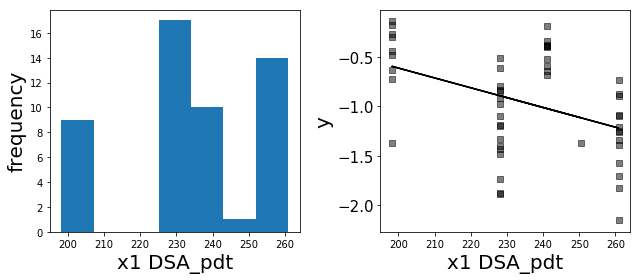

R^2 = 0.17; p-value = 2.61E-03

-------------------------------------------------------------------------------

x2 DV_pdt


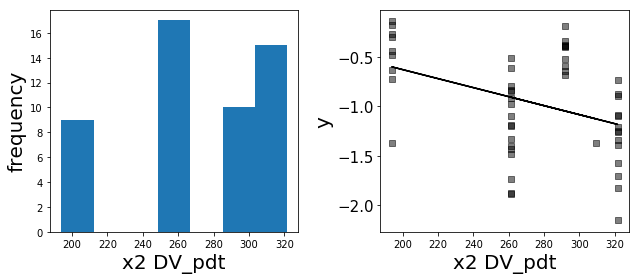

R^2 = 0.15; p-value = 5.02E-03

-------------------------------------------------------------------------------

x3 DSA_sub


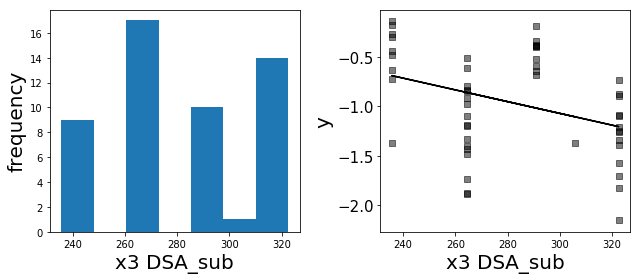

R^2 = 0.13; p-value = 9.76E-03

-------------------------------------------------------------------------------

x4 DV_sub


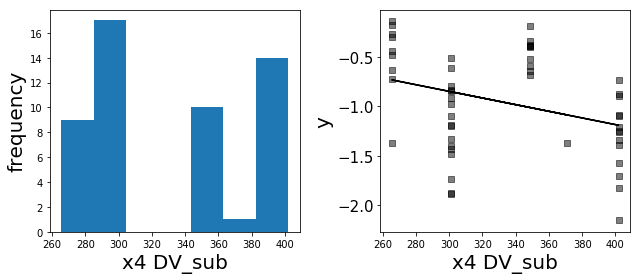

R^2 = 0.11; p-value = 0.02

-------------------------------------------------------------------------------

x5 DSA_sub-pdt


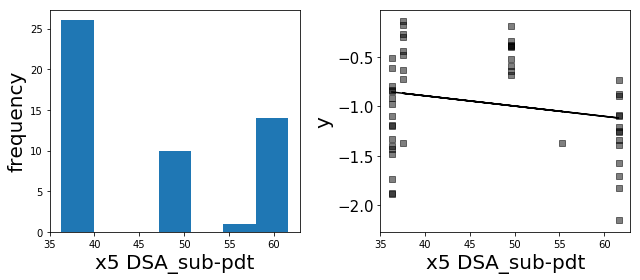

R^2 = 0.05; p-value = 0.13

-------------------------------------------------------------------------------

x6 DV_sub-pdt


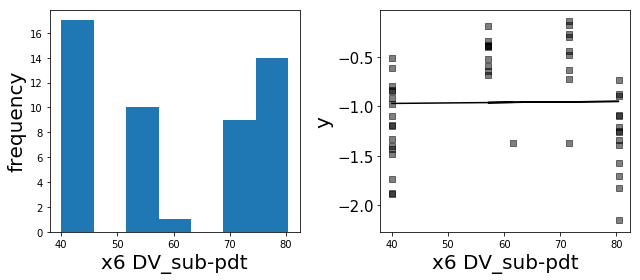

R^2 = 0.00; p-value = 0.91

-------------------------------------------------------------------------------

x7 E_pdt_BA


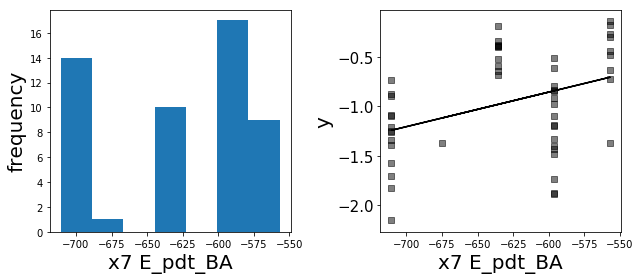

R^2 = 0.15; p-value = 5.57E-03

-------------------------------------------------------------------------------

x8 E_pdt_max


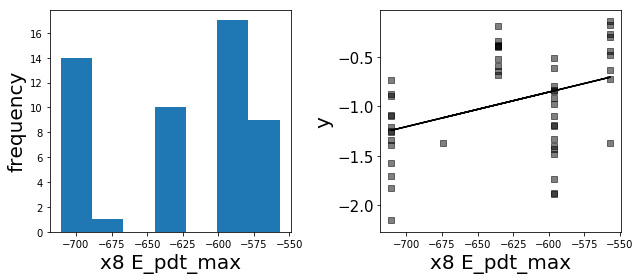

R^2 = 0.15; p-value = 5.57E-03

-------------------------------------------------------------------------------

x9 E_pdt_min


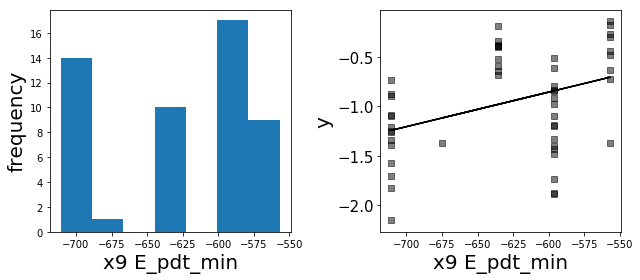

R^2 = 0.15; p-value = 5.57E-03

-------------------------------------------------------------------------------

x10 E_pdt_max-min


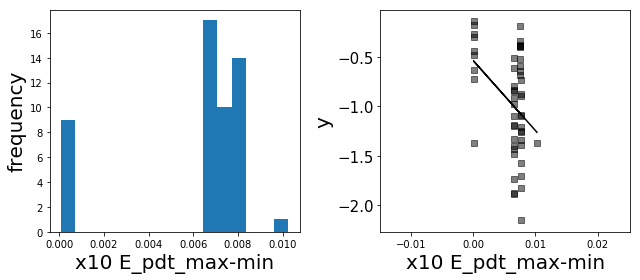

R^2 = 0.15; p-value = 4.80E-03

-------------------------------------------------------------------------------

x11 E_HOMO_pdt_BA


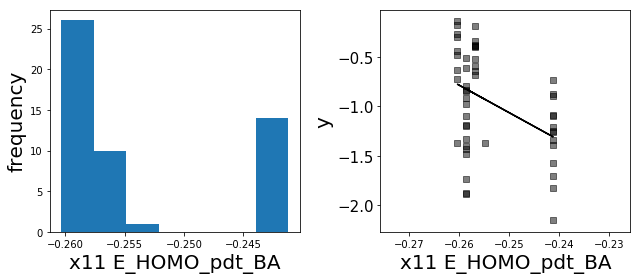

R^2 = 0.18; p-value = 2.02E-03

-------------------------------------------------------------------------------

x12 E_HOMO_pdt_max


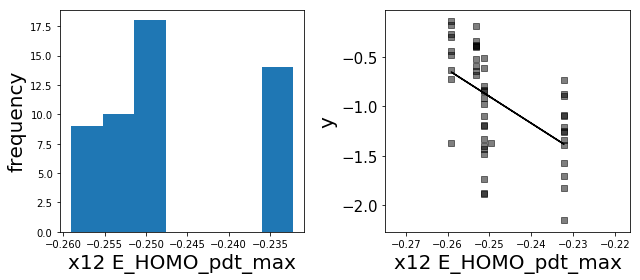

R^2 = 0.28; p-value = 7.05E-05

-------------------------------------------------------------------------------

x13 E_HOMO_pdt_min


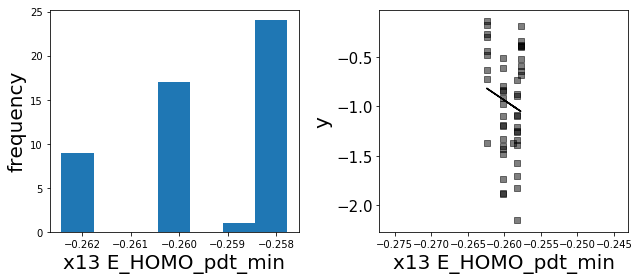

R^2 = 0.02; p-value = 0.27

-------------------------------------------------------------------------------

x14 E_HOMO_pdt_max-min


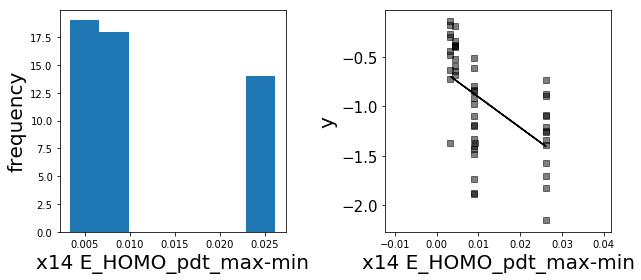

R^2 = 0.30; p-value = 2.88E-05

-------------------------------------------------------------------------------

x15 E_LUMO_pdt_BA


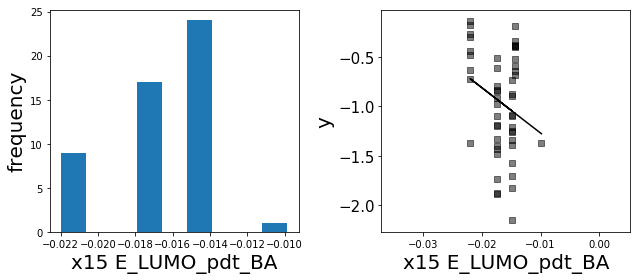

R^2 = 0.07; p-value = 0.07

-------------------------------------------------------------------------------

x16 E_LUMO_pdt_max


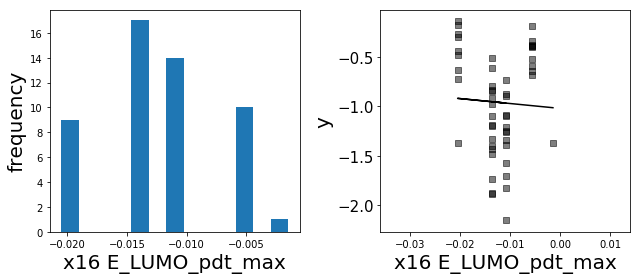

R^2 = 0.00; p-value = 0.74

-------------------------------------------------------------------------------

x17 E_LUMO_pdt_min


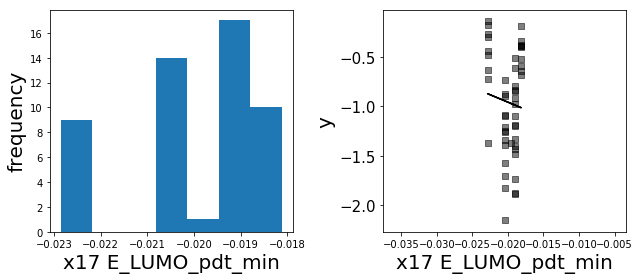

R^2 = 0.01; p-value = 0.52

-------------------------------------------------------------------------------

x18 E_LUMO_pdt_max-min


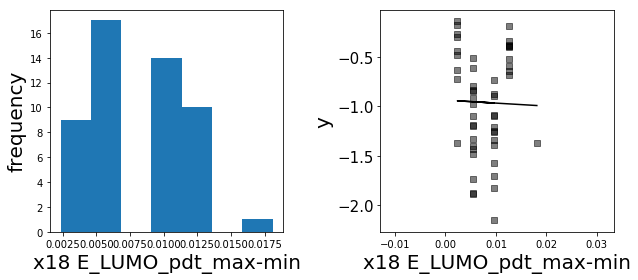

R^2 = 0.00; p-value = 0.88

-------------------------------------------------------------------------------

x19 mu_pdt_BA


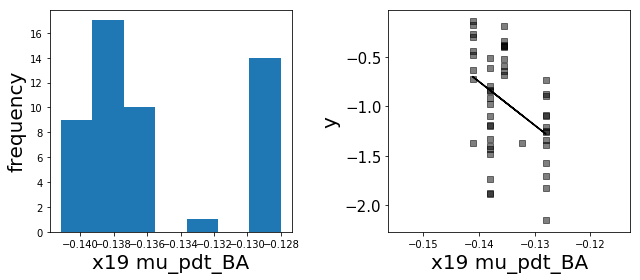

R^2 = 0.17; p-value = 2.40E-03

-------------------------------------------------------------------------------

x20 mu_pdt_max


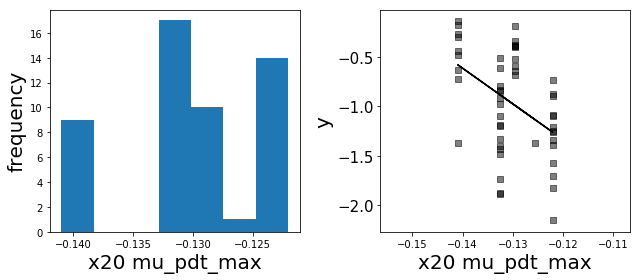

R^2 = 0.20; p-value = 9.35E-04

-------------------------------------------------------------------------------

x21 mu_pdt_min


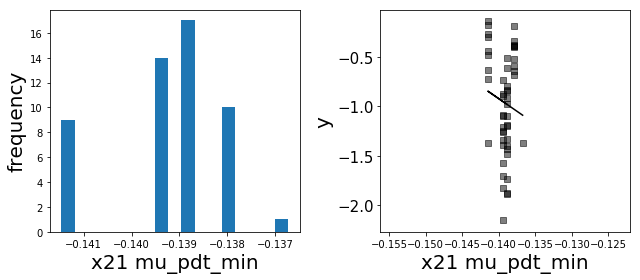

R^2 = 0.01; p-value = 0.41

-------------------------------------------------------------------------------

x22 mu_pdt_max-min


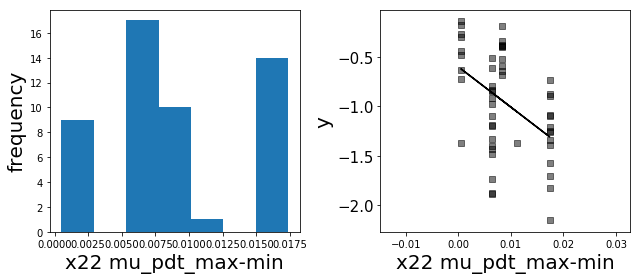

R^2 = 0.22; p-value = 5.65E-04

-------------------------------------------------------------------------------

x23 eta_pdt_BA


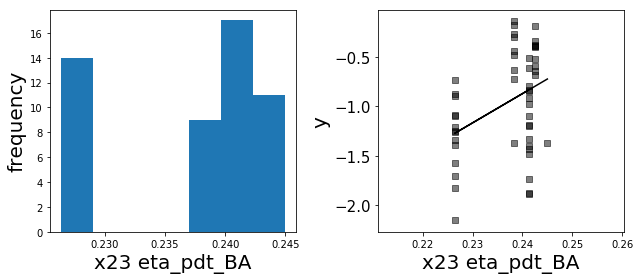

R^2 = 0.15; p-value = 5.28E-03

-------------------------------------------------------------------------------

x24 eta_pdt_max


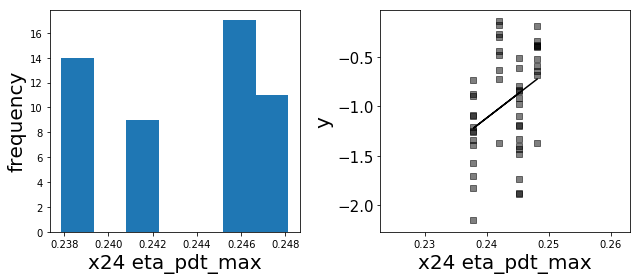

R^2 = 0.13; p-value = 9.03E-03

-------------------------------------------------------------------------------

x25 eta_pdt_min


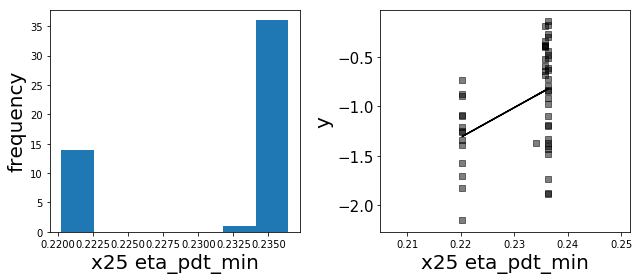

R^2 = 0.17; p-value = 2.48E-03

-------------------------------------------------------------------------------

x26 eta_pdt_max-min


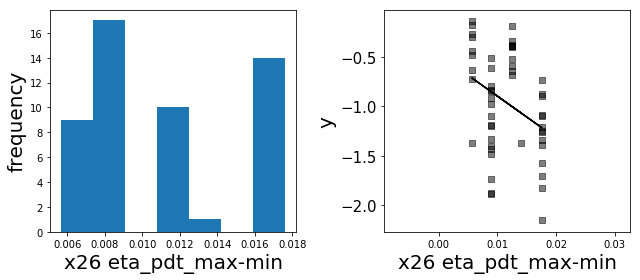

R^2 = 0.13; p-value = 0.01

-------------------------------------------------------------------------------

x27 omega_pdt_BA


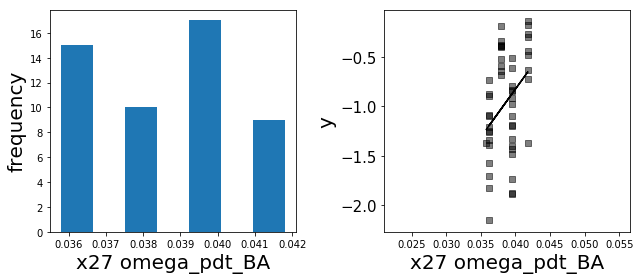

R^2 = 0.14; p-value = 6.85E-03

-------------------------------------------------------------------------------

x28 omega_pdt_max


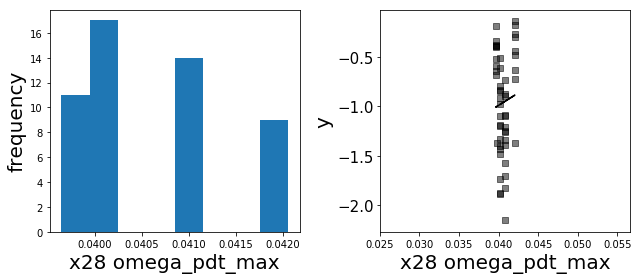

R^2 = 0.01; p-value = 0.59

-------------------------------------------------------------------------------

x29 omega_pdt_min


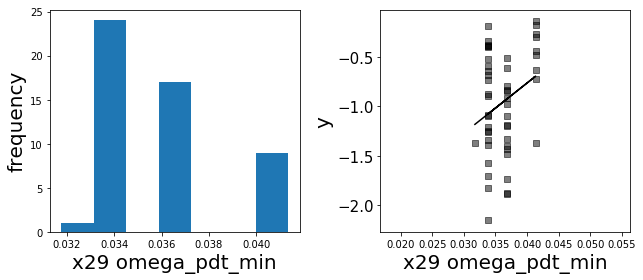

R^2 = 0.08; p-value = 0.05

-------------------------------------------------------------------------------

x30 omega_pdt_max-min


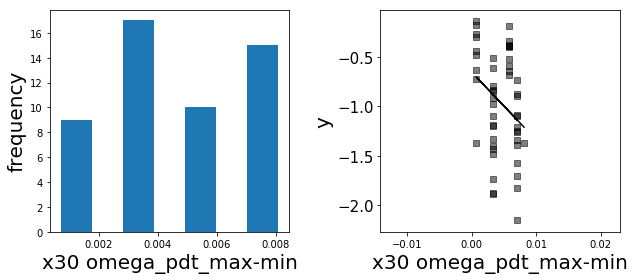

R^2 = 0.10; p-value = 0.03

-------------------------------------------------------------------------------

x31 dipole_pdt_BA


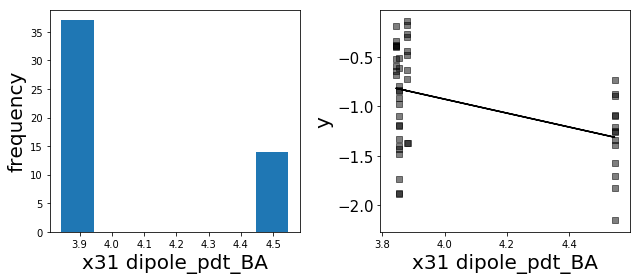

R^2 = 0.18; p-value = 1.98E-03

-------------------------------------------------------------------------------

x32 dipole_pdt_max


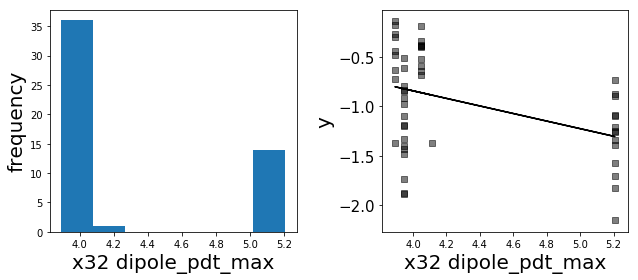

R^2 = 0.17; p-value = 2.45E-03

-------------------------------------------------------------------------------

x33 dipole_pdt_min


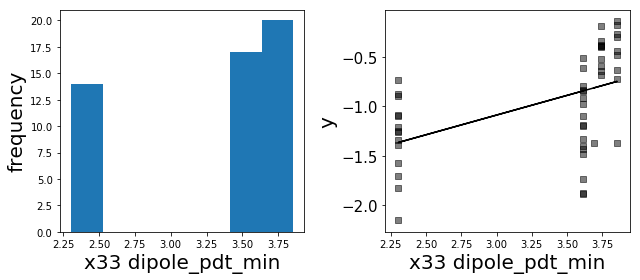

R^2 = 0.24; p-value = 2.53E-04

-------------------------------------------------------------------------------

x34 dipole_pdt


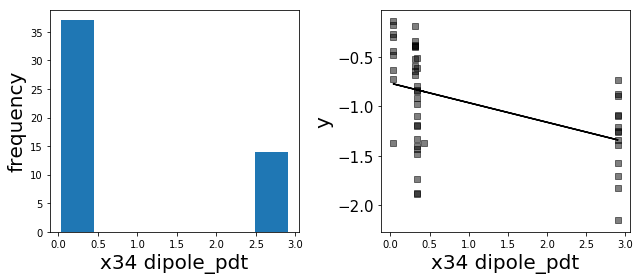

R^2 = 0.21; p-value = 7.53E-04

-------------------------------------------------------------------------------

x35 NBO_N_sub_pdt_BA


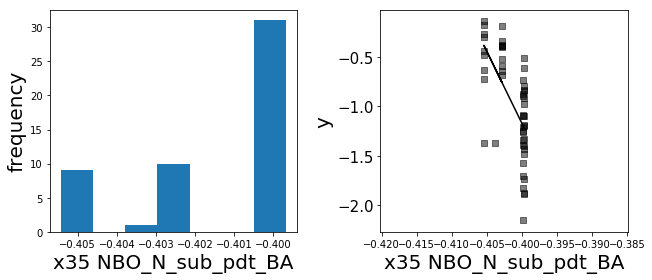

R^2 = 0.40; p-value = 5.91E-07

-------------------------------------------------------------------------------

x36 NBO_N_sub_pdt_max


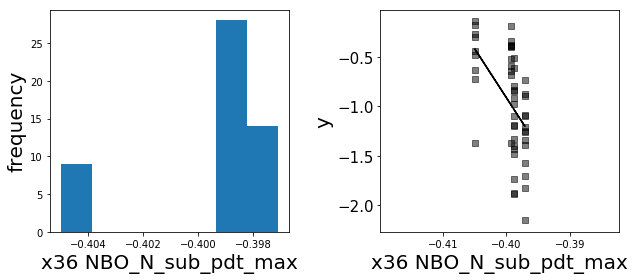

R^2 = 0.26; p-value = 1.12E-04

-------------------------------------------------------------------------------

x37 NBO_N_sub_pdt_min


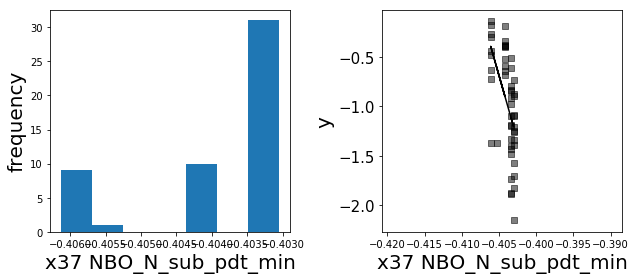

R^2 = 0.32; p-value = 1.34E-05

-------------------------------------------------------------------------------

x38 NBO_N_sub_pdt_max-min


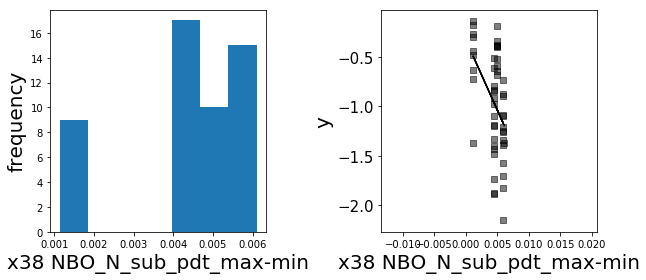

R^2 = 0.20; p-value = 8.50E-04

-------------------------------------------------------------------------------

x39 NBO_N_pdt_BA


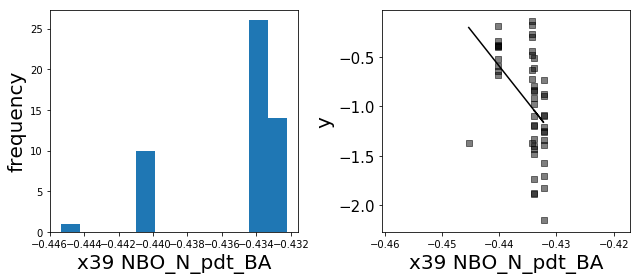

R^2 = 0.21; p-value = 7.91E-04

-------------------------------------------------------------------------------

x40 NBO_N_pdt_max


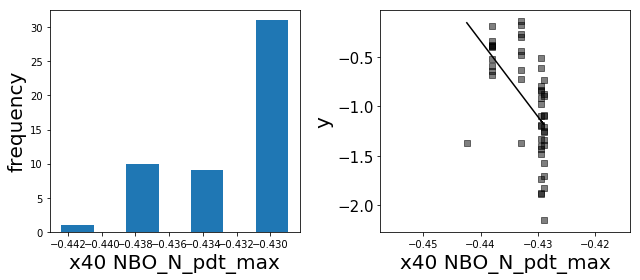

R^2 = 0.31; p-value = 1.97E-05

-------------------------------------------------------------------------------

x41 NBO_N_pdt_min


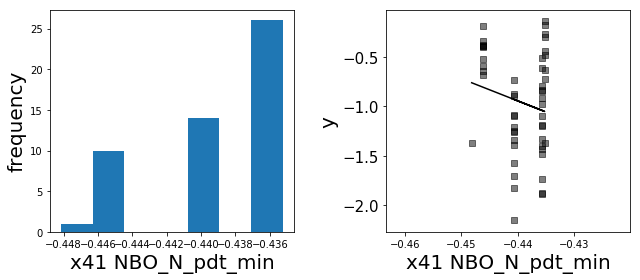

R^2 = 0.04; p-value = 0.18

-------------------------------------------------------------------------------

x42 NBO_N_pdt_max-min


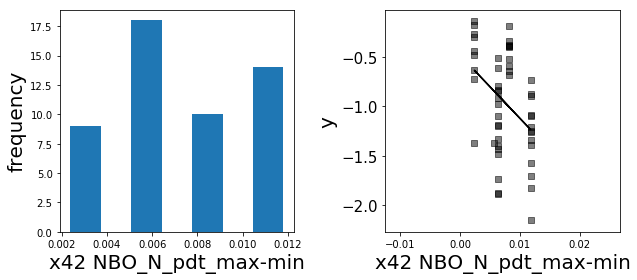

R^2 = 0.16; p-value = 3.67E-03

-------------------------------------------------------------------------------

x43 NBO_carbonyl_C_pdt_BA


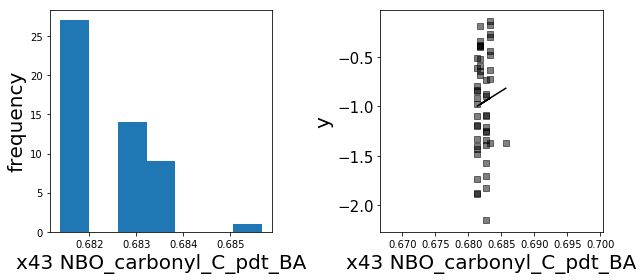

R^2 = 0.01; p-value = 0.62

-------------------------------------------------------------------------------

x44 NBO_carbonyl_C_pdt_max


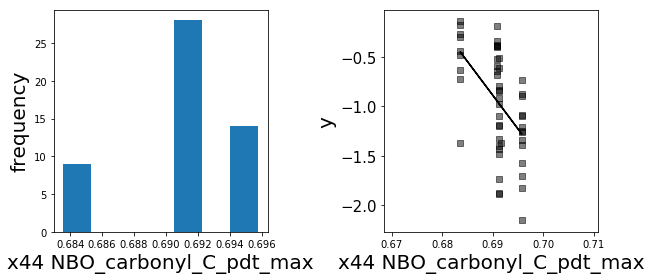

R^2 = 0.28; p-value = 6.03E-05

-------------------------------------------------------------------------------

x45 NBO_carbonyl_C_pdt_min


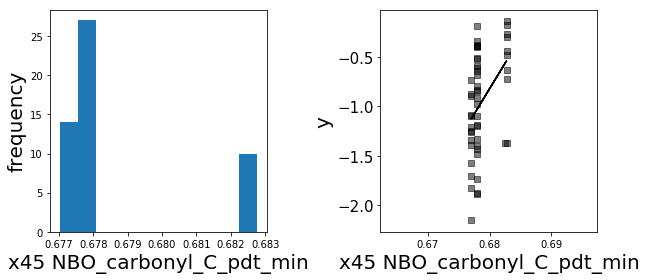

R^2 = 0.17; p-value = 2.73E-03

-------------------------------------------------------------------------------

x46 NBO_carbonyl_C_pdt_max-min


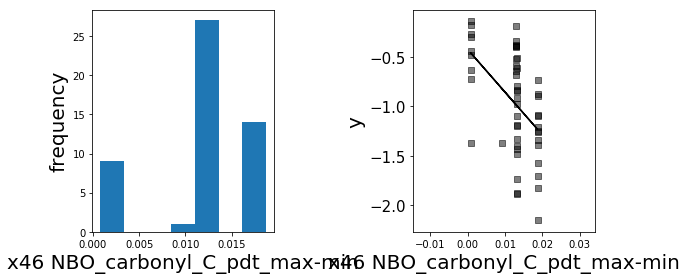

R^2 = 0.25; p-value = 1.86E-04

-------------------------------------------------------------------------------

x47 NBO_carbonyl_O_pdt_BA


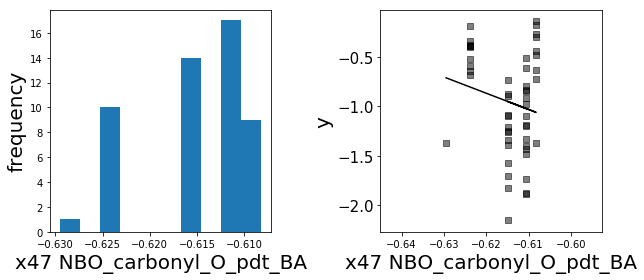

R^2 = 0.03; p-value = 0.19

-------------------------------------------------------------------------------

x48 NBO_carbonyl_O_pdt_max


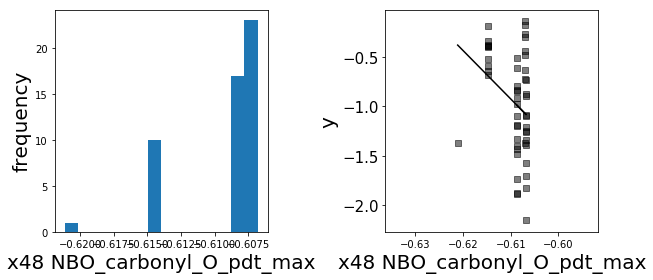

R^2 = 0.10; p-value = 0.02

-------------------------------------------------------------------------------

x49 NBO_carbonyl_O_pdt_min


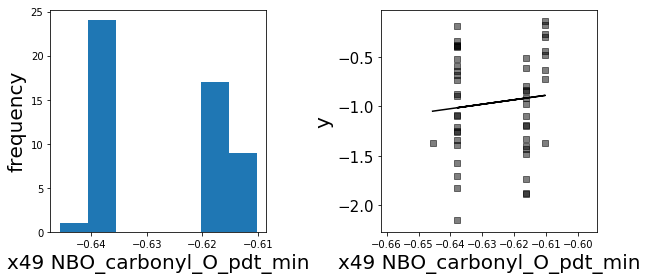

R^2 = 0.01; p-value = 0.45

-------------------------------------------------------------------------------

x50 NBO_carbonyl_O_pdt_max-min


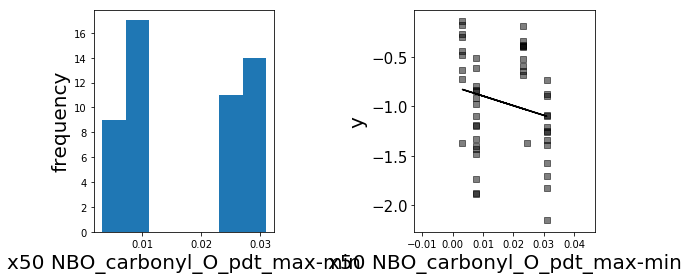

R^2 = 0.05; p-value = 0.13

-------------------------------------------------------------------------------

x51 NBO_alpha_C_pdt_BA


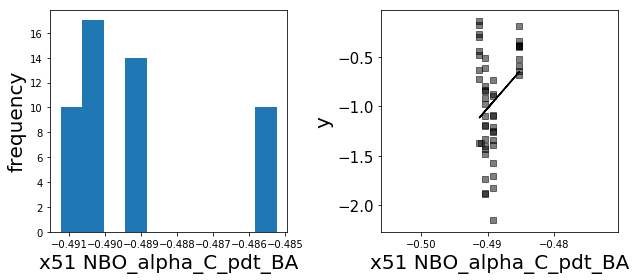

R^2 = 0.10; p-value = 0.02

-------------------------------------------------------------------------------

x52 NBO_alpha_C_pdt_max


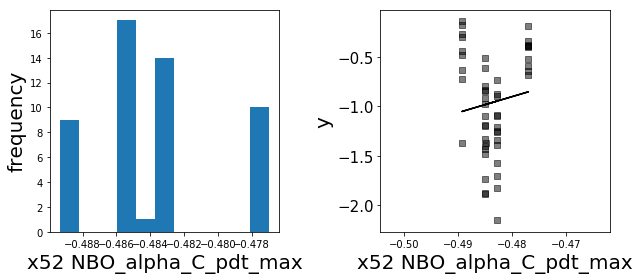

R^2 = 0.02; p-value = 0.39

-------------------------------------------------------------------------------

x53 NBO_alpha_C_pdt_min


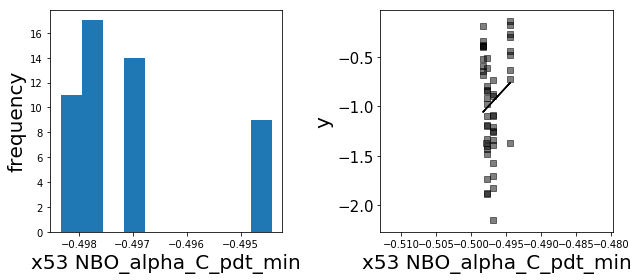

R^2 = 0.04; p-value = 0.17

-------------------------------------------------------------------------------

x54 NBO_alpha_C_pdt_max-min


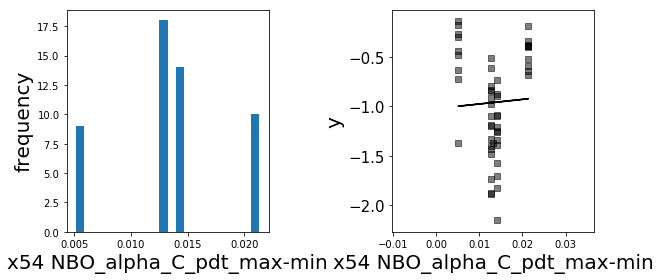

R^2 = 0.00; p-value = 0.75

-------------------------------------------------------------------------------

x55 NBO_beta_C_pdt_BA


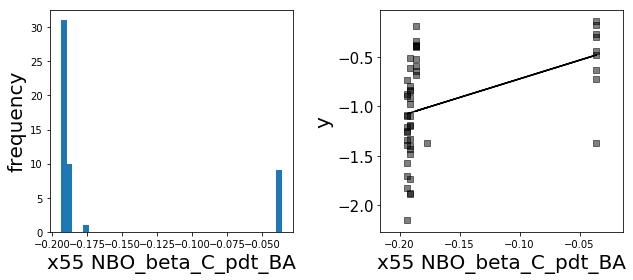

R^2 = 0.19; p-value = 1.47E-03

-------------------------------------------------------------------------------

x56 NBO_beta_C_pdt_max


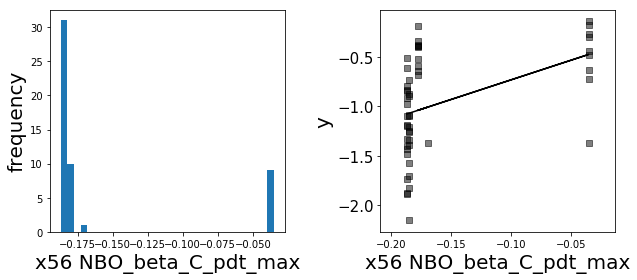

R^2 = 0.19; p-value = 1.27E-03

-------------------------------------------------------------------------------

x57 NBO_beta_C_pdt_min


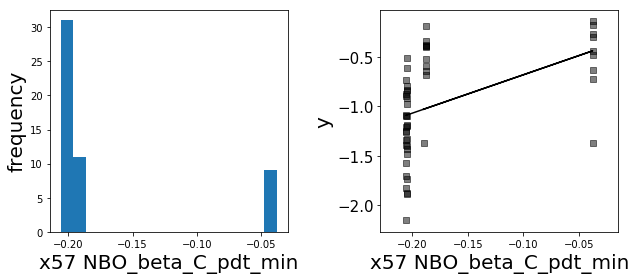

R^2 = 0.22; p-value = 4.43E-04

-------------------------------------------------------------------------------

x58 NBO_beta_C_pdt_max-min


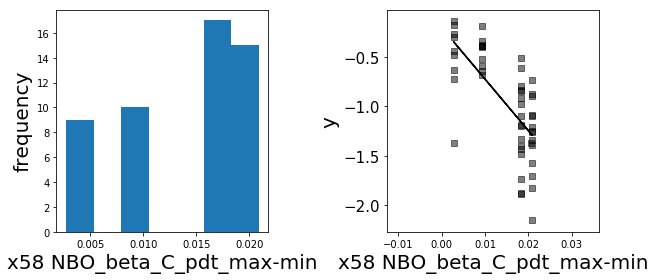

R^2 = 0.48; p-value = 1.89E-08

-------------------------------------------------------------------------------

x59 NBO_large_substit_pdt_BA


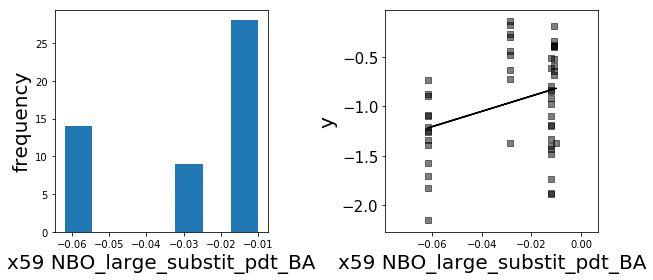

R^2 = 0.11; p-value = 0.02

-------------------------------------------------------------------------------

x60 NBO_large_substit_pdt_max


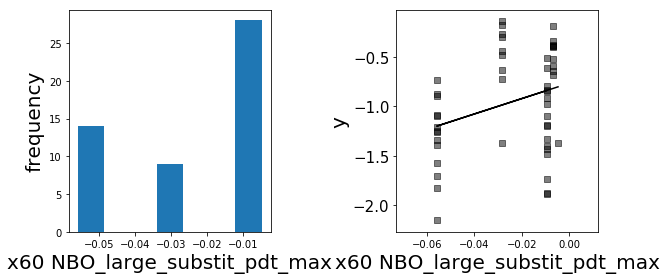

R^2 = 0.10; p-value = 0.03

-------------------------------------------------------------------------------

x61 NBO_large_substit_pdt_min


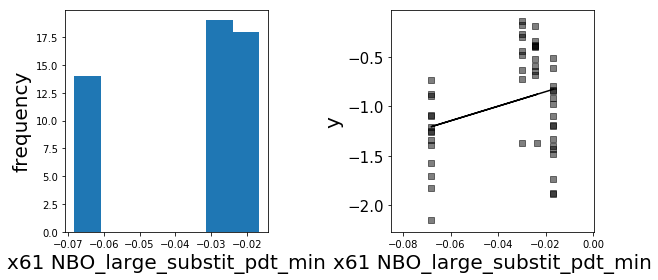

R^2 = 0.09; p-value = 0.03

-------------------------------------------------------------------------------

x62 NBO_large_substit_pdt


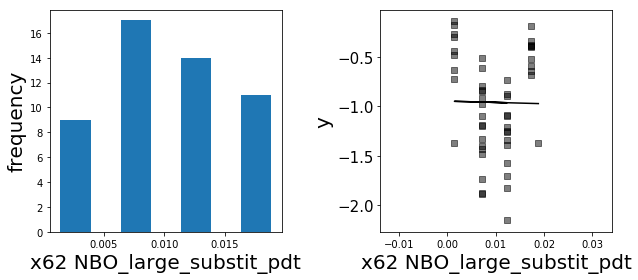

R^2 = 0.00; p-value = 0.92

-------------------------------------------------------------------------------

x63 NBO_beta_H_pdt_BA


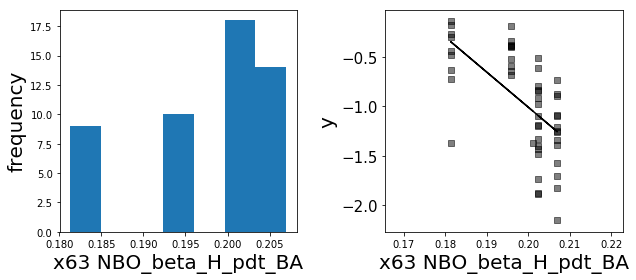

R^2 = 0.38; p-value = 1.73E-06

-------------------------------------------------------------------------------

x64 NBO_beta_H_pdt_max


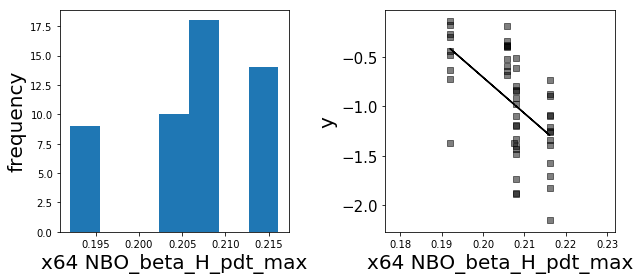

R^2 = 0.32; p-value = 1.64E-05

-------------------------------------------------------------------------------

x65 NBO_beta_H_pdt_min


KeyboardInterrupt: 

In [13]:
# original data
# Visualize Histograms and univariate correlations for all (or selected) features
features = range(np.shape(X)[1])   # iterate over all features
# examples for selecting features
#specify names:
# features = [x_names.index("sterimol_5-.5cB5_max")]
#specify x-numbers (1-indexed):
#features_x = ["x139","x140","x141","x142","x143","x144","x145","x146","x147","x148","x149","x150","x151","x152","x153","x154","x155","x156","x157","x158","x159","x160","x161","x162","x163"]
#features = [X_labels.index(i) for i in features_x]
#specify ranges (0-indexed)
#features = itertools.chain(range(15,92)) #480,2611)) #312,343)) 

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    
    plt.figure(figsize=(9, 4))
    
    plt.subplot(1,2,1)
    plt.hist(X[:,f_ind], bins="auto")
    plt.ylabel("frequency",fontsize=20)
    plt.xlabel(feature + " " + X_names[f_ind],fontsize=20)
    
    plt.subplot(1,2,2)
    plt.scatter(X[:,f_ind], y,color="black",marker="s",alpha=0.5)    
    plt.plot(X[:,f_ind],fit_line,color="black")
    plt.xlabel(feature + " " + X_names[f_ind],fontsize=20)
    plt.ylabel("y",fontsize=20) # "$ΔΔG^{≠}$"  "Yield"

#     plt.xticks(np.arange(round(min(X[:,f_ind])-0.005,3), round(max(X[:,f_ind])+0.005,3), 0.03),fontsize=15)
    plt.yticks(fontsize=15)        
    plt.tight_layout()
    plt.show()    

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")
    
  

### Seaborn

x80 dynam_SA_66


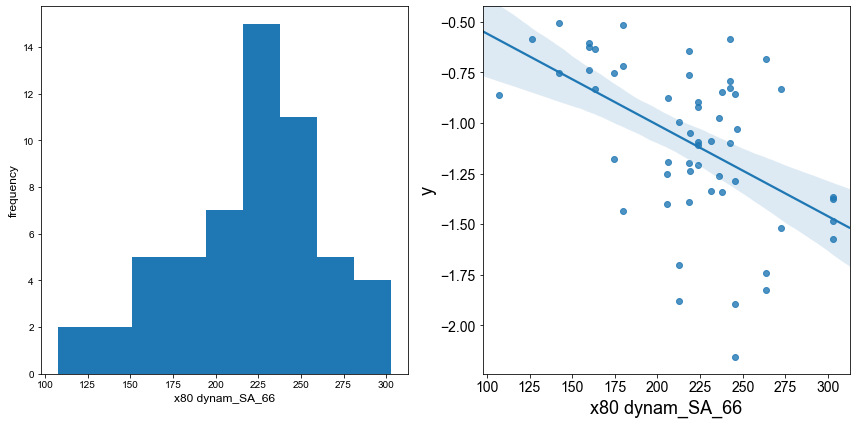

R^2 = 0.26; p-value = 6.96E-05

--------------------------------------------------------------------------------------------------------------------------

x92 dynam_vol_66


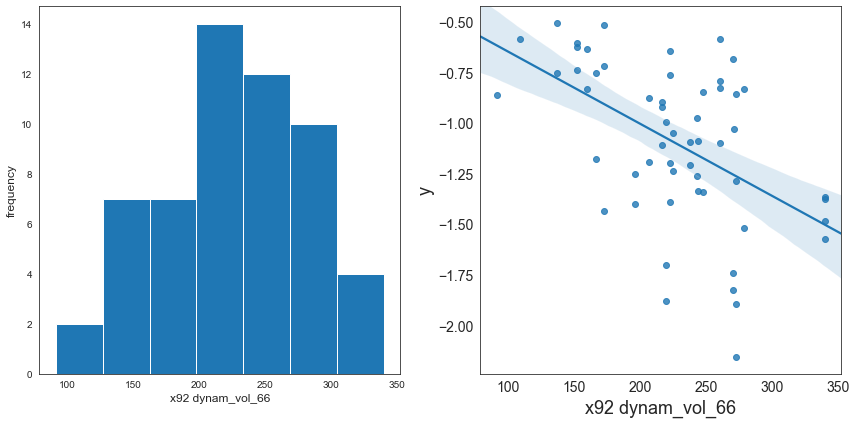

R^2 = 0.26; p-value = 6.07E-05

--------------------------------------------------------------------------------------------------------------------------

x159 66_B5_MD_wt


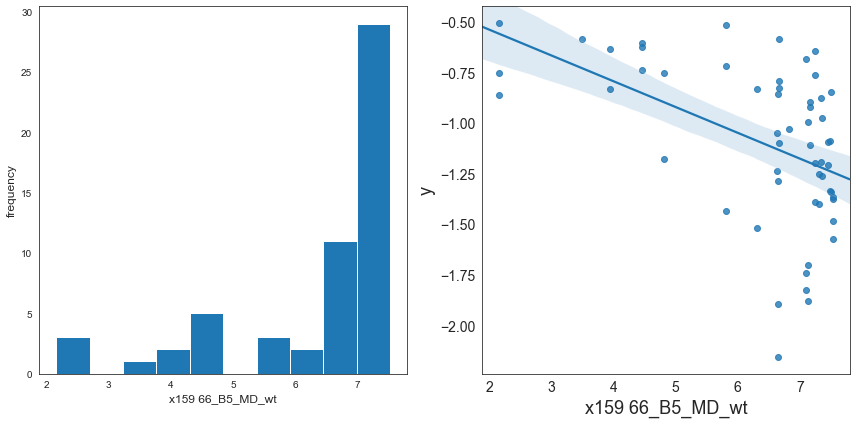

R^2 = 0.23; p-value = 2.12E-04

--------------------------------------------------------------------------------------------------------------------------

x160 66_B5_max


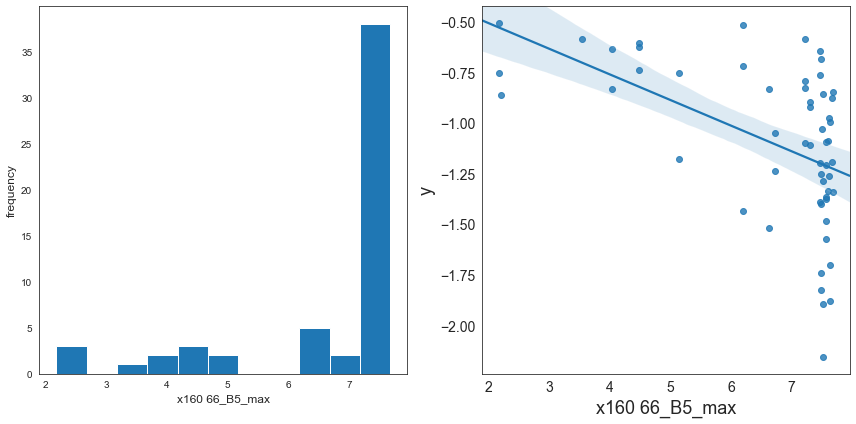

R^2 = 0.25; p-value = 9.12E-05

--------------------------------------------------------------------------------------------------------------------------

x161 66_B5_min


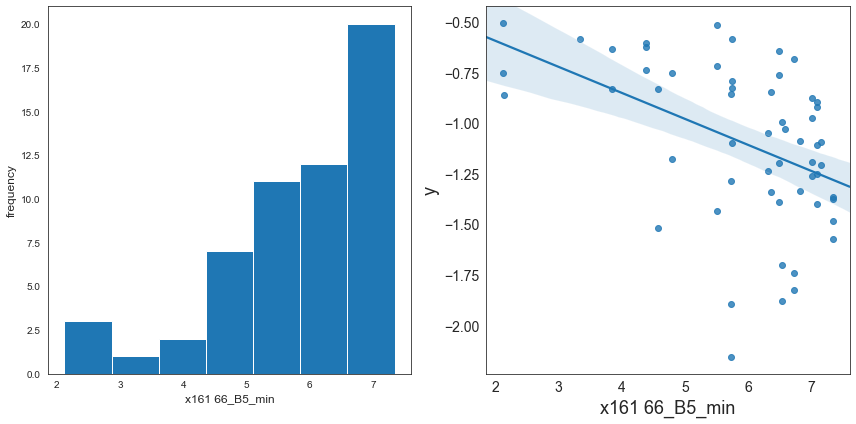

R^2 = 0.20; p-value = 5.38E-04

--------------------------------------------------------------------------------------------------------------------------

x589 N_lg_sterimol_B5_sub_min


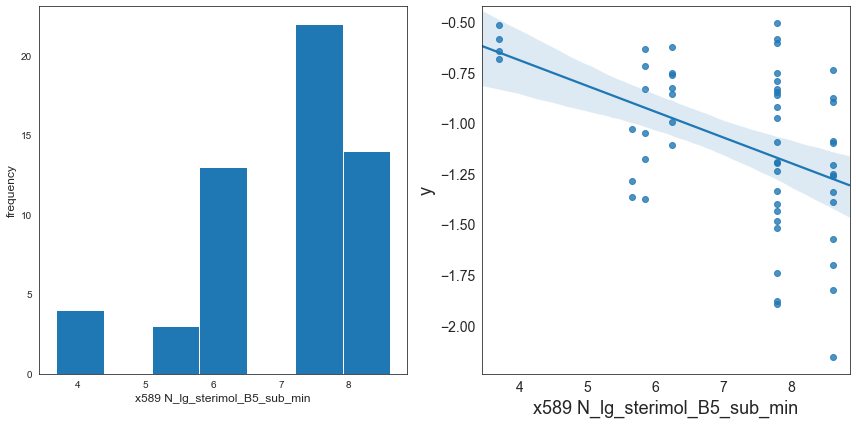

R^2 = 0.21; p-value = 4.02E-04

--------------------------------------------------------------------------------------------------------------------------

x603 dynam_SA_66_100


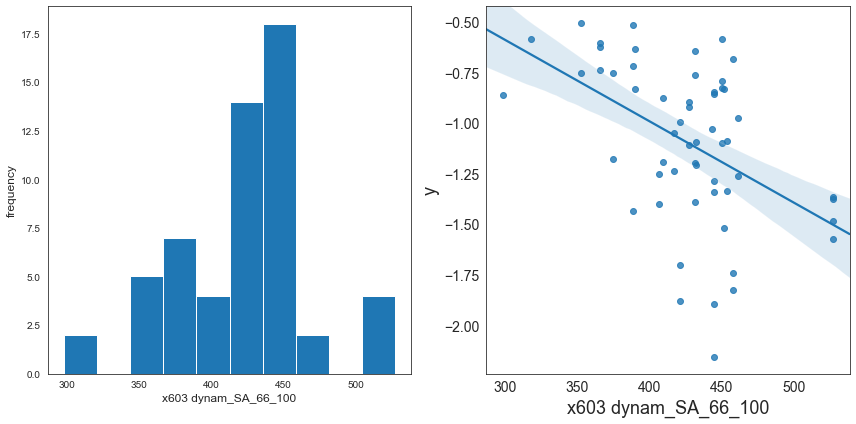

R^2 = 0.22; p-value = 2.27E-04

--------------------------------------------------------------------------------------------------------------------------

x604 dynam_SA_100_177


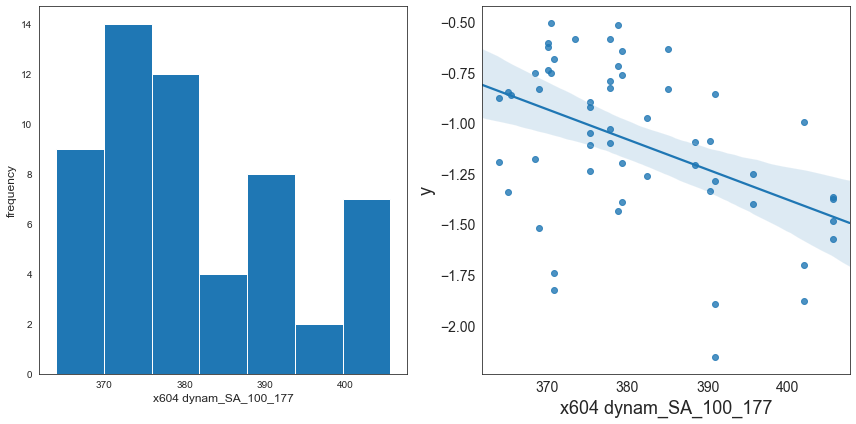

R^2 = 0.21; p-value = 3.83E-04

--------------------------------------------------------------------------------------------------------------------------

x605 dynam_SA_66_100_177


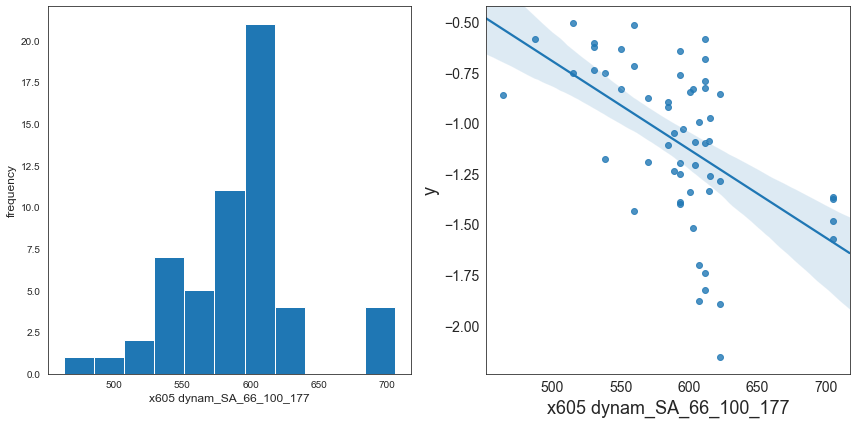

R^2 = 0.28; p-value = 2.48E-05

--------------------------------------------------------------------------------------------------------------------------

x609 dynam_vol_66_100_177


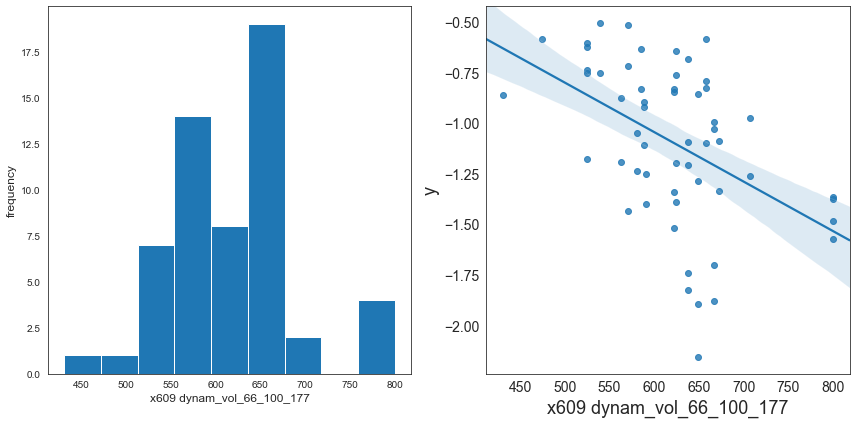

R^2 = 0.22; p-value = 2.75E-04

--------------------------------------------------------------------------------------------------------------------------



In [11]:
# has option to only print univariate correlations if they meet an R^2 cutoff

### All features:
features = range(np.shape(X)[1])
### Features by X-numbers (1-indexed):
#features_x = ["x1","x19","x20","x31","x120","x145","x160"]
#features_x = ["x231"]
#features = [X_labels.index(i) for i in features_x]
### Feature by range (0-indexed):
# features = itertools.chain(range(75,85),range(90,95))

#set r2 cutoff
r2_cutoff = 0.2
r2_values = []

for f_ind in features:
    feature = X_labels[f_ind]
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    r2 = r_value**2
    r2_values.append(r2)
    if r2 >= r2_cutoff:
        print(feature, X_names[f_ind])
        plt.figure(figsize=(12, 6))
        plt.subplot(1,2,1)
        plt.hist(X[:,f_ind], bins="auto")
        plt.ylabel("frequency",fontsize=12)
        plt.xlabel(feature + " " + X_names[f_ind],fontsize=12)
        plt.tight_layout()
        plt.subplot(1,2,2)
        sns.set_style("white")
        sns.regplot(X[:,f_ind],y,ci=95,truncate=False)
        x_max=np.max(X[:,f_ind])
        x_min=np.min(X[:,f_ind])
        y_max=np.max(y)
        y_min=np.min(y)
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
        #plt.scatter(X[:,f_ind], y,color="black",marker=".",alpha=0.5,s=150)
        #plt.plot(X[:,f_ind],fit_line,color="black")
        plt.xlabel(feature + " " + X_names[f_ind],fontsize=18)
        plt.ylabel("y",fontsize=18)  # "$ΔΔG^{≠}$"  "Yield"
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        
        #toggle these two lines to either show or show and save the plots
        plt.show()
        #plt.savefig("plotname.png",dpi=300)
        
        if p_value > 0.01:
            print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
        else:
            print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
        print("\n--------------------------------------------------------------------------------------------------------------------------\n")

## plot a feature vs. another feature

x171 100_angle_2_MD_wt
x71 substit_sterimol_B1_pdt_BA

51 samples
R^2 = 0.02; p-value = 2.71E-01


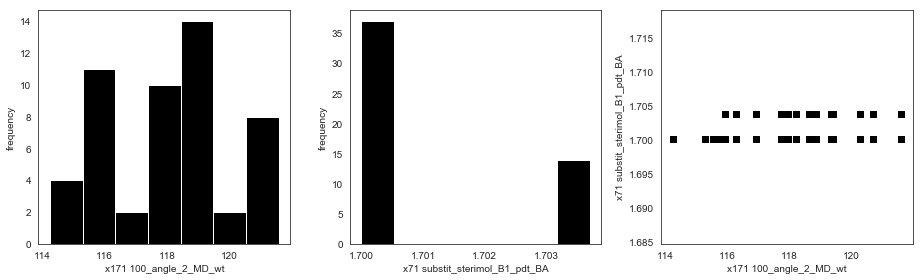

In [18]:
# one comparison plot at a time

# select two features to visualize
# can be integer-index of features, or string with x-number
f_ind_1 = "x171"
f_ind_2 = "x71"

if type(f_ind_1) == str:
    [f_ind_1,f_ind_2] = [X_labels.index(i) for i in [f_ind_1,f_ind_2]]

print(X_labels[f_ind_1], X_names[f_ind_1])
print(X_labels[f_ind_2], X_names[f_ind_2])
print("\n{} samples".format(np.shape(X[:,f_ind_1])[0]))
slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind_1],X[:,f_ind_2])
fit_line = intercept+slope*X[:,f_ind_1]
print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

plt.figure(figsize=(13, 4))

plt.subplot(1,3,1)
plt.hist(X[:,f_ind_1], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_labels[f_ind_1] + " " + X_names[f_ind_1])
plt.subplot(1,3,2)
plt.hist(X[:,f_ind_2], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_labels[f_ind_2] + " " + X_names[f_ind_2])

plt.subplot(1,3,3)
plt.scatter(X[:,f_ind_1], X[:,f_ind_2],color="black",marker="s")    
#plt.plot(X[:,f_ind_1],fit_line)
plt.xlabel(X_labels[f_ind_1] + " " + X_names[f_ind_1])
plt.ylabel(X_labels[f_ind_2] + " " + X_names[f_ind_2])
plt.tight_layout()
plt.show()    

x49 nbo_N_oxamide_max
x150 ir_NH_freq_boltz

34 samples
R^2 = 0.02; p-value = 4.47E-01

---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x151 ir_NH_int_minE

34 samples
R^2 = 0.03; p-value = 3.11E-01

---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x152 ir_NH_int_min

34 samples
R^2 = 0.05; p-value = 1.91E-01


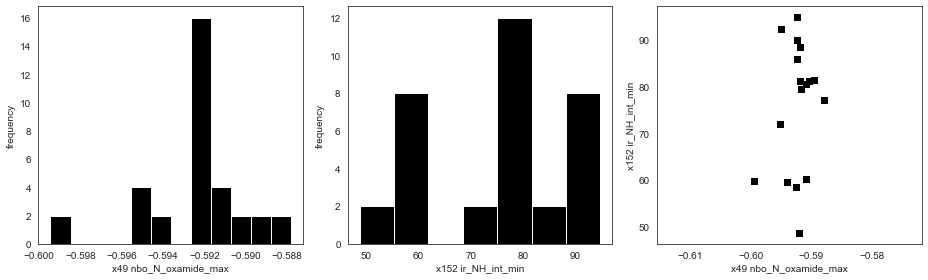


---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x153 ir_NH_int_max

34 samples
R^2 = 0.04; p-value = 2.66E-01

---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x154 ir_NH_int_boltz

34 samples
R^2 = 0.08; p-value = 1.09E-01


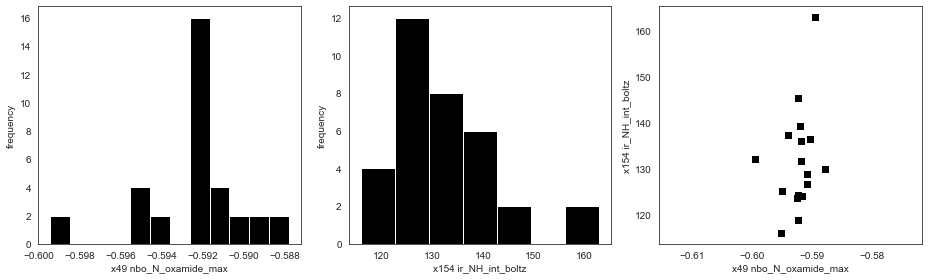


---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x155 sterimol_NC_L_minE

34 samples
R^2 = 0.21; p-value = 6.78E-03


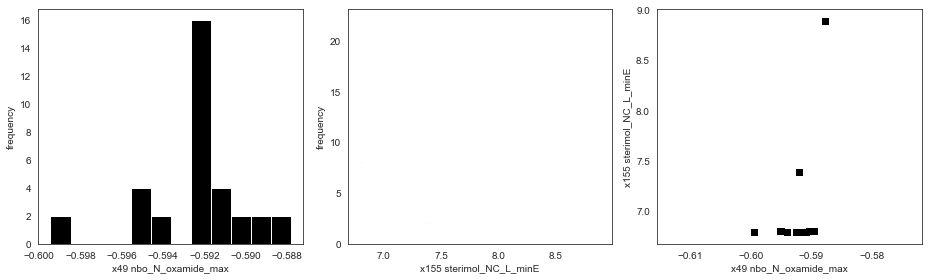


---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x156 sterimol_NC_L_min

34 samples
R^2 = 0.21; p-value = 6.99E-03


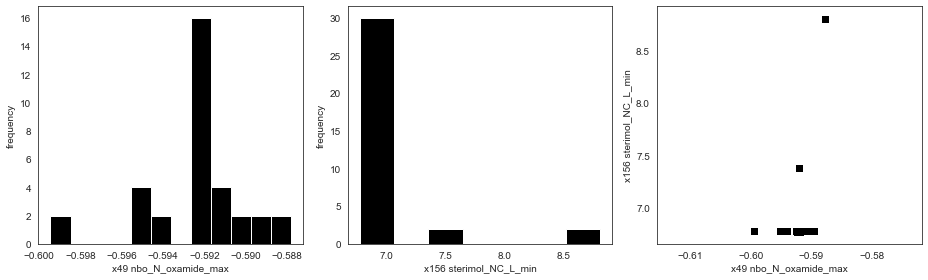


---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x157 sterimol_NC_L_max

34 samples
R^2 = 0.05; p-value = 2.13E-01


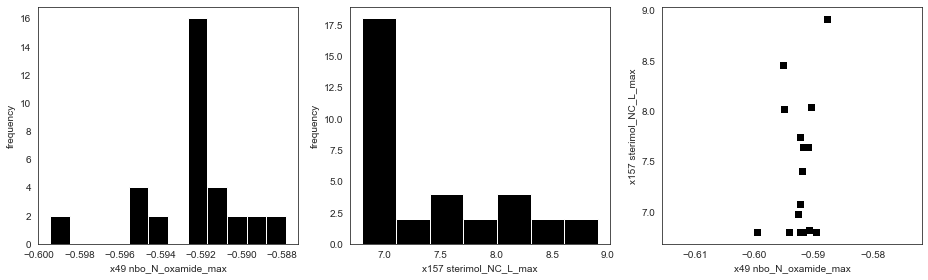


---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x158 sterimol_NC_L_boltz

34 samples
R^2 = 0.21; p-value = 6.97E-03


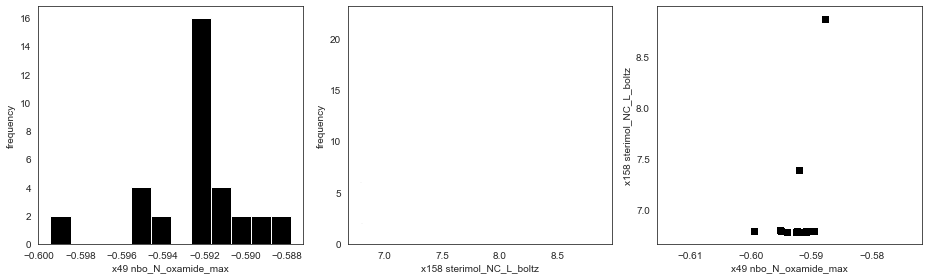


---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x159 sterimol_NC_B1_minE

34 samples
R^2 = 0.25; p-value = 2.62E-03

---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x160 sterimol_NC_B1_min

34 samples
R^2 = 0.21; p-value = 6.19E-03

---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x161 sterimol_NC_B1_max

34 samples
R^2 = 0.01; p-value = 5.06E-01

---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x162 sterimol_NC_B1_boltz

34 samples
R^2 = 0.12; p-value = 4.44E-02

---------------------------------------------------------------------------------------------------------------

x49 nbo_N_oxamide_max
x163 sterimol_NC_B5_minE

34 samples
R^2 = 0.02; 

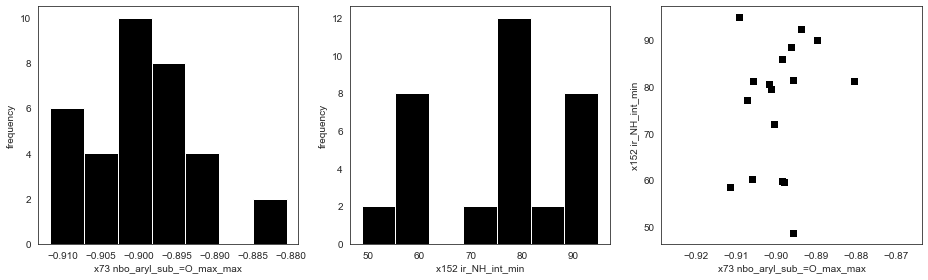


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x153 ir_NH_int_max

34 samples
R^2 = 0.29; p-value = 9.56E-04


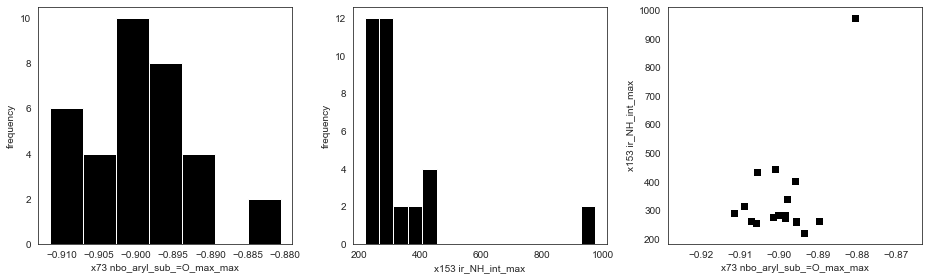


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x154 ir_NH_int_boltz

34 samples
R^2 = 0.07; p-value = 1.38E-01


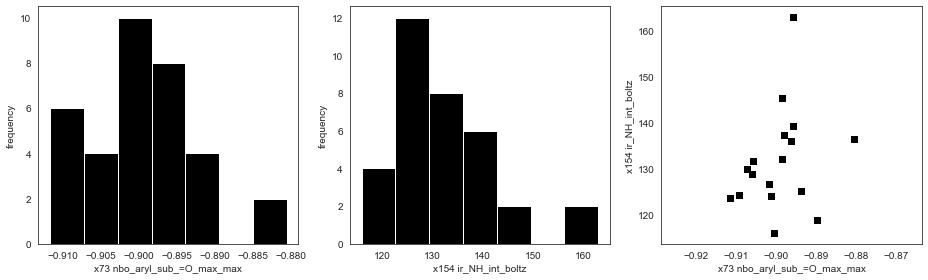


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x155 sterimol_NC_L_minE

34 samples
R^2 = 0.05; p-value = 2.03E-01

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x156 sterimol_NC_L_min

34 samples
R^2 = 0.05; p-value = 1.97E-01

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x157 sterimol_NC_L_max

34 samples
R^2 = 0.02; p-value = 4.43E-01

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x158 sterimol_NC_L_boltz

34 samples
R^2 = 0.05; p-value = 2.04E-01

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x159 sterimol_NC_B1_min

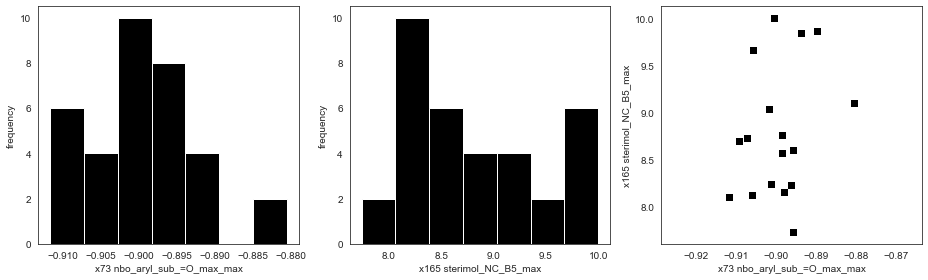


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x166 sterimol_NC_B5_boltz

34 samples
R^2 = 0.20; p-value = 7.43E-03

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x167 sterimol_CS_L_minE

34 samples
R^2 = 0.22; p-value = 5.03E-03

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x168 sterimol_CS_L_min

34 samples
R^2 = 0.03; p-value = 2.95E-01

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x169 sterimol_CS_L_max

34 samples
R^2 = 0.12; p-value = 4.21E-02


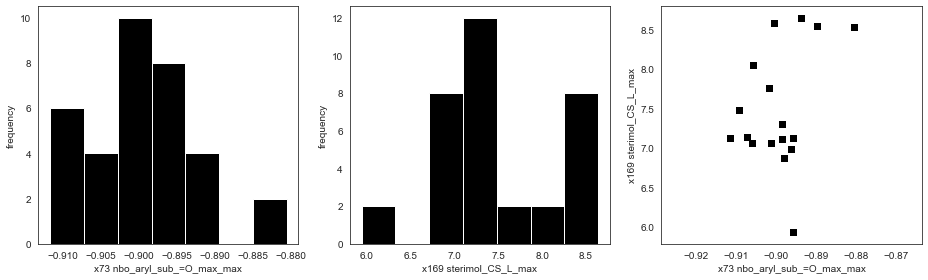


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x170 sterimol_CS_L_boltz

34 samples
R^2 = 0.15; p-value = 2.33E-02

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x171 sterimol_CS_B1_minE

34 samples
R^2 = 0.22; p-value = 5.36E-03

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x172 sterimol_CS_B1_min

34 samples
R^2 = 0.22; p-value = 4.96E-03

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x173 sterimol_CS_B1_max

34 samples
R^2 = 0.40; p-value = 6.65E-05

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x174 sterimol_CS_B1_

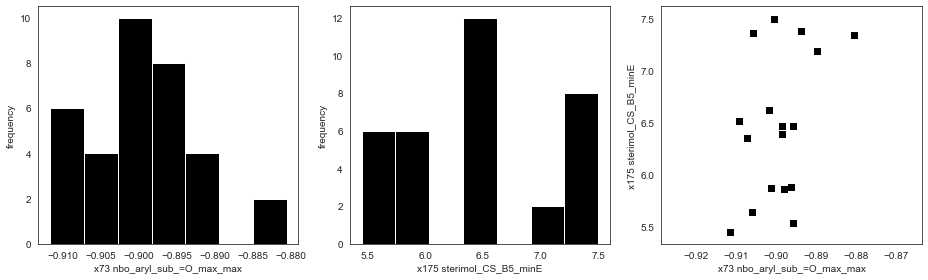


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x176 sterimol_CS_B5_min

34 samples
R^2 = 0.01; p-value = 5.42E-01

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x177 sterimol_CS_B5_max

34 samples
R^2 = 0.12; p-value = 4.91E-02


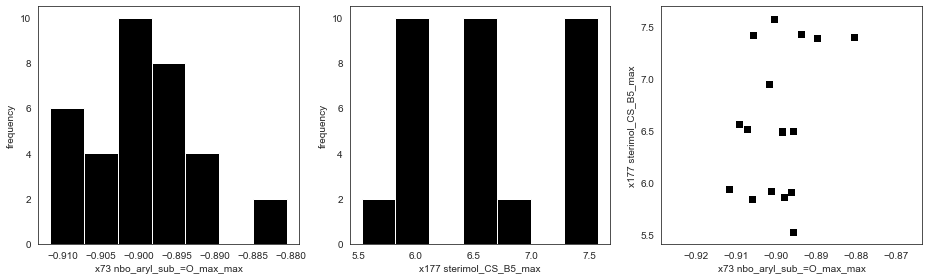


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x178 sterimol_CS_B5_boltz

34 samples
R^2 = 0.19; p-value = 1.03E-02


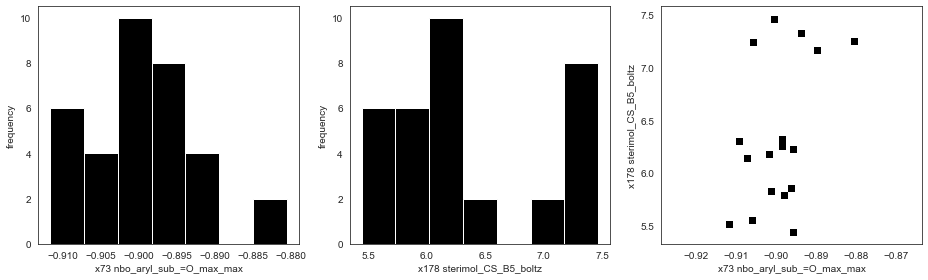


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x179 sterimol_SN_L_minE

34 samples
R^2 = 0.12; p-value = 4.17E-02

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x180 sterimol_SN_L_min

34 samples
R^2 = 0.10; p-value = 7.54E-02


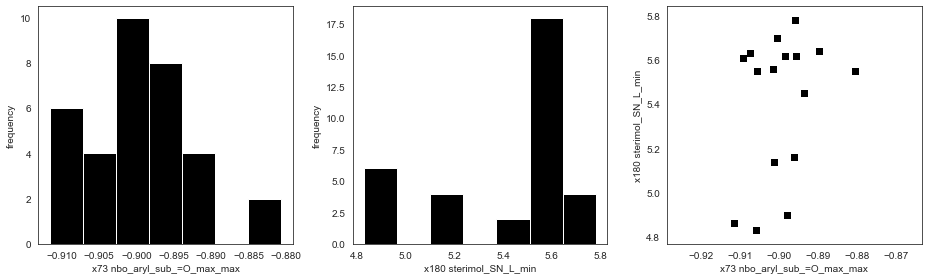


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x181 sterimol_SN_L_max

34 samples
R^2 = 0.00; p-value = 7.89E-01

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x182 sterimol_SN_L_boltz

34 samples
R^2 = 0.09; p-value = 8.92E-02

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x183 sterimol_SN_B1_minE

34 samples
R^2 = 0.13; p-value = 3.89E-02

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x184 sterimol_SN_B1_min

34 samples
R^2 = 0.07; p-value = 1.29E-01


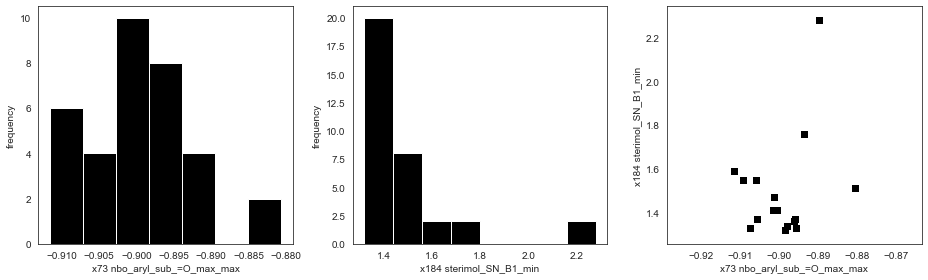


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x185 sterimol_SN_B1_max

34 samples
R^2 = 0.11; p-value = 5.19E-02

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x186 sterimol_SN_B1_boltz

34 samples
R^2 = 0.06; p-value = 1.61E-01

---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x187 sterimol_SN_B5_minE

34 samples
R^2 = 0.15; p-value = 2.40E-02


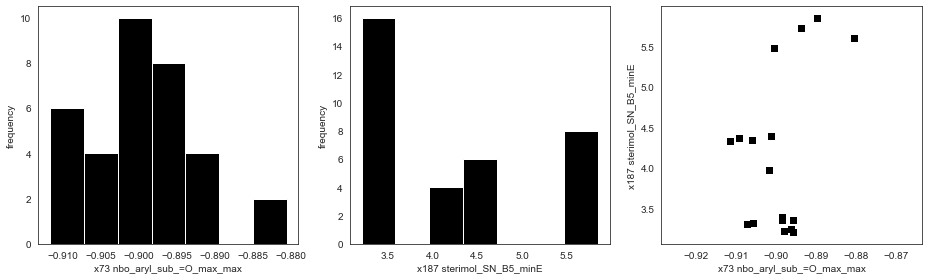


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x188 sterimol_SN_B5_min

34 samples
R^2 = 0.18; p-value = 1.25E-02


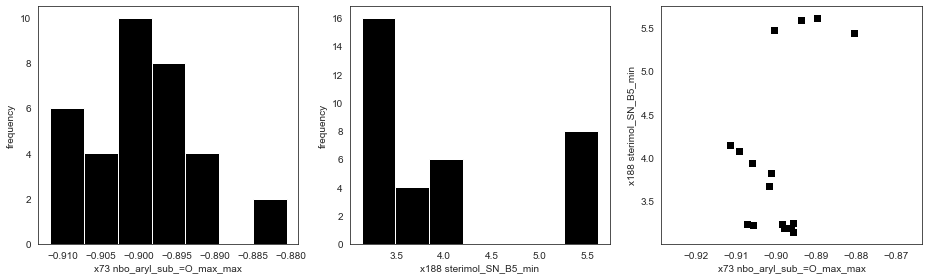


---------------------------------------------------------------------------------------------------------------

x73 nbo_aryl_sub_=O_max_max
x189 sterimol_SN_B5_max

34 samples
R^2 = 0.12; p-value = 4.22E-02


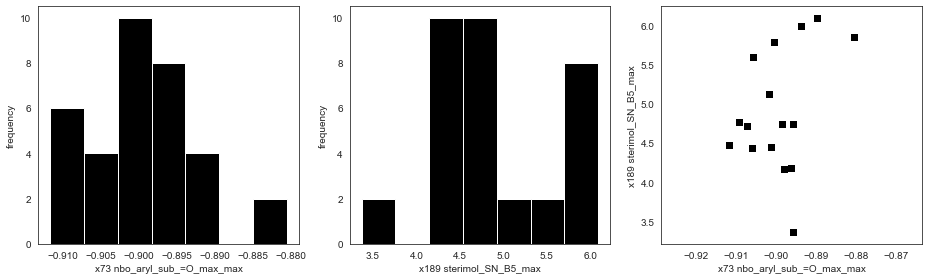


---------------------------------------------------------------------------------------------------------------



In [140]:
# multpile plots set by ranges
# shows only plots as set by criteria below

feats_to_check1 = itertools.chain(range(48,49),range(72,73)) 
feats_to_check2 = range(150,190) 

for i in feats_to_check1:
    num1 = i
    x_format1 = "x{}".format(num1 + 1)
    if type(x_format1) == str:
            [x_format1] = [X_labels.index(i) for i in [x_format1]]
    for p in feats_to_check2:
        num2 = p
        x_format2 = "x{}".format(num2)
        
        #---
        if type(x_format2) == str:
            [x_format2] = [X_labels.index(i) for i in [x_format2]]
        #print(i,x_format1,type(x_format1))
        #print(p,x_format2,type(x_format2))

        if x_format1 != x_format2:
            print(X_labels[x_format1], X_names[x_format1])
            print(X_labels[x_format2], X_names[x_format2])
            print("\n{} samples".format(np.shape(X[:,x_format1])[0]))
            slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,x_format1],X[:,x_format2])
            fit_line = intercept+slope*X[:,x_format1]
            print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
            
            #show only plots satisfying these criteria:
            if r_value > 0.2:
                plt.figure(figsize=(13, 4))
                
                plt.subplot(1,3,1)
                plt.hist(X[:,x_format1], bins="auto",color="black")
                plt.ylabel("frequency")
                plt.xlabel(X_labels[x_format1] + " " + X_names[x_format1])
                plt.subplot(1,3,2)
                plt.hist(X[:,x_format2], bins="auto",color="black")
                plt.ylabel("frequency")
                plt.xlabel(X_labels[x_format2] + " " + X_names[x_format2])
                
                plt.subplot(1,3,3)
                plt.scatter(X[:,x_format1], X[:,x_format2],color="black",marker="s")    
                #plt.plot(X[:,f_ind_1],fit_line)
                
                # label by x number
                #plt.xlabel(X_labels[num1])
                #plt.ylabel(X_labels[num2])
                # label by x name           
                plt.xlabel(X_labels[x_format1] + " " + X_names[x_format1])
                plt.ylabel(X_labels[x_format2] + " " +X_names[x_format2])
                plt.tight_layout()
            
            
                plt.show()   
                
            print("\n---------------------------------------------------------------------------------------------------------------\n")
            

## Bubble Plot

### parm v parm, sized by y

In [16]:
# set x, y, and size dimensions, set plot title
bp_x = "x49"
bp_y = "x73"
#bp_size = "s2_3.5h_%yield(avg)"
#bp_title = "parm v parm sized by y"


#figure size
plt.figure(figsize=(8,8))
# use the scatterplot function to build the bubble map
sns.scatterplot(data=inp, 
                x=bp_x,                   #set x
                y=bp_y,                   #set y
                size=bp_size,             #set size
                sizes=(50, 300),          #set size range
                alpha=0.7,                #set transparency
                color="mediumslateblue",  #set color of points
                marker="D")               #set marker shape

#toggle this to label data points with IDs
#for i in range(0,inp.shape[0]):
#    plt.text(inp[bp_x][i]-0.002, inp[bp_y][i]+0.0001, inp.index[i], size="small")
    
#set x,y limits, place legend outside of plot, set title
plt.xlim((round(min(inp[bp_x]),2)-0.01),(round(max(inp[bp_x]),2)+0.01)) 
plt.ylim((round(min(inp[bp_y]),2)-0.01),(round(max(inp[bp_y]),2)+0.01))
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0)
plt.title(bp_title)

# show or save the graph
plt.show()
#plt.savefig("plotname",format=png,dpi=300)

NameError: name 'bp_size' is not defined

<Figure size 576x576 with 0 Axes>

### with virtual entries

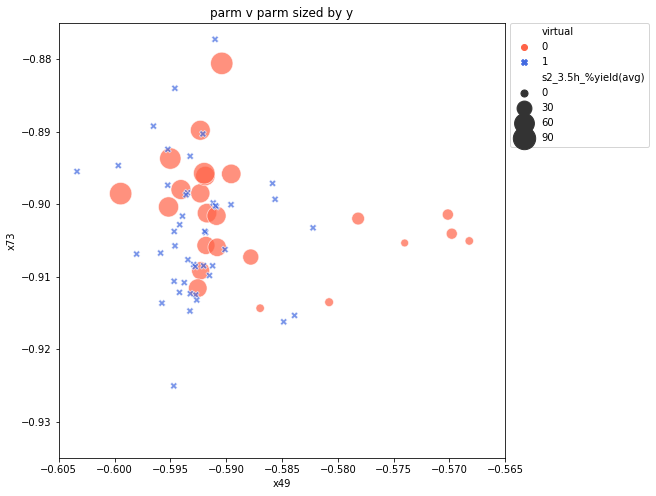

note: virtual ligands sized arbitrarily


In [131]:
#plots exp entires by size and virtual entries on top with different marker
#requires a column labeled "virtual" with 1=virtual structure, 0=experimental structure. put 0s in the ycolumns for these

# set x, y, and size dimensions, set plot title
bp_x = "x49"
bp_y = "x73"
bp_size = "s2_3.5h_%yield(avg)"
bp_title = "parm v parm sized by y"
#set colors for exp (0) and virtual (1)
palette = {0:"tomato",
           1:"royalblue"}

#figure size
plt.figure(figsize=(8,8))
# use the scatterplot function to build the bubble map
sns.scatterplot(data=bp_df, 
                x=bp_x,                   #set x
                y=bp_y,                   #set y
                size=bp_size,             #set size
                sizes=(50, 500),          #set size range
                alpha=0.7,                #set transparency
                hue=inp['virtual'],       #color points by virtual or exp
                style=inp['virtual'],     #set point markers by virtual or exp
                palette=palette)          #use defined colors

#toggle this to label data points or not
#for i in range(0,inp.shape[0]):
#    plt.text(inp[bp_x][i]+0.0002, inp[bp_y][i], inp.index[i], size="small")

#set x,y limits, place legend outside of plot, set title
plt.xlim((round(min(inp[bp_x]),2)-0.005),(round(max(inp[bp_x]),2)+0.005)) 
plt.ylim((round(min(inp[bp_y]),2)-0.005),(round(max(inp[bp_y]),2)+0.005))
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0)
plt.title(bp_title)

# show or save the graph
plt.show()
#plt.savefig("plotname",format=png,dpi=300)

print("note: virtual ligands sized arbitrarily")

## Correlation Map

### OG

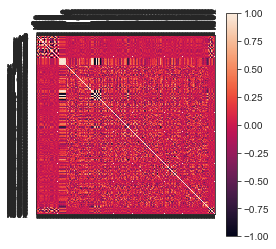

In [32]:
# uncomment this line to use an interactive plot 
# %matplotlib notebook

corrmap = np.corrcoef(X.T)

plt.matshow(corrmap)
plt.xticks(range(len(X_labels)),X_labels, fontsize=10, rotation=90)
plt.yticks(range(len(X_labels)),X_labels, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

### Seaborn

([<matplotlib.axis.YTick at 0x7f79d000f668>,
 <a list of 602 Text yticklabel objects>)

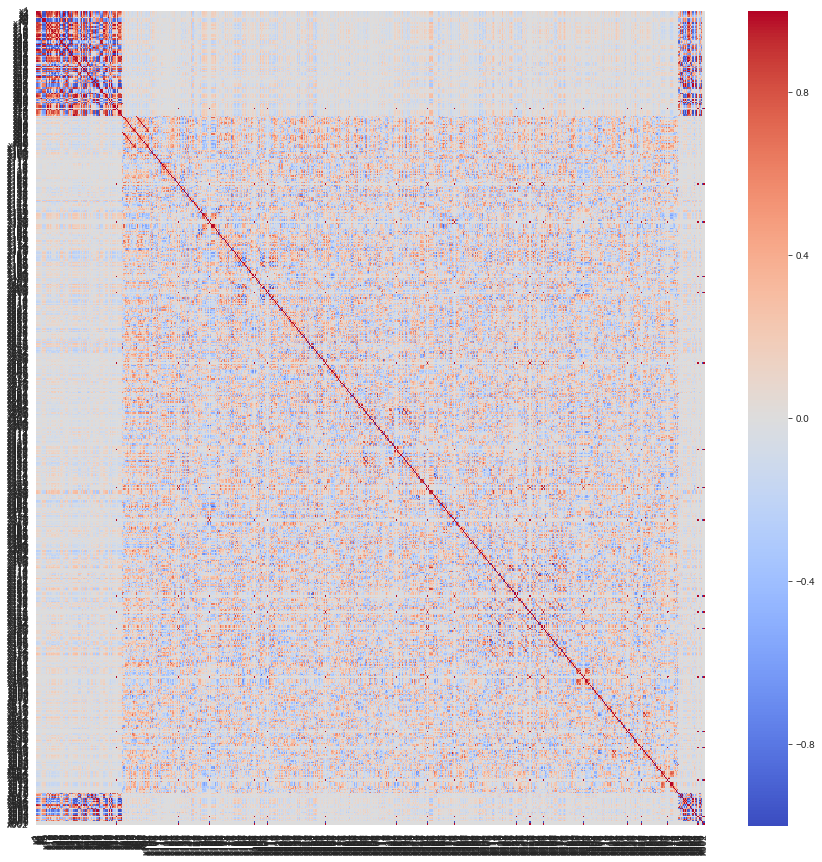

In [19]:
# uncomment this line to use an interactive plot 
#%matplotlib notebook

import seaborn as sns

corrmap = np.corrcoef(X.T)

plt.subplots(figsize=(15,15))
sns.heatmap(corrmap,center=0, annot=False, cmap="coolwarm", cbar=True) #linewidths=0.5
plt.xticks(range(len(X_labels)),X_labels, fontsize=10, rotation=90)
plt.yticks(range(len(X_labels)),X_labels, fontsize=10)


## Single-node Decision Tree

### Regression

Accuracy: 0.71
x2 is_sub4


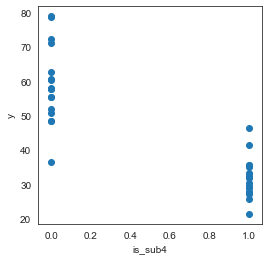

In [43]:
# import graphviz 

dt = DecisionTreeRegressor(max_depth=1).fit(X, y)
print("Accuracy: {:.2f}".format(dt.score(X, y)))

feat = int(np.where(dt.feature_importances_ != 0)[0])
print(X_labels[feat],X_names[feat])

plt.figure(figsize=(4, 4))
plt.scatter(X[:,feat], y)    
plt.xlabel(X_names[feat])
plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

# dot_data = tree.export_graphviz(dt, out_file=None, 
#                      feature_names=X_names,   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph  
plt.show()

### Classify highest and lowest group

x1 is_sub2
x72 nbo_aryl_sub_=O_max_min


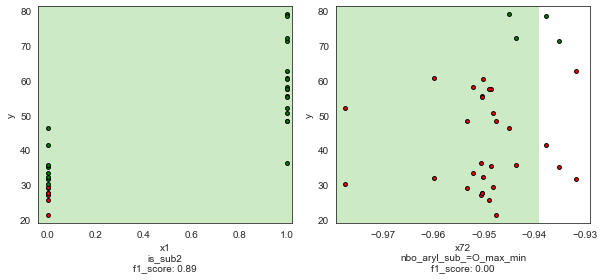

In [44]:
# find features that separate the group with highest/lowest output y
# change the definition of bins in the histogram to get control over how these groups are defined
y_hist,y_bin_edges = np.histogram(y,bins="auto")
y_class_low = [0 if i < y_bin_edges[1] else 1 for i in y]
y_class_high = [1 if i > y_bin_edges[-2] else 0 for i in y]

plt.figure(figsize=(8.5, 4))
n_classes = 2
plot_colors = "rg"
plot_step = 0.02
y_classes = [np.asarray(y_class_low),np.asarray(y_class_high)]
for y_class,i in zip(y_classes,[1,2]):
    dt = DecisionTreeClassifier(max_depth=1).fit(X, y_class)
    feat = int(np.where(dt.feature_importances_ != 0)[0])    
    a = ("f1_score: {:.2f}".format(metrics.f1_score(y_class,dt.predict(X))))
#    b = ("auc: {:.2f}".format(metrics.roc_auc_score(y_class,dt.predict(X))))
    print(X_labels[feat],X_names[feat])    
    xpltlabel = X_labels[feat] + "\n" + X_names[feat] + "\n" + a# + "\n" + b

    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
    x_min, x_max = X[:, feat].min(), X[:, feat].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.subplot(1,2,i)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)

    plt.xlabel(xpltlabel)
    plt.ylabel("y")

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.tight_layout()

# dot_data = tree.export_graphviz(dt_plt, out_file=None, 
#                      feature_names=[x_names[feat]],   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph

### Classification

x1 is_sub2
Decision threshold = 0.50
Accuracy: 0.91
f1_score: 0.90
N = 34


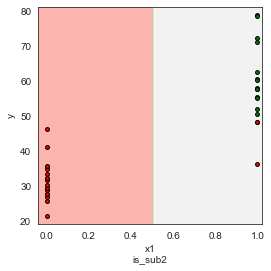

In [46]:
# divide samples into two classes based on y_cut, find the feature that most clearly distinguishes these groups
y_cut = 50

#this can be done on a subset of features
# features = [i for i in itertools.chain(range(75,85),range(90,95))]
# features = [i for i in range(38,135)]
features = range(np.shape(X)[1])
X_use = X[:,features]

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes=2
dt = DecisionTreeClassifier(max_depth=1).fit(X_use, y_class)

feat = features[int(np.where(dt.feature_importances_ != 0)[0])]
print(X_labels[feat],X_names[feat])

dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt_plt.tree_.threshold[0],
        dt_plt.score(X[:,feat].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt_plt.predict(X[:,feat].reshape(-1, 1))),
        len(y)
    ))

plot_colors = "rg"
plot_step = 0.02
x_min, x_max = X[:,feat].min(), X[:,feat].max()
y_min, y_max = y.min(), y.max()
dx,dy = x_max-x_min,y_max-y_min
xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                     np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))

plt.figure(figsize=(4, 4))    
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
xpltlabel = X_labels[feat] + "\n" + X_names[feat]

plt.xlabel(xpltlabel)
plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_class == i)
    plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    

plt.show()

### Property threshold

x1 is_sub2
Decision threshold = 0.50
Accuracy: 0.91
f1_score: 0.90
N = 34


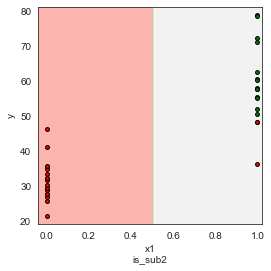


----------------------------------------------

x2 is_sub4
Decision threshold = 0.50
Accuracy: 0.91
f1_score: 0.90
N = 34


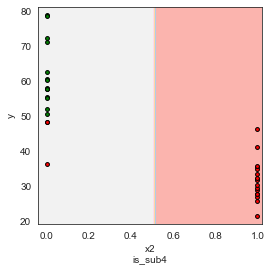


----------------------------------------------

x3 dipole_minE
Decision threshold = 6.40
Accuracy: 0.47
f1_score: 0.61
N = 34


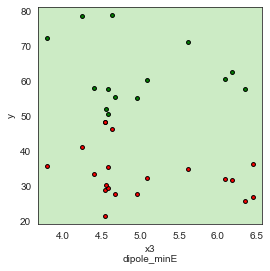


----------------------------------------------

x4 dipole_min
Decision threshold = 2.79
Accuracy: 0.41
f1_score: 0.58
N = 34


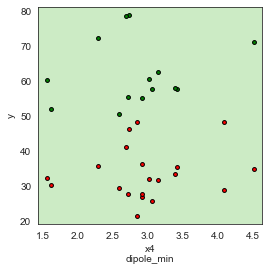


----------------------------------------------

x5 dipole_max
Decision threshold = 8.30
Accuracy: 0.41
f1_score: 0.58
N = 34


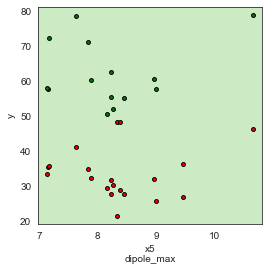


----------------------------------------------

x6 dipole_boltz
Decision threshold = 5.93
Accuracy: 0.41
f1_score: 0.58
N = 34


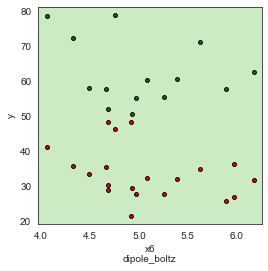


----------------------------------------------

x7 homo_Ehomo_minE
Decision threshold = -0.26
Accuracy: 0.41
f1_score: 0.58
N = 34


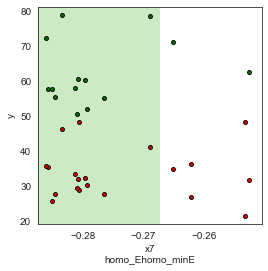


----------------------------------------------

x8 homo_Ehomo_min
Decision threshold = -0.27
Accuracy: 0.41
f1_score: 0.58
N = 34


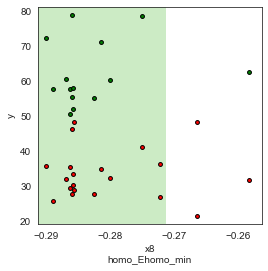


----------------------------------------------

x9 homo_Ehomo_max
Decision threshold = -0.23
Accuracy: 0.47
f1_score: 0.61
N = 34


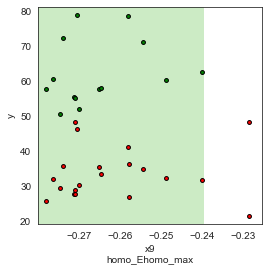


----------------------------------------------

x10 homo_Ehomo_boltz
Decision threshold = -0.26
Accuracy: 0.41
f1_score: 0.58
N = 34


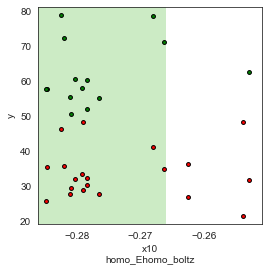


----------------------------------------------

x11 homo_Elumo_minE
Decision threshold = -0.07
Accuracy: 0.47
f1_score: 0.61
N = 34


TypeError: Input z must be at least a 2x2 array.

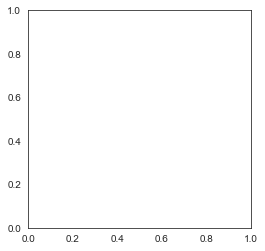

In [51]:
# for public threshold script, see https://github.com/SigmanGroup/Threshold

# divide samples into two classes based on y_cut, visualize how features separate these classes
y_cut = 50
class_weight = {0:1,1:20}

#select features here
features = range(len(X_labels))   # iterate over all features
#features = itertools.chain(range(7,20))

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes = 2
plot_colors = "rg"
plot_step = 0.02 #0.002

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    dt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X[:,f_ind].reshape(-1, 1), y_class)
    print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt.tree_.threshold[0],
        dt.score(X[:,f_ind].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt.predict(X[:,f_ind].reshape(-1, 1))),
        len(y)
    ))
    
    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)
    x_min, x_max = X[:,f_ind].min(), X[:,f_ind].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.figure(figsize=(4, 4))    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
    xpltlabel = X_labels[f_ind] + "\n" + X_names[f_ind]

    plt.xlabel(xpltlabel)
    plt.ylabel("y")  # "$ΔΔG^{≠}$"  "Yield"

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, f_ind], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    
    
    #plt.savefig(name,dpi=300,bbox_inches = 'tight')

    plt.show()
    print("\n----------------------------------------------\n")

# Data preparation: Training/Test set split, Scaling

## Optional preparations

In [7]:
# if you need to do a lot of math on this - hanna generally does not use
# perform transformations on y
y_orig = y.copy() # this is a backup of y

#toggle these options to manipulate y

#exp
# y = np.exp(y_orig)

#log-transformation: either remove all samples with y=0 () or add a small amount to y to avoid log(0).
#y = np.log(y+0.0001)
#or
#y = np.log(y[y.nonzero()[0]])
# y_labels_orig,X_orig = y_labels.copy(),X.copy()
# y_labels = y_labels[y.nonzero()[0]]
# X = X[y.nonzero()[0]]

#absolute value
# y = abs(y)

In [42]:
# preselection option 1
# comment-out first line in Train/test split if using this

# remove samples based on a feature-value 
select_feature = "x79" 

# define cutoff 
mask_prop = X[:,X_labels.index(select_feature)]<5.62   

X_sel,y_sel,y_labels_sel = X[mask_prop],y[mask_prop],y_labels[mask_prop]
print("Shape X: {}".format(X_sel.shape))
print("Shape y: {}".format(y_sel.shape)) 
print("Shape labels: {}".format(y_labels_sel.shape)) 

Shape X: (71, 41)
Shape y: (71,)
Shape labels: (71,)


In [20]:
# preselection - used to exclude certain things from training/test
# comment-out first line in Train/test split if using this

# remove samples based on index (0-indexed)

exclude = [38] #+[i for i in range(26,37)]
print(exclude)
mask = [i for i in range(len(y)) if i not in exclude]
X_sel,y_sel,y_labels_sel = X[mask],y[mask],y_labels[mask]

[38]


## Training/Test set split

TS: [39, 43, 13, 27, 52, 42, 55, 10, 38, 6, 37, 47, 29, 25, 36, 22, 51, 45, 54, 48, 17, 41, 24, 34, 12, 44, 23, 8, 14, 1, 15, 4, 35, 21, 31, 32, 3, 30, 11]
VS: [46, 5, 28, 20, 19, 18, 49, 53, 7, 26, 2, 40, 0, 50, 9, 33, 16]
y_mean TS: -1.101
y_mean VS: -1.081
Shape X_train: (39, 610)
Shape X_test:  (17, 610)


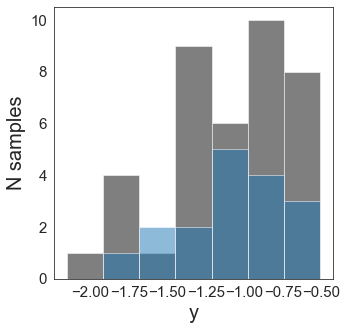

In [12]:
# comment this line out if preselection was performed
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# select method of split:
# random
# y_equidist - picks points that evenly span the output variable y. 
#              Normally doesn't pick highest/lowest values but this can be activated by changing the variable no_extrapolation in the respective section
# ks - Kennard Stone algorithm picks points based on an even distriution in feature space
# define - give a list of sample indices for either VS or TS in the corresponding code section 
# none - all samples in TS

# the numbers in the variables VS and TS refer to the original 0-indexed sample numbers 

split = "random"
test_ratio = 0.3 # means 70% in training set

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
   # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    #TS = [16,27,25,5,13,9,29,7]
    TS = []
    VS = [16,27,25,5,13,9,29,7]
    #TS = [i-1 for i in VS] # this can be commented out if 0-indexed numbers were defined above
    #VS = [i for i in range(X.shape[0]) if i not in VS and i not in exclude]
    TS = [i for i in range(X.syhape[0]) if i not in VS and i not in exclude]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_equidist":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_ks])

    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]
    
    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
else: 
    raise ValueError("split option not recognized")
     

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Feature Scaling 

In [13]:
# scale features by mean/variance, pick the relevant option (normally: StandardScaler)

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

## Cross-terms/Interaction terms

In [71]:
# Add polynomial features/interaction terms
# this is not yet implemented properly in some sections. 
# for 5.1-manual selection: specify cross-term with space between the components: x1 x40 + x6
# Essentially only section 5.2 can use cross-terms so far
# don't run this twice

polyfeats = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
X_train_p = polyfeats.fit_transform(X_train_sc)  #[:,[1,8,0]])
X_test_p = polyfeats.transform(X_test_sc)
X_all_p = polyfeats.transform(X_all_sc)

def add_to_x(matchobj):
    if "^" in matchobj.group(0):
        n = int(matchobj.group(0).split("^")[0])+1
        return("{} x{}".format(n,n))
    else:
        return(str(int(matchobj.group(0))+1))
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])



In [72]:
# filter out non-significant crossterms based on p-value with target variable
p_val_cutoff = 0.005

r2s = []
pvals = []
for f_ind,feature in enumerate(X_train_p.T):
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature, y_train)    
    r2s.append(r_value**2)
    pvals.append(p_value)
    
r2s_ = np.asarray(r2s)
pvals_ = np.asarray(pvals)

keep_p_ = [i[0] for i in np.argwhere(pvals_<p_val_cutoff) if i not in range(np.shape(X_all)[1])]
keep_p = [i for i in range(np.shape(X_all)[1])] + keep_p_

def sub_label_to_name(matchobj):
    return(X_labelname_dict[matchobj.group(0)])
def sub_labelname(matchobj):
    return(matchobj.group(0)+" "+X_labelname_dict[matchobj.group(0)])
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])
X_p_labels = list(np.reshape(pfnames[keep_p],len(keep_p)))
X_p_names = [re.sub("x[0-9]+",sub_label_to_name,st) for st in X_p_labels]
X_p_labelname = [re.sub("x[0-9]+",sub_labelname,st) for st in X_p_labels]

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train_p[:,keep_p])
X_test_sc = scaler.transform(X_test_p[:,keep_p])
X_all_sc = scaler.transform(X_all_p[:,keep_p])

X_labels = X_p_labels
X_names = X_p_names
X_labelname = X_p_labelname

print("{} cross-terms with p-value < {}".format(len(keep_p_),p_val_cutoff))

2749 cross-terms with p-value < 0.005


# Linear modelling, feature selection

## Manual selection of features


Split method: random
Test ratio: 0.3

Features: x229 + x520 + x589 + x609

Parameters:
   -1.1012 + 
   -0.1843 * x229 172_angle_3_min
    0.1466 * x520 342_dihedral_2_max
   -0.2247 * x589 N_lg_sterimol_B5_sub_min
   -0.3054 * x609 dynam_vol_66_100_177

Training R2  = 0.660
Training Q2  = 0.569
Training MAE = 0.196
Training K-fold R2 = 0.554 (+/- 0.001)

Test R2      = 0.640
Test MAE     = 0.160


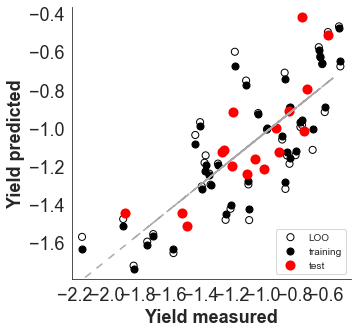

[-1.21690693 -1.00374824 -1.12504267 -1.11625007 -1.12697787 -1.01456746
 -1.1635168  -1.4465604  -1.19817237 -1.24396807 -0.91378555 -0.4198954
 -1.51350157 -0.51470072 -0.91807374 -0.79860068 -1.44554984]
[-0.99674692 -0.91860975 -1.25993529 -1.25174377 -0.89668147 -0.73581833
 -1.05       -1.51883885 -1.19655944 -1.10094215 -0.83390434 -0.75367017
 -1.48368639 -0.587      -1.19098011 -0.71856259 -1.87917411]
[-1.1966072  -0.96952945 -1.51284708 -1.63607671 -0.74701059 -0.77510533
 -0.93034374 -1.28120609 -1.19726169 -0.99302044 -0.51349849 -0.6752226
 -1.24865712 -1.73849852 -1.00802894 -1.4255627  -0.96176859 -1.28420417
 -1.45006279 -1.1600144  -1.6367312  -0.66269492 -1.40443572 -0.47790672
 -1.12073845 -0.89209553 -1.04130336 -1.30233307 -1.00181305 -0.64853831
 -1.12542749 -0.89133784 -0.59093241 -1.32140199 -1.22695558 -0.62723955
 -1.08514668 -1.56877947 -1.61526889]
[-1.28757895 -0.76147216 -1.89274524 -2.15542884 -0.862      -1.10806511
 -1.0312135  -1.09349641 -1.36640289 

In [64]:
#provide an x__ model (string, any order of terms)
features_x =  "x229 + x520 + x589 + x609"#
features_py = sorted([X_labels.index(i.strip()) for i in features_x.split("+")])

# features_py = []
#features = sorted([int(i[1:]) for i in re.findall("x\d+",features_x)])
#features_py = [i-1 for i in features]


X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
lr = Ridge(alpha=1E-5).fit(X_train_sel, y_train)

#lr = LinearRegression().fit(X_train_sel, y_train)
alphas = np.logspace(-6,3,10)

#for i in alphas:
#lr = Ridge(alpha=i).fit(X_train_sel, y_train)     
#print(f'\nalpha: {i}')
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores = repeated_k_fold(X_train_sel,y_train,k=5,n=200)

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))

# settings for plot and saving
#plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav="plotname",label="$ΔΔG^{≠}$",loo_pred=loo_train)
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="Yield",loo_pred=loo_train)
    

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
#print(model.summary())

print (y_pred_test) #prints out all predicted y values in a list - can also do this on training set
print (y_test) #prints experimental values
print(y_pred_train)
print(y_train)

In [46]:
# add all individual features to the manual model
add_df = pd.DataFrame(index=X_labelname,columns=["label_sep","label_abs","Training R2","Training Q2"],dtype=float)

update_model = False
for f_ind in range(len(X_labels)):
    features_iter = features_py + [f_ind]    
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    add_df.iloc[f_ind,:] = [X_labels[f_ind],"x"+str(f_ind+1),lr.score(X_train_sel, y_train),q2]

if update_model and X_labelname.index(add_df['Training Q2'].idxmax()) not in features_py:
    features_py.append(X_labelname.index(add_df['Training Q2'].idxmax()))
add_df.sort_values(by=['Training Q2'],ascending=False).head(20)

label_sep label_abs  Training R2  Training Q2
x318 175_B5_5-6_max-min       x318      x318     0.740127     0.665299
x479 269_angle_MD_wt          x479      x479     0.700648     0.620247
x563 343_L_2-5_MD_wt          x563      x563     0.699245     0.617559
x276 175_angle_1_max          x276      x276     0.691547     0.607844
x439 261_L_2-5_MD_wt          x439      x439     0.686273     0.599153
x170 100_angle_1_max-min      x170      x170     0.677166     0.596890
x226 172_angle_2_max-min      x226      x226     0.685559     0.596389
x317 175_B5_5-6_min           x317      x317     0.681092     0.590594
x372 232_L_2-5_max            x372      x372     0.675951     0.588660
x572 343_B5_2-5_max           x572      x572     0.677638     0.587199
x564 343_L_2-5_max            x564      x564     0.672052     0.585501
x225 172_angle_2_min          x225      x225     0.678061     0.584559
x571 343_B5_2-5_MD_wt         x571      x571     0.673274     0.582011
x311 175_B1_5-6_MD_wt         x311      x311     0.663113     0.581583
x573 343_B5_2-5_min           x573      x573     0.670998     0.580129
x566 343_L_2-5_max-min        x566      x566     0.667737     0.579980
x96 dynam_vol_177              x96       x96     0.678105     0.578589
x252 172_B5_5-6_max           x252      x252     0.669539     0.577750
x574 343_B5_2-5_max-min       x574      x574     0.672808     0.576507
x316 175_B5_5-6_max           x316      x316     0.666654     0.574726

In [26]:
# remove each individual feature from the manual model
print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))

rem_df = pd.DataFrame(index=[X_labelname[i] for i in features_py],
                      columns=["Training R2","Training Q2"])
for f_ind in features_py:
    features_iter = [i for i in features_py if i != f_ind]
#     print(feature, x_names[f_ind])
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    rem_df.loc[X_labelname[f_ind],:] = [lr.score(X_train_sel, y_train),q2]

rem_df.sort_values(by=['Training Q2'],ascending=False)


x49 + x73


AttributeError: type object 'object' has no attribute 'dtype'

## Forward stepwise selection based on p-values

In [22]:
# Forward stepwise selection based on p-value
# threshold values refer to p-value of individual features
threshold_in = 0.05
threshold_out = 0.075 # must be larger than threshold_in

use_manual_feats = False # if True, model from previous section will be used as starting point

import stepwise_selection2 as step_s
if not use_manual_feats:
    features_py=[]

features_py = step_s.stepwise_selection(pd.DataFrame(X_train_sc), y_train,
                    initial_list=features_py,threshold_in=threshold_in,threshold_out=threshold_out,verbose=True)

print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\n"+" + ".join([X_labelname[i] for i in sorted(features_py)]))

X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
lr = RidgeCV(alphas=np.logspace(-6,3,10), cv=3).fit(X_train_sel, y_train) 
print(f'\nalpha: {lr.alpha_}')
#lr = LinearRegression().fit(X_train_sel, y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100,reg=LinearRegression())

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")


testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu)) 
    
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="",loo_pred=loo_train)


ModuleNotFoundError: No module named 'stepwise_selection2'

## other forward feature selection implementations


Split method: y_equidist
Test ratio: 0.2

x1 + x2 + x7 + x129

is_sub2 + is_sub4 + homo_Ehomo_minE + ir_OH_int_max
Training R2;Training Q2;Test R2;0.83;0.77;0.45

yikes. that's ass.


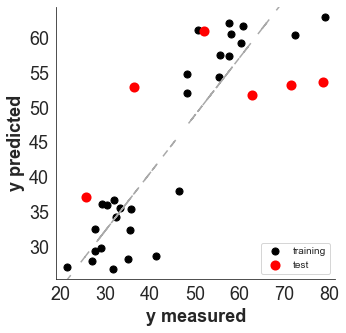

In [144]:
#Scikit-learn - forward feature selection
# largely useless
# options for criteria: 
# mutual_info_regression, f_regression
# select number of features with k
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

criteria = f_regression
skb = SelectKBest(criteria,k=4).fit(X_train_sc,y_train)
selected_feats = skb.get_support(indices=True)
print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_names[i] for i in sorted(selected_feats)]))

X_train_sel = skb.transform(X_train_sc)
X_test_sel = skb.transform(X_test_sc)
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

Time taken for 1856 iterations (minutes): 0.33
Score = 145.40, Number Selected = 9
model formula: y ~ x1 + x103 + x73 + x152 + x42 + x105 + x176 + x33 + x168 
Time taken for Final Model (minutes): 0.33
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     90.17
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           4.04e-13
Time:                        14:27:56   Log-Likelihood:                -61.758
No. Observations:                  28   AIC:                             143.5
Df Residuals:                      18   BIC:                             156.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
        

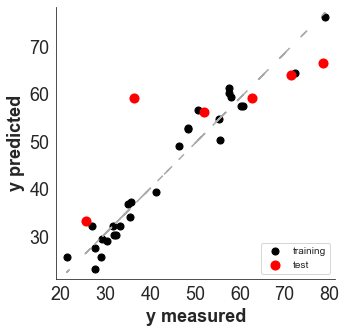

In [107]:
# Forward stepwise selection based on AIC ("aic") or Q2 ("q2")
criteria = "aic"
#criteria = "q2"

import forwardselect_q5 as fsq

df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))

newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
a,b = fsq.Forward_Select(df,"y","Regression",criteria)
selected_feats = [int(i[1:]) for i in b]

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_names[i] for i in sorted(selected_feats)]))

X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train)
print("\n\n")
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

## Forward stepwise selection keeping a set of candidates at each step

### Model search

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 100.8382
Step 3
cutpar:  1
cutpar:  1
cutpar:  1
Step 4
cutpar:  1
cutpar:  1
cutpar:  1
Step 5
cutpar:  2
cutpar:  2
cutpar:  2
Step 6
cutpar:  2
cutpar:  2
cutpar:  2
Step 7
cutpar:  2
cutpar:  2
cutpar:  2
Step 8
cutpar:  3
cutpar:  3
cutpar:  3
Step 9
cutpar:  3
cutpar:  3
cutpar:  3
Done. Time taken (minutes): 375.56

Split method: random
Test ratio: 0.3


Best model:
1 + x144 + x164 + x35 + x387 + x500 + x539 + x551 + x589 + x605
1 + 66_angle_max + 66_PA_max + 100_angle_1_max + NBO_N_sub_pdt_BA + 261_angle_1_MD_wt + 342_L_2-5_max + 342_dist_2-11_MD_wt + N_lg_sterimol_B5_sub_min + dynam_SA_66_100_177

Features: x35 + x144 + x164 + x387 + x500 + x539 + x551 + x589 + x605

Parameters:
   -1.1012 + 
    0.1938 * x35 NBO_N_sub_pdt_BA
   -0.1942 * x144 66_angle_max
    0.2799 * x164 66_PA_max
    0.1015 * x387 261_angle_1_MD_wt
    0.0553 * x500 269_PA_max
    0.0762 * x539 342_L_2-5_MD_wt
    0.0903 * x551 342_dist_2-1

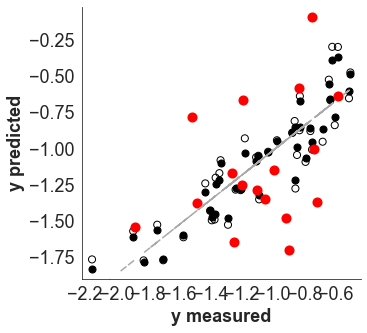

In [14]:
# Forward stepwise selection keeping a set of candidates at each step
n_steps = 9 #limit to number of features we want, will find those with less
n_candidates = 200 #smaller number of candidates speeds up code but often misses models - robust screen number of candidates = parameteres - steps
collin_criteria = 0.5 # this is R2
skipfeatures = [] #["x4","x3"]

import ForwardStepCandidates_2 as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = results.loc[0,"Model"]
selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)

### View models as list

In [15]:
# view best model
results.sort_values(by=['Q^2'],ascending=False).head(30)

Model  n_terms       R^2  \
0   (x144, x164, x35, x387, x500, x539, x551, x589...        9  0.857369   
1     (x144, x164, x348, x356, x387, x52, x579, x605)        8  0.849177   
2   (x144, x164, x172, x348, x35, x356, x387, x589...        9  0.855461   
3   (x144, x164, x387, x500, x51, x539, x551, x579...        9  0.856539   
4   (x107, x163, x211, x250, x35, x367, x464, x475...        9  0.855901   
5   (x144, x153, x164, x348, x35, x356, x387, x589...        9  0.853522   
6   (x144, x164, x35, x387, x481, x539, x551, x589...        9  0.852761   
7   (x144, x164, x348, x35, x355, x387, x542, x589...        9  0.851940   
8   (x144, x164, x348, x35, x356, x387, x537, x589...        9  0.853029   
9   (x144, x164, x348, x35, x356, x387, x488, x589...        9  0.855169   
10  (x136, x144, x151, x164, x315, x51, x540, x579...        9  0.854808   
11  (x144, x153, x164, x348, x35, x355, x387, x589...        9  0.852393   
12  (x144, x164, x35, x387, x405, x539, x551, x589...        9  0.851309   
13  (x144, x158, x164, x348, x35, x356, x387, x589...        9  0.852227   
14    (x144, x164, x35, x387, x539, x551, x589, x605)        8  0.849601   
15  (x100, x144, x164, x173, x35, x507, x542, x589...        9  0.852081   
16  (x144, x164, x185, x35, x387, x539, x551, x589...        9  0.851426   
17  (x144, x164, x346, x348, x35, x356, x387, x589...        9  0.853572   
18  (x144, x164, x294, x348, x356, x387, x52, x579...        9  0.851485   
19  (x144, x164, x35, x371, x387, x539, x551, x589...        9  0.855598   
20  (x144, x164, x348, x35, x356, x387, x500, x589...        9  0.855037   
21  (x144, x164, x168, x35, x387, x539, x551, x589...        9  0.854607   
22  (x107, x163, x211, x249, x35, x367, x464, x475...        9  0.855476   
23  (x144, x164, x348, x35, x356, x387, x420, x589...        9  0.853545   
24  (x144, x164, x292, x348, x356, x387, x52, x579...        9  0.851592   
25  (x144, x164, x35, x379, x387, x539, x551, x589...        9  0.855715   
26  (x144, x164, x234, x35, x376, x387, x390, x589...        9  0.855980   
27  (x144, x164, x234, x35, x378, x387, x390, x589...        9  0.855980   
28    (x144, x164, x348, x35, x356, x387, x589, x605)        8  0.850672   
29  (x114, x144, x164, x222, x35, x380, x387, x589...        9  0.852221   

         Q^2  
0   0.778166  
1   0.774814  
2   0.774577  
3   0.773759  
4   0.773728  
5   0.773034  
6   0.772981  
7   0.772940  
8   0.772914  
9   0.772613  
10  0.772545  
11  0.772430  
12  0.772357  
13  0.772334  
14  0.772305  
15  0.772247  
16  0.772150  
17  0.771879  
18  0.771812  
19  0.771775  
20  0.771679  
21  0.771444  
22  0.771374  
23  0.771338  
24  0.771317  
25  0.771202  
26  0.771037  
27  0.771037  
28  0.770884  
29  0.770823

### Filter results

In [51]:
# view models with a specific number of terms
selmods = results[results.n_terms <=5].sort_values(by=['Q^2'],ascending=False)
selmods.head(55)

Model  n_terms       R^2       Q^2
15883   (x144, x164, x35, x589, x605)        5  0.790446  0.729364
19026   (x144, x164, x51, x579, x605)        5  0.790472  0.722844
19178  (x144, x164, x584, x589, x605)        5  0.786363  0.722462
20349   (x144, x164, x37, x589, x605)        5  0.781911  0.719604
21484   (x367, x37, x490, x589, x604)        5  0.791665  0.716479
21695   (x144, x164, x52, x579, x605)        5  0.787395  0.715908
21952   (x30, x367, x490, x582, x604)        5  0.791356  0.715126
22061    (x367, x490, x580, x604, x7)        5  0.794814  0.714781
22377  (x144, x164, x589, x598, x605)        5  0.783026  0.714059
22777  (x144, x164, x583, x589, x605)        5  0.780642  0.712833
23957   (x35, x367, x490, x589, x604)        5  0.794261  0.709380
24202   (x144, x164, x56, x589, x605)        5  0.779303  0.708752
24512   (x144, x164, x55, x589, x605)        5  0.778315  0.707819
24804  (x367, x490, x584, x589, x604)        5  0.793632  0.706856
25142   (x144, x164, x54, x589, x605)        5  0.772847  0.705838
25799   (x144, x164, x57, x589, x605)        5  0.776412  0.703837
25992  (x112, x160, x256, x383, x579)        5  0.769465  0.703162
26113   (x144, x164, x589, x605, x65)        5  0.777390  0.702807
26593  (x112, x159, x256, x383, x579)        5  0.770172  0.701161
26666   (x367, x490, x51, x579, x604)        5  0.792910  0.700977
26940   (x144, x164, x54, x579, x605)        5  0.779453  0.700042
27130  (x144, x164, x586, x589, x605)        5  0.772549  0.699373
27273  (x144, x164, x249, x579, x605)        5  0.777634  0.698819
27505  (x144, x164, x589, x595, x605)        5  0.773818  0.697942
27536  (x144, x164, x589, x591, x605)        5  0.772744  0.697860
27761  (x210, x463, x490, x589, x604)        5  0.773503  0.696933
27859  (x144, x164, x250, x579, x605)        5  0.776338  0.696612
27866   (x144, x164, x52, x589, x605)        5  0.767039  0.696604
28036  (x144, x164, x589, x592, x605)        5  0.771241  0.695978
28037  (x144, x164, x585, x589, x605)        5  0.771241  0.695978
28118  (x367, x490, x583, x589, x604)        5  0.777857  0.695627
28548   (x367, x490, x52, x579, x604)        5  0.784052  0.693956
28966   (x367, x490, x54, x589, x604)        5  0.774382  0.692222
28980  (x144, x164, x374, x579, x605)        5  0.773464  0.692153
28998  (x367, x490, x586, x589, x604)        5  0.782962  0.692097
29065  (x144, x164, x382, x579, x605)        5  0.771184  0.691833
29096   (x144, x164, x36, x589, x605)        5  0.764465  0.691733
29229   (x367, x37, x498, x589, x604)        5  0.759014  0.691223
29351   (x367, x43, x490, x589, x604)        5  0.772938  0.690681
29374  (x102, x249, x373, x579, x604)        5  0.774758  0.690575
29390  (x210, x367, x490, x579, x604)        5  0.769998  0.690500
29470  (x210, x367, x490, x589, x604)        5  0.769326  0.690154
29564   (x367, x45, x490, x589, x604)        5  0.765468  0.689689
29589  (x190, x367, x490, x579, x604)        5  0.774920  0.689581
29814    (x251, x371, x604, x68, x97)        5  0.771993  0.688532
29897   (x367, x490, x589, x604, x65)        5  0.771339  0.688128
29909   (x211, x35, x367, x449, x589)        5  0.762331  0.688065
29911   (x144, x164, x19, x579, x605)        5  0.774547  0.688057
29952  (x367, x490, x589, x598, x604)        5  0.784435  0.687881
30130   (x251, x371, x579, x604, x95)        5  0.763629  0.687097
30165  (x367, x449, x490, x579, x604)        5  0.768845  0.686917
30218   (x251, x371, x579, x604, x83)        5  0.763559  0.686692
30242  (x210, x358, x490, x589, x604)        5  0.769089  0.686549
30250  (x367, x375, x490, x579, x604)        5  0.763722  0.686527
30380  (x144, x164, x290, x579, x605)        5  0.771256  0.685828

In [49]:
# example for filtering results
#filter to find models containing specified parameters

l1 = [80, 276, 589]
l2 = []
for i in l1:
    a = "x{}".format(i)
    l2.append(a)

selmods2 = results.loc[[i for i in results.index if any(x in l2 for x in results.loc[i,'Model']) and "x200" not in results.loc[i,"Model"]]].sort_values(by=['Q^2'],ascending=False)

selmods2.head(20)

Model  n_terms       R^2  \
0   (x144, x164, x35, x387, x500, x539, x551, x589...        9  0.857369   
2   (x144, x164, x172, x348, x35, x356, x387, x589...        9  0.855461   
4   (x107, x163, x211, x250, x35, x367, x464, x475...        9  0.855901   
5   (x144, x153, x164, x348, x35, x356, x387, x589...        9  0.853522   
6   (x144, x164, x35, x387, x481, x539, x551, x589...        9  0.852761   
7   (x144, x164, x348, x35, x355, x387, x542, x589...        9  0.851940   
8   (x144, x164, x348, x35, x356, x387, x537, x589...        9  0.853029   
9   (x144, x164, x348, x35, x356, x387, x488, x589...        9  0.855169   
11  (x144, x153, x164, x348, x35, x355, x387, x589...        9  0.852393   
12  (x144, x164, x35, x387, x405, x539, x551, x589...        9  0.851309   
13  (x144, x158, x164, x348, x35, x356, x387, x589...        9  0.852227   
14    (x144, x164, x35, x387, x539, x551, x589, x605)        8  0.849601   
15  (x100, x144, x164, x173, x35, x507, x542, x589...        9  0.852081   
16  (x144, x164, x185, x35, x387, x539, x551, x589...        9  0.851426   
17  (x144, x164, x346, x348, x35, x356, x387, x589...        9  0.853572   
19  (x144, x164, x35, x371, x387, x539, x551, x589...        9  0.855598   
20  (x144, x164, x348, x35, x356, x387, x500, x589...        9  0.855037   
21  (x144, x164, x168, x35, x387, x539, x551, x589...        9  0.854607   
22  (x107, x163, x211, x249, x35, x367, x464, x475...        9  0.855476   
23  (x144, x164, x348, x35, x356, x387, x420, x589...        9  0.853545   

         Q^2  
0   0.778166  
2   0.774577  
4   0.773728  
5   0.773034  
6   0.772981  
7   0.772940  
8   0.772914  
9   0.772613  
11  0.772430  
12  0.772357  
13  0.772334  
14  0.772305  
15  0.772247  
16  0.772150  
17  0.771879  
19  0.771775  
20  0.771679  
21  0.771444  
22  0.771374  
23  0.771338

In [61]:
# example for filtering results

selmods2 = results.loc[[i for i in results.index if "x80" in results.loc[i,"Model"] and "x276" in results.loc[i, "Model"]]][results.n_terms < 6].sort_values(by=['Q^2'],ascending=False)
selmods2

Model  n_terms       R^2       Q^2
31256  (x219, x276, x486, x589, x80)        5  0.759657  0.680374
31601  (x219, x276, x550, x589, x80)        5  0.752833  0.677886
32658  (x219, x276, x398, x589, x80)        5  0.744503  0.669962
33377  (x219, x276, x486, x579, x80)        5  0.753804  0.665049
33715  (x105, x276, x279, x579, x80)        5  0.744106  0.662913
...                              ...      ...       ...       ...
88122  (x219, x276, x486, x550, x80)        5  0.379186  0.162967
88134  (x127, x224, x276, x286, x80)        5  0.409911  0.162781
88256              (x276, x350, x80)        3  0.298008  0.159979
88824                    (x276, x80)        2  0.265709  0.148115
89042        (x127, x276, x286, x80)        4  0.376580  0.143757

[83 rows x 4 columns]

In [ ]:
# filter models that contain more than one term that is also in a reference model
reference_model = 0 # this number refer to the index in 'results' or 'selmods', whichever is used 
use_df = results # or: selmods

uniquemods = {use_df.loc[reference_model,"Model"]:reference_model}
for ind in use_df.index:
    selmod = use_df.loc[ind,"Model"]
    if len(selmod) <= 2:
        continue
        
    add = True
    for mod in uniquemods.keys():
        if len([i for i in mod if i in selmod]) >= 2:
            add = False
            break
    if add:      
        uniquemods[use_df.loc[ind,"Model"]] = ind
    
    
print(len(uniquemods.keys()))
selmods2 = results.loc[uniquemods.values()]
selmods2

### Visualize models

Split method: random
Test ratio: 0.3

1 + x367 + x490 + x51 + x579 + x604
1 + 232_dihedral_MD_wt + 269_L_2-5_max-min + NBO_alpha_C_pdt_BA + N_lg_sterimol_L_sub_BA + dynam_SA_100_177

Features: x51 + x367 + x490 + x579 + x604

Parameters:
   -1.1012 + 
    0.1117 * x51 NBO_alpha_C_pdt_BA
    0.1398 * x367 232_dihedral_MD_wt
   -0.1685 * x490 269_L_2-5_max-min
   -0.1877 * x579 N_lg_sterimol_L_sub_BA
   -0.1870 * x604 dynam_SA_100_177

Training R2  = 0.793
Training Q2  = 0.701
Training MAE = 0.157
Training K-fold R2 = 0.690 (+/- 0.001)

Test R2      = -0.116
Test MAE     = 0.287

more disappointing than an unsalted pretzel


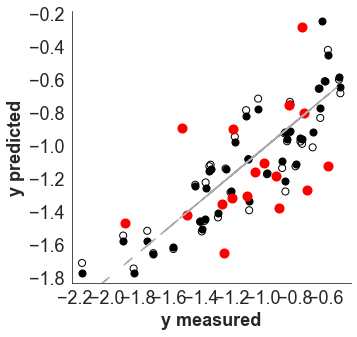

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     25.27
Date:                Tue, 31 May 2022   Prob (F-statistic):           2.11e-10
Time:                        10:28:15   Log-Likelihood:                 9.8998
No. Observations:                  39   AIC:                            -7.800
Df Residuals:                      33   BIC:                             2.182
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1012      0.033    -33.697      0.0

In [63]:
# visualize other models
model_sel = results.loc[26666,"Model"]

#models we like? 10399

#other ways of selecting models:
# model_sel = results.iloc[selmods.index[3],0]
# model_sel = results.iloc[785,0]
# model_sel = ("x100","x31")


selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]

print("Split method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)



print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")


testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

1 + x1 + x103
1 + is_sub2 + nbo_orthoup_minE

____________________________________________________________________________________
1 + x103 + x2
1 + nbo_orthoup_minE + is_sub4

____________________________________________________________________________________
1 + x2 + x103
1 + is_sub4 + nbo_orthoup_minE

____________________________________________________________________________________
1 + x1 + x106
1 + is_sub2 + nbo_orthoup_boltz

____________________________________________________________________________________
1 + x106 + x2
1 + nbo_orthoup_boltz + is_sub4

____________________________________________________________________________________
1 + x2 + x106
1 + is_sub4 + nbo_orthoup_boltz

____________________________________________________________________________________
1 + x1 + x104
1 + is_sub2 + nbo_orthoup_min

____________________________________________________________________________________
1 + x104 + x2
1 + nbo_orthoup_min + is_sub4

____________________________________

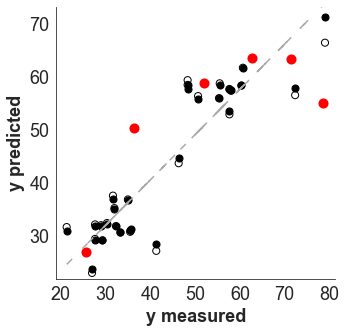

____________________________________________________________________________________
1 + x1 + x49
1 + is_sub2 + nbo_N_oxamide_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x49

Parameters:
   43.5476 + 
   13.1751 * x1 is_sub2
   -4.3407 * x49 nbo_N_oxamide_max

Training R2  = 0.855
Training Q2  = 0.812
Training MAE = 4.205
Training K-fold R2 = 0.802 (+/- 0.001)

Test R2      = 0.691
Test MAE     = 9.125


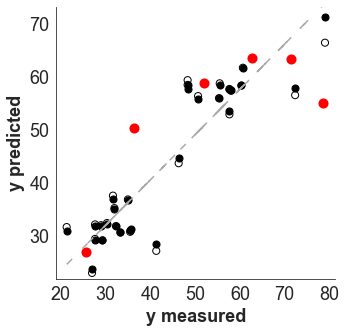

____________________________________________________________________________________
1 + x2 + x50
1 + is_sub4 + nbo_N_oxamide_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x50

Parameters:
   43.5476 + 
  -12.8992 * x2 is_sub4
   -4.3554 * x50 nbo_N_oxamide_boltz

Training R2  = 0.855
Training Q2  = 0.810
Training MAE = 4.513
Training K-fold R2 = 0.805 (+/- 0.000)

Test R2      = 0.744
Test MAE     = 9.445


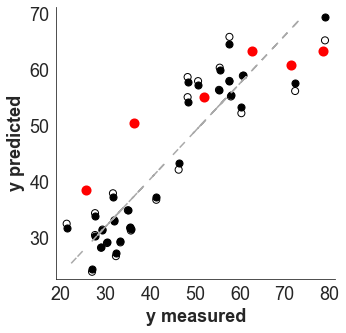

____________________________________________________________________________________
1 + x1 + x50
1 + is_sub2 + nbo_N_oxamide_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x50

Parameters:
   43.5476 + 
   12.8992 * x1 is_sub2
   -4.3554 * x50 nbo_N_oxamide_boltz

Training R2  = 0.855
Training Q2  = 0.810
Training MAE = 4.513
Training K-fold R2 = 0.808 (+/- 0.000)

Test R2      = 0.744
Test MAE     = 9.445


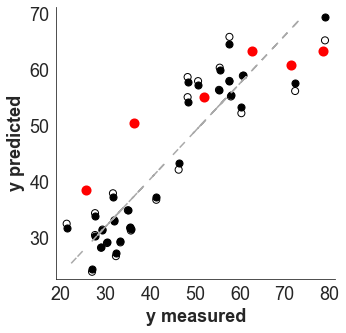

____________________________________________________________________________________
1 + x2 + x73
1 + is_sub4 + nbo_aryl_sub_=O_max_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x73

Parameters:
   43.5476 + 
  -13.0995 * x2 is_sub4
    3.8644 * x73 nbo_aryl_sub_=O_max_max

Training R2  = 0.837
Training Q2  = 0.801
Training MAE = 4.185
Training K-fold R2 = 0.794 (+/- 0.000)

Test R2      = 0.794
Test MAE     = 8.234


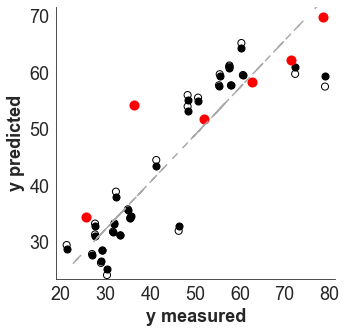

____________________________________________________________________________________
1 + x1 + x73
1 + is_sub2 + nbo_aryl_sub_=O_max_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x73

Parameters:
   43.5476 + 
   13.0995 * x1 is_sub2
    3.8644 * x73 nbo_aryl_sub_=O_max_max

Training R2  = 0.837
Training Q2  = 0.801
Training MAE = 4.185
Training K-fold R2 = 0.794 (+/- 0.000)

Test R2      = 0.794
Test MAE     = 8.234


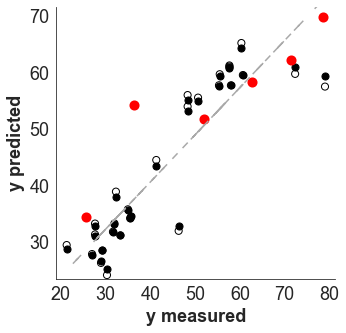

____________________________________________________________________________________
1 + x1 + x98
1 + is_sub2 + nbo_C_CObyNH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x98

Parameters:
   43.5476 + 
   13.3045 * x1 is_sub2
    3.9774 * x98 nbo_C_CObyNH_boltz

Training R2  = 0.841
Training Q2  = 0.789
Training MAE = 4.104
Training K-fold R2 = 0.772 (+/- 0.002)

Test R2      = 0.672
Test MAE     = 9.639


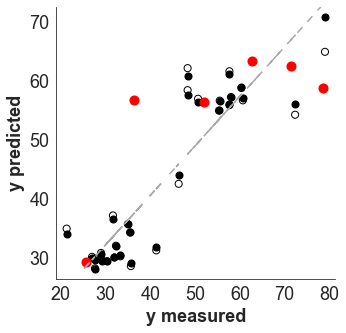

____________________________________________________________________________________
1 + x2 + x98
1 + is_sub4 + nbo_C_CObyNH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x98

Parameters:
   43.5476 + 
  -13.3045 * x2 is_sub4
    3.9774 * x98 nbo_C_CObyNH_boltz

Training R2  = 0.841
Training Q2  = 0.789
Training MAE = 4.104
Training K-fold R2 = 0.765 (+/- 0.002)

Test R2      = 0.672
Test MAE     = 9.639


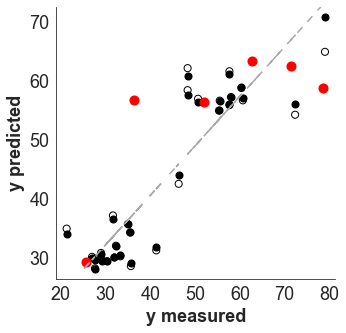

____________________________________________________________________________________
1 + x2 + x47
1 + is_sub4 + nbo_N_oxamide_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x47

Parameters:
   43.5476 + 
  -13.2105 * x2 is_sub4
   -3.8421 * x47 nbo_N_oxamide_minE

Training R2  = 0.836
Training Q2  = 0.778
Training MAE = 4.700
Training K-fold R2 = 0.772 (+/- 0.001)

Test R2      = 0.685
Test MAE     = 10.606


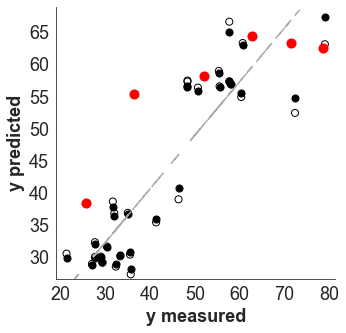

____________________________________________________________________________________
1 + x1 + x47
1 + is_sub2 + nbo_N_oxamide_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x47

Parameters:
   43.5476 + 
   13.2105 * x1 is_sub2
   -3.8421 * x47 nbo_N_oxamide_minE

Training R2  = 0.836
Training Q2  = 0.778
Training MAE = 4.700
Training K-fold R2 = 0.771 (+/- 0.001)

Test R2      = 0.685
Test MAE     = 10.606


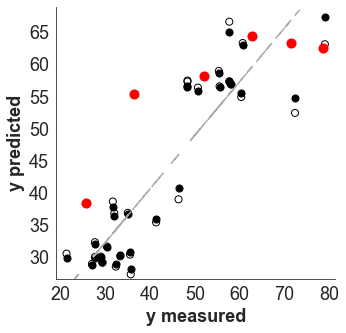

____________________________________________________________________________________
1 + x2 + x77
1 + is_sub4 + nbo_aryl_sub_=O_avg_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x77

Parameters:
   43.5476 + 
  -13.2326 * x2 is_sub4
    3.1606 * x77 nbo_aryl_sub_=O_avg_max

Training R2  = 0.815
Training Q2  = 0.777
Training MAE = 4.365
Training K-fold R2 = 0.771 (+/- 0.000)

Test R2      = 0.772
Test MAE     = 8.558


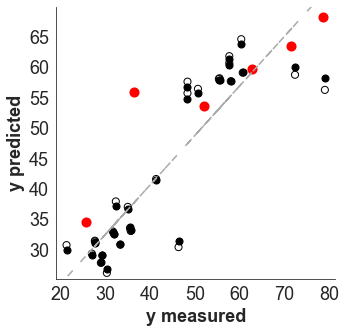

____________________________________________________________________________________
1 + x1 + x77
1 + is_sub2 + nbo_aryl_sub_=O_avg_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x77

Parameters:
   43.5476 + 
   13.2326 * x1 is_sub2
    3.1606 * x77 nbo_aryl_sub_=O_avg_max

Training R2  = 0.815
Training Q2  = 0.777
Training MAE = 4.365
Training K-fold R2 = 0.768 (+/- 0.000)

Test R2      = 0.772
Test MAE     = 8.558


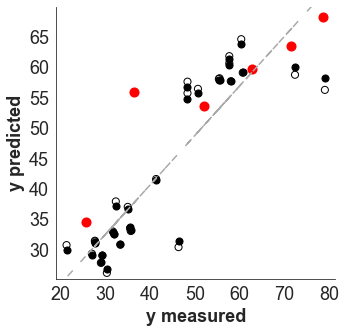

____________________________________________________________________________________
1 + x1 + x101
1 + is_sub2 + nbo_C_ipso_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x101

Parameters:
   43.5476 + 
   12.9231 * x1 is_sub2
    3.8953 * x101 nbo_C_ipso_max

Training R2  = 0.838
Training Q2  = 0.773
Training MAE = 4.342
Training K-fold R2 = 0.759 (+/- 0.001)

Test R2      = 0.754
Test MAE     = 9.523


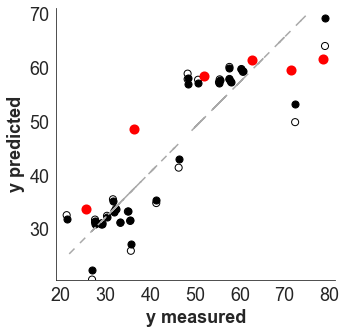

____________________________________________________________________________________
1 + x2 + x101
1 + is_sub4 + nbo_C_ipso_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x101

Parameters:
   43.5476 + 
  -12.9231 * x2 is_sub4
    3.8953 * x101 nbo_C_ipso_max

Training R2  = 0.838
Training Q2  = 0.773
Training MAE = 4.342
Training K-fold R2 = 0.761 (+/- 0.002)

Test R2      = 0.754
Test MAE     = 9.523


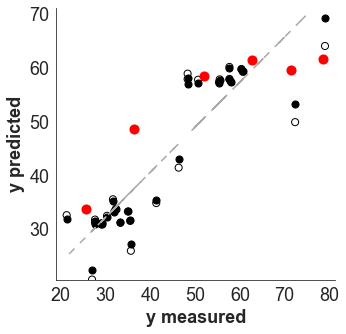

____________________________________________________________________________________
1 + x101 + x2
1 + nbo_C_ipso_max + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x101

Parameters:
   43.5476 + 
  -12.9231 * x2 is_sub4
    3.8953 * x101 nbo_C_ipso_max

Training R2  = 0.838
Training Q2  = 0.773
Training MAE = 4.342
Training K-fold R2 = 0.763 (+/- 0.001)

Test R2      = 0.754
Test MAE     = 9.523


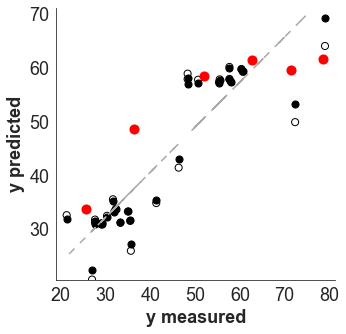

____________________________________________________________________________________
1 + x129 + x2
1 + ir_OH_int_max + is_sub4

____________________________________________________________________________________
1 + x2 + x129
1 + is_sub4 + ir_OH_int_max

____________________________________________________________________________________
1 + x1 + x129
1 + is_sub2 + ir_OH_int_max

____________________________________________________________________________________
1 + x1 + x96
1 + is_sub2 + nbo_C_CObyNH_min


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x96

Parameters:
   43.5476 + 
   13.2270 * x1 is_sub2
    3.5763 * x96 nbo_C_CObyNH_min

Training R2  = 0.827
Training Q2  = 0.771
Training MAE = 4.964
Training K-fold R2 = 0.767 (+/- 0.001)

Test R2      = 0.762
Test MAE     = 9.133


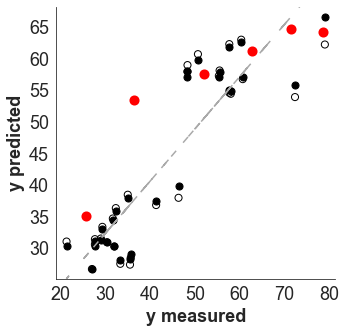

____________________________________________________________________________________
1 + x2 + x96
1 + is_sub4 + nbo_C_CObyNH_min


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x96

Parameters:
   43.5476 + 
  -13.2270 * x2 is_sub4
    3.5763 * x96 nbo_C_CObyNH_min

Training R2  = 0.827
Training Q2  = 0.771
Training MAE = 4.964
Training K-fold R2 = 0.764 (+/- 0.001)

Test R2      = 0.762
Test MAE     = 9.133


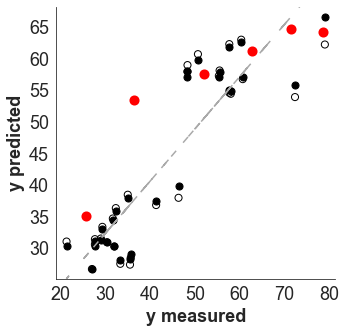

____________________________________________________________________________________
1 + x1 + x144
1 + is_sub2 + ir_CO_byNH_int_min

____________________________________________________________________________________
1 + x2 + x144
1 + is_sub4 + ir_CO_byNH_int_min

____________________________________________________________________________________
1 + x144 + x2
1 + ir_CO_byNH_int_min + is_sub4

____________________________________________________________________________________
1 + x1 + x146
1 + is_sub2 + ir_CO_byNH_int_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x146

Parameters:
   43.5476 + 
   13.5952 * x1 is_sub2
   -3.6071 * x146 ir_CO_byNH_int_boltz

Training R2  = 0.827
Training Q2  = 0.767
Training MAE = 4.587
Training K-fold R2 = 0.761 (+/- 0.001)

Test R2      = 0.745
Test MAE     = 8.849


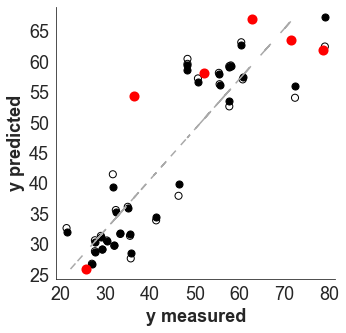

____________________________________________________________________________________
1 + x2 + x146
1 + is_sub4 + ir_CO_byNH_int_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x146

Parameters:
   43.5476 + 
  -13.5952 * x2 is_sub4
   -3.6071 * x146 ir_CO_byNH_int_boltz

Training R2  = 0.827
Training Q2  = 0.767
Training MAE = 4.587
Training K-fold R2 = 0.760 (+/- 0.001)

Test R2      = 0.745
Test MAE     = 8.849


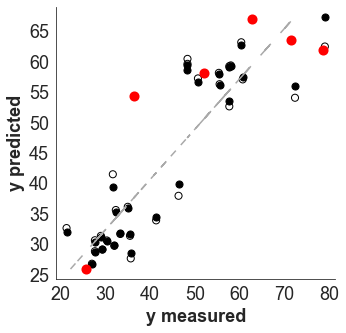

____________________________________________________________________________________
1 + x146 + x2
1 + ir_CO_byNH_int_boltz + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x146

Parameters:
   43.5476 + 
  -13.5952 * x2 is_sub4
   -3.6071 * x146 ir_CO_byNH_int_boltz

Training R2  = 0.827
Training Q2  = 0.767
Training MAE = 4.587
Training K-fold R2 = 0.761 (+/- 0.001)

Test R2      = 0.745
Test MAE     = 8.849


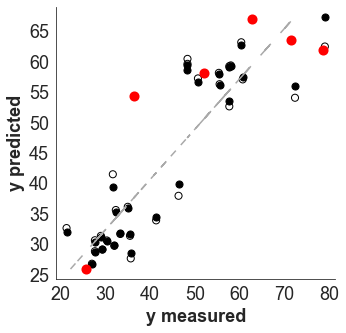

____________________________________________________________________________________
1 + x2 + x16
1 + is_sub4 + homo_mu_min

____________________________________________________________________________________
1 + x16 + x2
1 + homo_mu_min + is_sub4

____________________________________________________________________________________
1 + x1 + x16
1 + is_sub2 + homo_mu_min

____________________________________________________________________________________
1 + x2 + x61
1 + is_sub4 + nbo_O_CObyOH_max

____________________________________________________________________________________
1 + x1 + x61
1 + is_sub2 + nbo_O_CObyOH_max

____________________________________________________________________________________
1 + x162 + x2
1 + sterimol_NC_B1_boltz + is_sub4

____________________________________________________________________________________
1 + x1 + x162
1 + is_sub2 + sterimol_NC_B1_boltz

____________________________________________________________________________________
1 + x2 + x

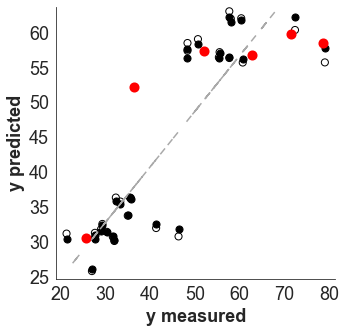

____________________________________________________________________________________
1 + x2 + x39
1 + is_sub4 + qpole_yy_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x39

Parameters:
   43.5476 + 
  -12.8814 * x2 is_sub4
    2.5445 * x39 qpole_yy_minE

Training R2  = 0.799
Training Q2  = 0.756
Training MAE = 4.656
Training K-fold R2 = 0.749 (+/- 0.000)

Test R2      = 0.690
Test MAE     = 10.571


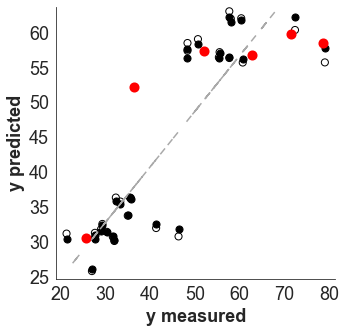

____________________________________________________________________________________
1 + x2 + x166
1 + is_sub4 + sterimol_NC_B5_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x166

Parameters:
   43.5476 + 
  -13.4691 * x2 is_sub4
   -2.6197 * x166 sterimol_NC_B5_boltz

Training R2  = 0.800
Training Q2  = 0.756
Training MAE = 4.774
Training K-fold R2 = 0.749 (+/- 0.001)

Test R2      = 0.697
Test MAE     = 10.102


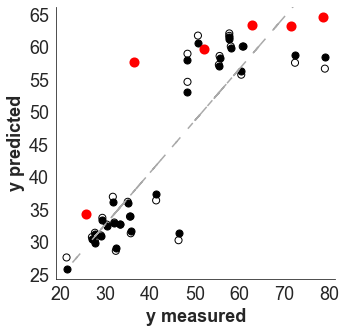

____________________________________________________________________________________
1 + x166 + x2
1 + sterimol_NC_B5_boltz + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x166

Parameters:
   43.5476 + 
  -13.4691 * x2 is_sub4
   -2.6197 * x166 sterimol_NC_B5_boltz

Training R2  = 0.800
Training Q2  = 0.756
Training MAE = 4.774
Training K-fold R2 = 0.745 (+/- 0.001)

Test R2      = 0.697
Test MAE     = 10.102


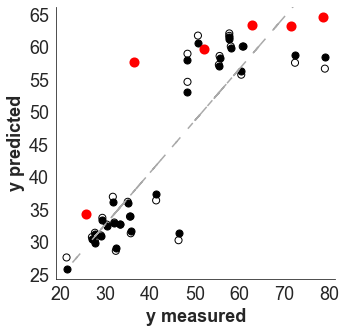

____________________________________________________________________________________
1 + x1 + x166
1 + is_sub2 + sterimol_NC_B5_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x166

Parameters:
   43.5476 + 
   13.4691 * x1 is_sub2
   -2.6197 * x166 sterimol_NC_B5_boltz

Training R2  = 0.800
Training Q2  = 0.756
Training MAE = 4.774
Training K-fold R2 = 0.749 (+/- 0.000)

Test R2      = 0.697
Test MAE     = 10.102


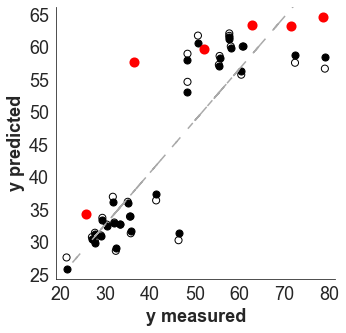

____________________________________________________________________________________
1 + x2 + x15
1 + is_sub4 + homo_mu_minE

____________________________________________________________________________________
1 + x15 + x2
1 + homo_mu_minE + is_sub4

____________________________________________________________________________________
1 + x1 + x15
1 + is_sub2 + homo_mu_minE

____________________________________________________________________________________
1 + x2 + x99
1 + is_sub4 + nbo_C_ipso_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x99

Parameters:
   43.5476 + 
  -12.9144 * x2 is_sub4
    3.5083 * x99 nbo_C_ipso_minE

Training R2  = 0.825
Training Q2  = 0.755
Training MAE = 4.607
Training K-fold R2 = 0.715 (+/- 0.015)

Test R2      = 0.737
Test MAE     = 9.773


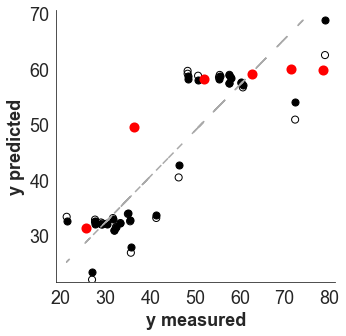

____________________________________________________________________________________
1 + x1 + x99
1 + is_sub2 + nbo_C_ipso_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x99

Parameters:
   43.5476 + 
   12.9144 * x1 is_sub2
    3.5083 * x99 nbo_C_ipso_minE

Training R2  = 0.825
Training Q2  = 0.755
Training MAE = 4.607
Training K-fold R2 = 0.738 (+/- 0.004)

Test R2      = 0.737
Test MAE     = 9.773


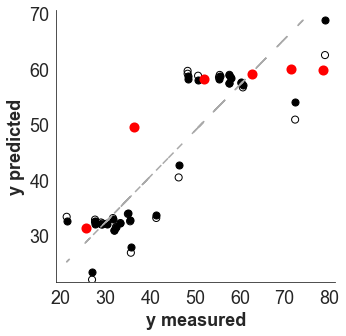

____________________________________________________________________________________
1 + x1 + x65
1 + is_sub2 + nbo_O_CObyNH_max

____________________________________________________________________________________
1 + x2 + x65
1 + is_sub4 + nbo_O_CObyNH_max

____________________________________________________________________________________
1 + x1 + x19
1 + is_sub2 + homo_eta_minE

____________________________________________________________________________________
1 + x2 + x19
1 + is_sub4 + homo_eta_minE

____________________________________________________________________________________
1 + x2 + x10
1 + is_sub4 + homo_Ehomo_boltz

____________________________________________________________________________________
1 + x1 + x10
1 + is_sub2 + homo_Ehomo_boltz

____________________________________________________________________________________
1 + x1 + x42
1 + is_sub2 + qpole_yy_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x42

Parameters:
   43.5476 + 
   12.923

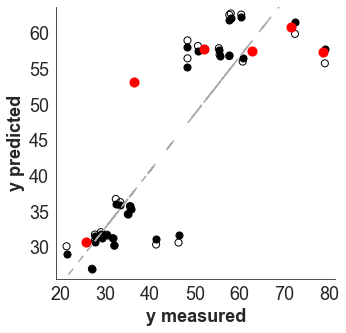

____________________________________________________________________________________
1 + x2 + x42
1 + is_sub4 + qpole_yy_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x42

Parameters:
   43.5476 + 
  -12.9237 * x2 is_sub4
    2.4853 * x42 qpole_yy_boltz

Training R2  = 0.798
Training Q2  = 0.754
Training MAE = 4.612
Training K-fold R2 = 0.751 (+/- 0.000)

Test R2      = 0.667
Test MAE     = 10.810


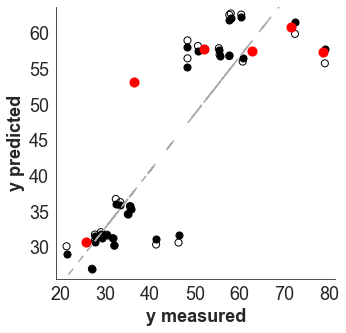

____________________________________________________________________________________
1 + x1 + x18
1 + is_sub2 + homo_mu_boltz

____________________________________________________________________________________
1 + x2 + x18
1 + is_sub4 + homo_mu_boltz

____________________________________________________________________________________
1 + x2 + x149
1 + is_sub4 + ir_NH_freq_max

____________________________________________________________________________________
1 + x1 + x149
1 + is_sub2 + ir_NH_freq_max

____________________________________________________________________________________
1 + x2 + x67
1 + is_sub4 + nbo_aryl_sub_=O_min_minE

____________________________________________________________________________________
1 + x1 + x67
1 + is_sub2 + nbo_aryl_sub_=O_min_minE

____________________________________________________________________________________
1 + x1 + x17
1 + is_sub2 + homo_mu_max

____________________________________________________________________________________
1 

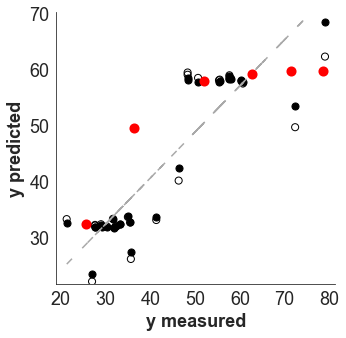

____________________________________________________________________________________
1 + x1 + x102
1 + is_sub2 + nbo_C_ipso_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x102

Parameters:
   43.5476 + 
   12.8710 * x1 is_sub2
    3.4794 * x102 nbo_C_ipso_boltz

Training R2  = 0.824
Training Q2  = 0.749
Training MAE = 4.499
Training K-fold R2 = 0.719 (+/- 0.006)

Test R2      = 0.730
Test MAE     = 9.951


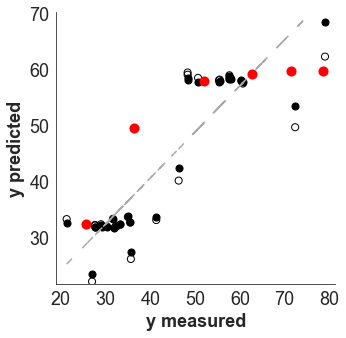

____________________________________________________________________________________
1 + x1 + x173
1 + is_sub2 + sterimol_CS_B1_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x173

Parameters:
   43.5476 + 
   13.4696 * x1 is_sub2
   -2.2299 * x173 sterimol_CS_B1_max

Training R2  = 0.792
Training Q2  = 0.748
Training MAE = 4.774
Training K-fold R2 = 0.743 (+/- 0.000)

Test R2      = 0.689
Test MAE     = 10.047


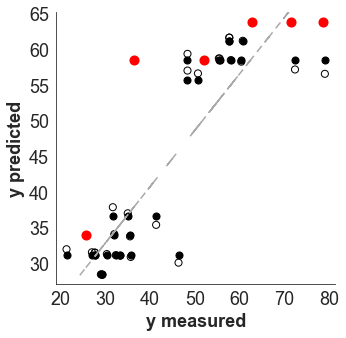

____________________________________________________________________________________
1 + x2 + x173
1 + is_sub4 + sterimol_CS_B1_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x173

Parameters:
   43.5476 + 
  -13.4696 * x2 is_sub4
   -2.2299 * x173 sterimol_CS_B1_max

Training R2  = 0.792
Training Q2  = 0.748
Training MAE = 4.774
Training K-fold R2 = 0.742 (+/- 0.000)

Test R2      = 0.689
Test MAE     = 10.047


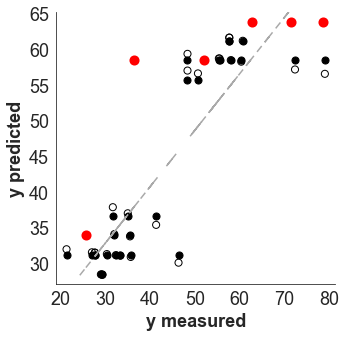

____________________________________________________________________________________
1 + x173 + x2
1 + sterimol_CS_B1_max + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x173

Parameters:
   43.5476 + 
  -13.4696 * x2 is_sub4
   -2.2299 * x173 sterimol_CS_B1_max

Training R2  = 0.792
Training Q2  = 0.748
Training MAE = 4.774
Training K-fold R2 = 0.742 (+/- 0.000)

Test R2      = 0.689
Test MAE     = 10.047


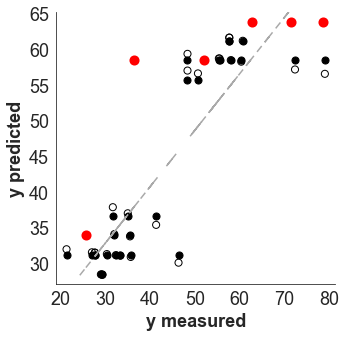

____________________________________________________________________________________
1 + x1 + x141
1 + is_sub2 + ir_CO_byNH_freq_max

____________________________________________________________________________________
1 + x2 + x141
1 + is_sub4 + ir_CO_byNH_freq_max

____________________________________________________________________________________
1 + x2 + x143
1 + is_sub4 + ir_CO_byNH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x143

Parameters:
   43.5476 + 
  -13.2428 * x2 is_sub4
   -2.9961 * x143 ir_CO_byNH_int_minE

Training R2  = 0.810
Training Q2  = 0.747
Training MAE = 4.942
Training K-fold R2 = 0.742 (+/- 0.001)

Test R2      = 0.729
Test MAE     = 8.824


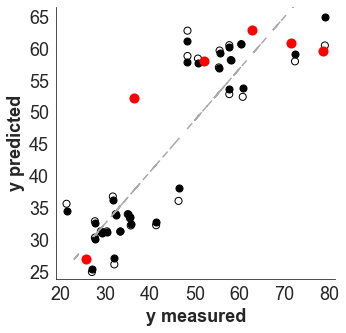

____________________________________________________________________________________
1 + x1 + x143
1 + is_sub2 + ir_CO_byNH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x143

Parameters:
   43.5476 + 
   13.2428 * x1 is_sub2
   -2.9961 * x143 ir_CO_byNH_int_minE

Training R2  = 0.810
Training Q2  = 0.747
Training MAE = 4.942
Training K-fold R2 = 0.741 (+/- 0.001)

Test R2      = 0.729
Test MAE     = 8.824


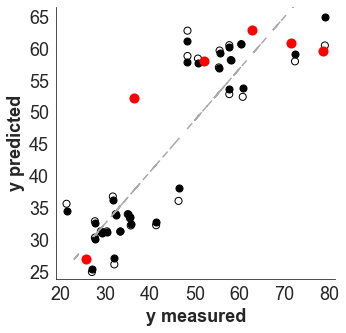

____________________________________________________________________________________
1 + x2 + x137
1 + is_sub4 + ir_CO_byOH_int_max

____________________________________________________________________________________
1 + x1 + x137
1 + is_sub2 + ir_CO_byOH_int_max

____________________________________________________________________________________
1 + x2 + x78
1 + is_sub4 + nbo_aryl_sub_=O_avg_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x78

Parameters:
   43.5476 + 
  -13.1979 * x2 is_sub4
    2.0886 * x78 nbo_aryl_sub_=O_avg_boltz

Training R2  = 0.789
Training Q2  = 0.744
Training MAE = 4.741
Training K-fold R2 = 0.740 (+/- 0.000)

Test R2      = 0.669
Test MAE     = 10.096


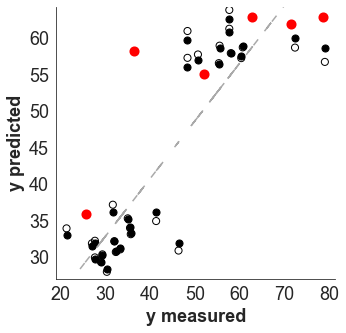

____________________________________________________________________________________
1 + x1 + x78
1 + is_sub2 + nbo_aryl_sub_=O_avg_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x78

Parameters:
   43.5476 + 
   13.1979 * x1 is_sub2
    2.0886 * x78 nbo_aryl_sub_=O_avg_boltz

Training R2  = 0.789
Training Q2  = 0.744
Training MAE = 4.741
Training K-fold R2 = 0.739 (+/- 0.000)

Test R2      = 0.669
Test MAE     = 10.096


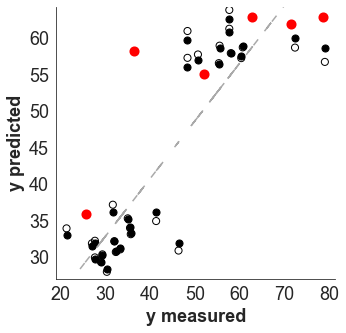

____________________________________________________________________________________
1 + x1 + x69
1 + is_sub2 + nbo_aryl_sub_=O_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x69

Parameters:
   43.5476 + 
   13.2803 * x1 is_sub2
    2.0573 * x69 nbo_aryl_sub_=O_min_max

Training R2  = 0.789
Training Q2  = 0.744
Training MAE = 4.641
Training K-fold R2 = 0.735 (+/- 0.000)

Test R2      = 0.713
Test MAE     = 9.727


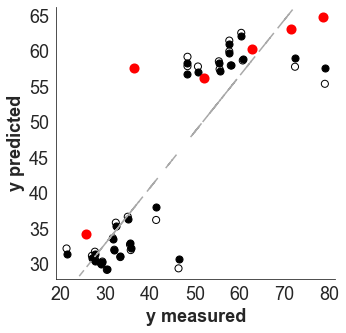

____________________________________________________________________________________
1 + x2 + x69
1 + is_sub4 + nbo_aryl_sub_=O_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x69

Parameters:
   43.5476 + 
  -13.2803 * x2 is_sub4
    2.0573 * x69 nbo_aryl_sub_=O_min_max

Training R2  = 0.789
Training Q2  = 0.744
Training MAE = 4.641
Training K-fold R2 = 0.740 (+/- 0.000)

Test R2      = 0.713
Test MAE     = 9.727


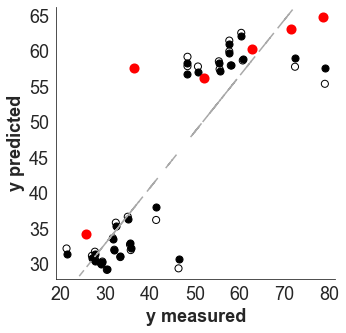

____________________________________________________________________________________
1 + x2 + x75
1 + is_sub4 + nbo_aryl_sub_=O_avg_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x75

Parameters:
   43.5476 + 
  -13.2201 * x2 is_sub4
    2.0650 * x75 nbo_aryl_sub_=O_avg_minE

Training R2  = 0.789
Training Q2  = 0.743
Training MAE = 4.756
Training K-fold R2 = 0.736 (+/- 0.000)

Test R2      = 0.661
Test MAE     = 10.224


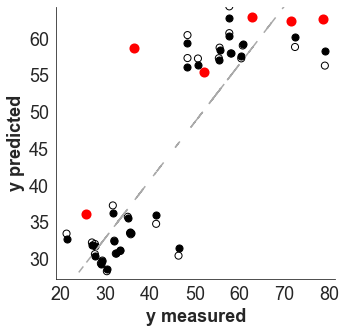

____________________________________________________________________________________
1 + x1 + x75
1 + is_sub2 + nbo_aryl_sub_=O_avg_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x75

Parameters:
   43.5476 + 
   13.2201 * x1 is_sub2
    2.0650 * x75 nbo_aryl_sub_=O_avg_minE

Training R2  = 0.789
Training Q2  = 0.743
Training MAE = 4.756
Training K-fold R2 = 0.739 (+/- 0.000)

Test R2      = 0.661
Test MAE     = 10.224


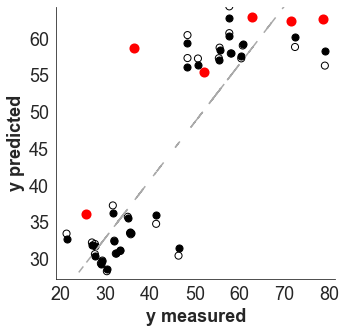

____________________________________________________________________________________
1 + x1 + x81
1 + is_sub2 + NBO_aryl_sub_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x81

Parameters:
   43.5476 + 
   13.4051 * x1 is_sub2
   -2.0966 * x81 NBO_aryl_sub_min_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.733 (+/- 0.001)

Test R2      = 0.721
Test MAE     = 9.839


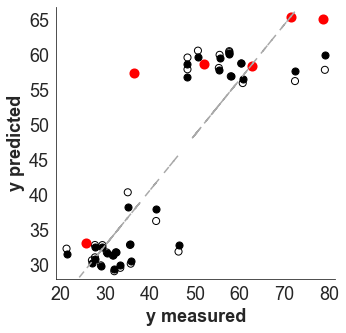

____________________________________________________________________________________
1 + x1 + x85
1 + is_sub2 + NBO_aryl_sub_max_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x85

Parameters:
   43.5476 + 
   13.4051 * x1 is_sub2
   -2.0966 * x85 NBO_aryl_sub_max_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.741 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


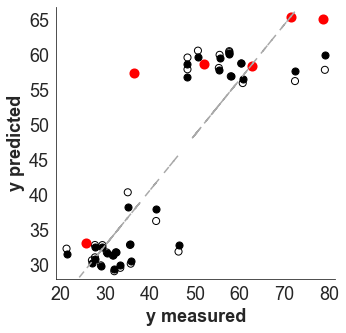

____________________________________________________________________________________
1 + x1 + x89
1 + is_sub2 + NBO_aryl_sub_avg_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x89

Parameters:
   43.5476 + 
   13.4051 * x1 is_sub2
   -2.0966 * x89 NBO_aryl_sub_avg_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.736 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


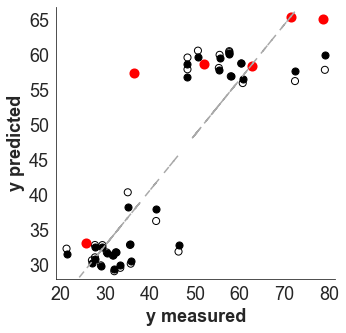

____________________________________________________________________________________
1 + x2 + x81
1 + is_sub4 + NBO_aryl_sub_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x81

Parameters:
   43.5476 + 
  -13.4051 * x2 is_sub4
   -2.0966 * x81 NBO_aryl_sub_min_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.737 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


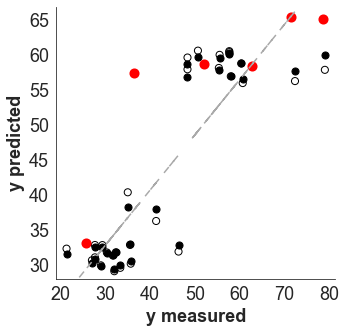

____________________________________________________________________________________
1 + x2 + x85
1 + is_sub4 + NBO_aryl_sub_max_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x85

Parameters:
   43.5476 + 
  -13.4051 * x2 is_sub4
   -2.0966 * x85 NBO_aryl_sub_max_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.734 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


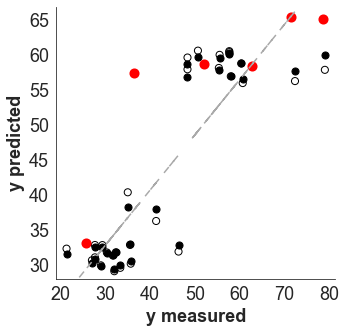

____________________________________________________________________________________
1 + x2 + x89
1 + is_sub4 + NBO_aryl_sub_avg_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x89

Parameters:
   43.5476 + 
  -13.4051 * x2 is_sub4
   -2.0966 * x89 NBO_aryl_sub_avg_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.734 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


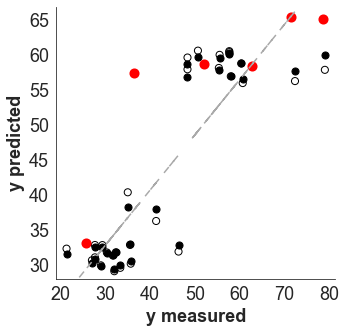

____________________________________________________________________________________
1 + x2 + x185
1 + is_sub4 + sterimol_SN_B1_max

____________________________________________________________________________________
1 + x1 + x185
1 + is_sub2 + sterimol_SN_B1_max

____________________________________________________________________________________
1 + x2 + x55
1 + is_sub4 + nbo_O_OH_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x55

Parameters:
   43.5476 + 
  -13.6141 * x2 is_sub4
   -2.8618 * x55 nbo_O_OH_minE

Training R2  = 0.805
Training Q2  = 0.741
Training MAE = 5.021
Training K-fold R2 = 0.734 (+/- 0.001)

Test R2      = 0.733
Test MAE     = 8.846


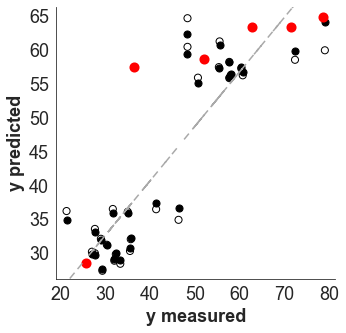

____________________________________________________________________________________
1 + x1 + x55
1 + is_sub2 + nbo_O_OH_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x55

Parameters:
   43.5476 + 
   13.6141 * x1 is_sub2
   -2.8618 * x55 nbo_O_OH_minE

Training R2  = 0.805
Training Q2  = 0.741
Training MAE = 5.021
Training K-fold R2 = 0.731 (+/- 0.001)

Test R2      = 0.733
Test MAE     = 8.846


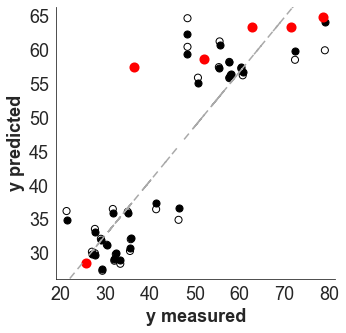

____________________________________________________________________________________
1 + x2 + x6
1 + is_sub4 + dipole_boltz

____________________________________________________________________________________
1 + x1 + x6
1 + is_sub2 + dipole_boltz

____________________________________________________________________________________
1 + x2 + x100
1 + is_sub4 + nbo_C_ipso_min


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x100

Parameters:
   43.5476 + 
  -12.6786 * x2 is_sub4
    3.3633 * x100 nbo_C_ipso_min

Training R2  = 0.820
Training Q2  = 0.740
Training MAE = 4.584
Training K-fold R2 = 0.717 (+/- 0.003)

Test R2      = 0.692
Test MAE     = 10.777


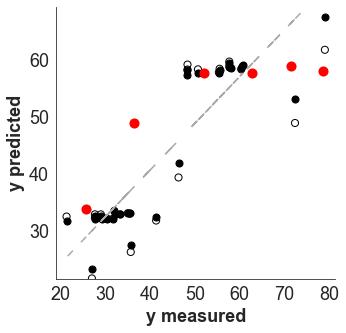

____________________________________________________________________________________
1 + x1 + x100
1 + is_sub2 + nbo_C_ipso_min


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x100

Parameters:
   43.5476 + 
   12.6786 * x1 is_sub2
    3.3633 * x100 nbo_C_ipso_min

Training R2  = 0.820
Training Q2  = 0.740
Training MAE = 4.584
Training K-fold R2 = 0.718 (+/- 0.004)

Test R2      = 0.692
Test MAE     = 10.777


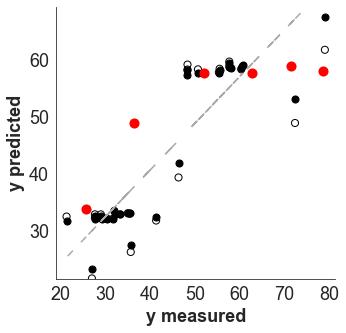

____________________________________________________________________________________
1 + x1 + x118
1 + is_sub2 + dist_OtoH_max_boltz

____________________________________________________________________________________
1 + x2 + x118
1 + is_sub4 + dist_OtoH_max_boltz

____________________________________________________________________________________
1 + x2 + x9
1 + is_sub4 + homo_Ehomo_max

____________________________________________________________________________________
1 + x1 + x9
1 + is_sub2 + homo_Ehomo_max

____________________________________________________________________________________
1 + x1 + x150
1 + is_sub2 + ir_NH_freq_boltz

____________________________________________________________________________________
1 + x2 + x150
1 + is_sub4 + ir_NH_freq_boltz

____________________________________________________________________________________
1 + x2 + x8
1 + is_sub4 + homo_Ehomo_min

____________________________________________________________________________________
1 + 

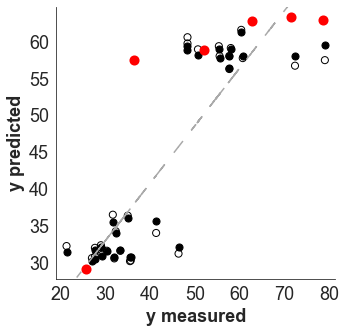

____________________________________________________________________________________
1 + x2 + x138
1 + is_sub4 + ir_CO_byOH_int_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x138

Parameters:
   43.5476 + 
  -13.5258 * x2 is_sub4
   -1.6761 * x138 ir_CO_byOH_int_boltz

Training R2  = 0.782
Training Q2  = 0.736
Training MAE = 5.010
Training K-fold R2 = 0.730 (+/- 0.001)

Test R2      = 0.710
Test MAE     = 9.222


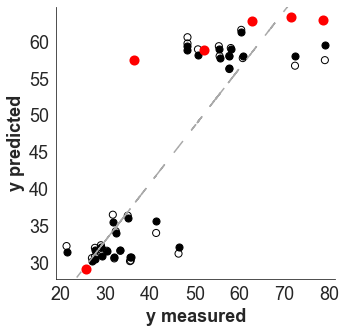

____________________________________________________________________________________
1 + x1 + x148
1 + is_sub2 + ir_NH_freq_min

____________________________________________________________________________________
1 + x2 + x148
1 + is_sub4 + ir_NH_freq_min

____________________________________________________________________________________
1 + x2 + x48
1 + is_sub4 + nbo_N_oxamide_min

____________________________________________________________________________________
1 + x1 + x48
1 + is_sub2 + nbo_N_oxamide_min

____________________________________________________________________________________
1 + x2 + x58
1 + is_sub4 + nbo_O_OH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x58

Parameters:
   43.5476 + 
  -13.7615 * x2 is_sub4
   -2.4918 * x58 nbo_O_OH_boltz

Training R2  = 0.796
Training Q2  = 0.734
Training MAE = 4.870
Training K-fold R2 = 0.728 (+/- 0.001)

Test R2      = 0.691
Test MAE     = 9.471


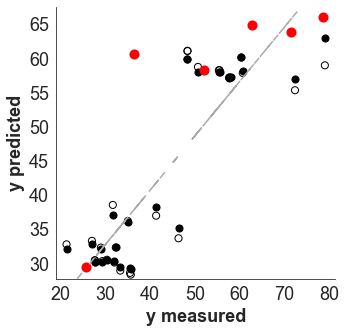

____________________________________________________________________________________
1 + x1 + x58
1 + is_sub2 + nbo_O_OH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x58

Parameters:
   43.5476 + 
   13.7615 * x1 is_sub2
   -2.4918 * x58 nbo_O_OH_boltz

Training R2  = 0.796
Training Q2  = 0.734
Training MAE = 4.870
Training K-fold R2 = 0.724 (+/- 0.001)

Test R2      = 0.691
Test MAE     = 9.471


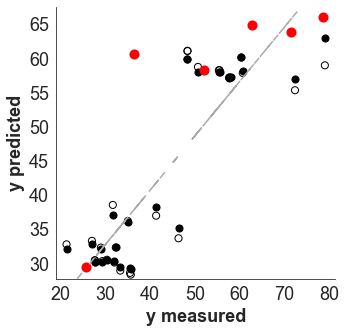

____________________________________________________________________________________
1 + x1 + x135
1 + is_sub2 + ir_CO_byOH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x135

Parameters:
   43.5476 + 
   13.4463 * x1 is_sub2
   -1.8575 * x135 ir_CO_byOH_int_minE

Training R2  = 0.785
Training Q2  = 0.734
Training MAE = 4.971
Training K-fold R2 = 0.724 (+/- 0.001)

Test R2      = 0.716
Test MAE     = 9.222


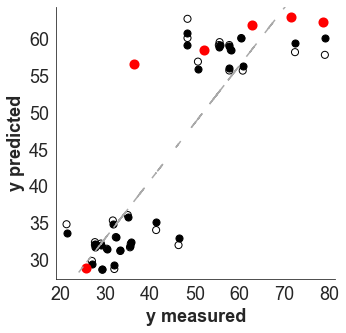

____________________________________________________________________________________
1 + x2 + x135
1 + is_sub4 + ir_CO_byOH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x135

Parameters:
   43.5476 + 
  -13.4463 * x2 is_sub4
   -1.8575 * x135 ir_CO_byOH_int_minE

Training R2  = 0.785
Training Q2  = 0.734
Training MAE = 4.971
Training K-fold R2 = 0.726 (+/- 0.000)

Test R2      = 0.716
Test MAE     = 9.222


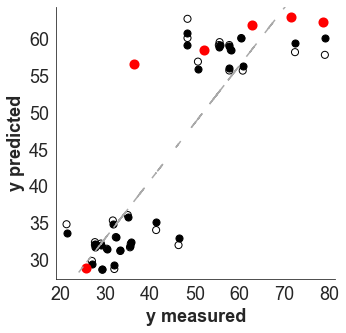

____________________________________________________________________________________
1 + x135 + x2
1 + ir_CO_byOH_int_minE + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x135

Parameters:
   43.5476 + 
  -13.4463 * x2 is_sub4
   -1.8575 * x135 ir_CO_byOH_int_minE

Training R2  = 0.785
Training Q2  = 0.734
Training MAE = 4.971
Training K-fold R2 = 0.727 (+/- 0.001)

Test R2      = 0.716
Test MAE     = 9.222


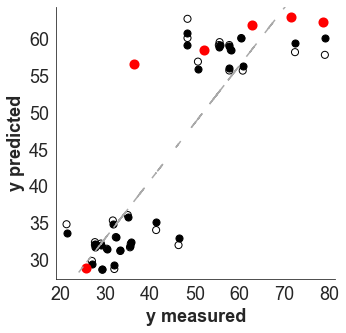

____________________________________________________________________________________
1 + x1 + x92
1 + is_sub2 + nbo_C_CObyOH_min

____________________________________________________________________________________
1 + x2 + x92
1 + is_sub4 + nbo_C_CObyOH_min

____________________________________________________________________________________
1 + x1 + x183
1 + is_sub2 + sterimol_SN_B1_minE

____________________________________________________________________________________
1 + x2 + x183
1 + is_sub4 + sterimol_SN_B1_minE

____________________________________________________________________________________
1 + x2 + x163
1 + is_sub4 + sterimol_NC_B5_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x163

Parameters:
   43.5476 + 
  -13.2671 * x2 is_sub4
   -1.7471 * x163 sterimol_NC_B5_minE

Training R2  = 0.784
Training Q2  = 0.733
Training MAE = 5.110
Training K-fold R2 = 0.727 (+/- 0.000)

Test R2      = 0.696
Test MAE     = 10.316


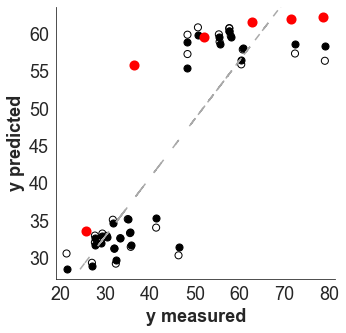

____________________________________________________________________________________
1 + x1 + x163
1 + is_sub2 + sterimol_NC_B5_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x163

Parameters:
   43.5476 + 
   13.2671 * x1 is_sub2
   -1.7471 * x163 sterimol_NC_B5_minE

Training R2  = 0.784
Training Q2  = 0.733
Training MAE = 5.110
Training K-fold R2 = 0.730 (+/- 0.001)

Test R2      = 0.696
Test MAE     = 10.316


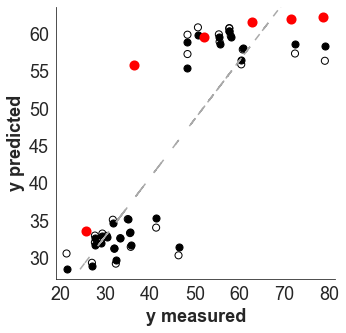

____________________________________________________________________________________
1 + x1 + x131
1 + is_sub2 + ir_CO_byOH_freq_minE

____________________________________________________________________________________
1 + x2 + x131
1 + is_sub4 + ir_CO_byOH_freq_minE

____________________________________________________________________________________
1 + x1 + x134
1 + is_sub2 + ir_CO_byOH_freq_boltz

____________________________________________________________________________________
1 + x2 + x134
1 + is_sub4 + ir_CO_byOH_freq_boltz

____________________________________________________________________________________
1 + x1 + x20
1 + is_sub2 + homo_eta_min

____________________________________________________________________________________
1 + x2 + x20
1 + is_sub4 + homo_eta_min

____________________________________________________________________________________
1 + x1 + x124
1 + is_sub2 + ir_OH_freq_min

_____________________________________________________________________________

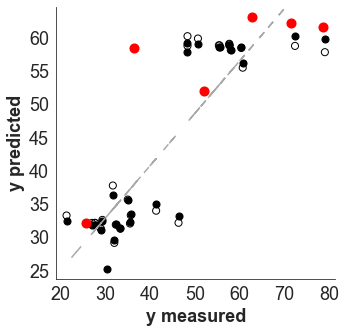

____________________________________________________________________________________
1 + x2 + x72
1 + is_sub4 + nbo_aryl_sub_=O_max_min


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x72

Parameters:
   43.5476 + 
  -13.2016 * x2 is_sub4
    1.9675 * x72 nbo_aryl_sub_=O_max_min

Training R2  = 0.787
Training Q2  = 0.730
Training MAE = 5.172
Training K-fold R2 = 0.725 (+/- 0.000)

Test R2      = 0.678
Test MAE     = 9.217


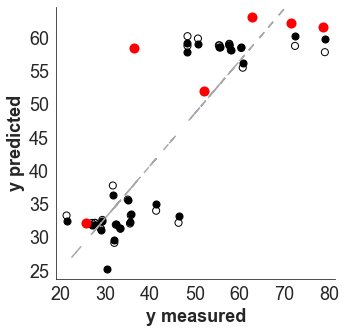

____________________________________________________________________________________
1 + x1 + x35
1 + is_sub2 + qpole_xx_minE

____________________________________________________________________________________
1 + x2 + x35
1 + is_sub4 + qpole_xx_minE

____________________________________________________________________________________
1 + x1 + x172
1 + is_sub2 + sterimol_CS_B1_min

____________________________________________________________________________________
1 + x2 + x172
1 + is_sub4 + sterimol_CS_B1_min

____________________________________________________________________________________
1 + x2 + x62
1 + is_sub4 + nbo_O_CObyOH_boltz

____________________________________________________________________________________
1 + x1 + x62
1 + is_sub2 + nbo_O_CObyOH_boltz

____________________________________________________________________________________
1 + x1 + x46
1 + is_sub2 + qpole_zz_boltz

____________________________________________________________________________________
1 +

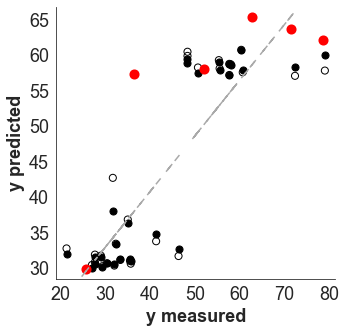

____________________________________________________________________________________
1 + x2 + x130
1 + is_sub4 + ir_OH_int_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x130

Parameters:
   43.5476 + 
  -13.5343 * x2 is_sub4
   -1.8608 * x130 ir_OH_int_boltz

Training R2  = 0.785
Training Q2  = 0.729
Training MAE = 4.933
Training K-fold R2 = 0.719 (+/- 0.001)

Test R2      = 0.703
Test MAE     = 9.676


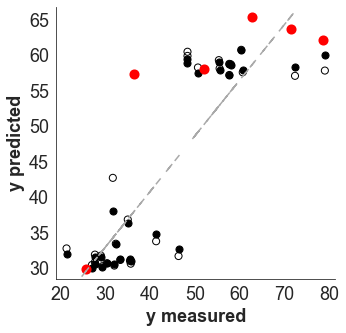

____________________________________________________________________________________
1 + x1 + x51
1 + is_sub2 + nbo_aryl_sub_sub_minE

____________________________________________________________________________________
1 + x2 + x51
1 + is_sub4 + nbo_aryl_sub_sub_minE

____________________________________________________________________________________
1 + x2 + x25
1 + is_sub4 + homo_omega_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x25

Parameters:
   43.5476 + 
  -12.8743 * x2 is_sub4
    1.5448 * x25 homo_omega_max

Training R2  = 0.780
Training Q2  = 0.729
Training MAE = 4.795
Training K-fold R2 = 0.723 (+/- 0.001)

Test R2      = 0.654
Test MAE     = 11.155


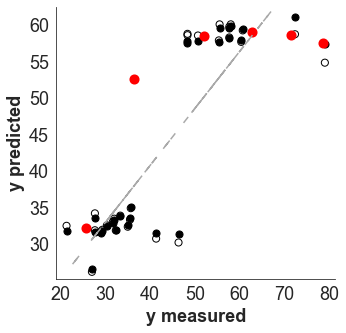

____________________________________________________________________________________
1 + x1 + x25
1 + is_sub2 + homo_omega_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x25

Parameters:
   43.5476 + 
   12.8743 * x1 is_sub2
    1.5448 * x25 homo_omega_max

Training R2  = 0.780
Training Q2  = 0.729
Training MAE = 4.795
Training K-fold R2 = 0.718 (+/- 0.000)

Test R2      = 0.654
Test MAE     = 11.155


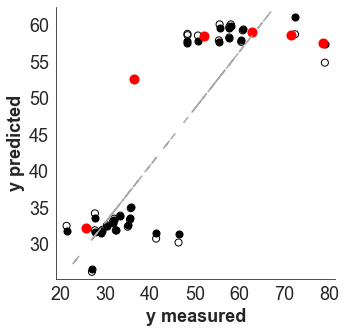

____________________________________________________________________________________
1 + x1 + x127
1 + is_sub2 + ir_OH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x127

Parameters:
   43.5476 + 
   13.3813 * x1 is_sub2
   -1.5263 * x127 ir_OH_int_minE

Training R2  = 0.780
Training Q2  = 0.729
Training MAE = 4.989
Training K-fold R2 = 0.719 (+/- 0.001)

Test R2      = 0.697
Test MAE     = 9.571


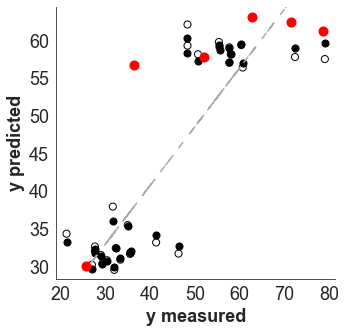

____________________________________________________________________________________
1 + x2 + x127
1 + is_sub4 + ir_OH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x127

Parameters:
   43.5476 + 
  -13.3813 * x2 is_sub4
   -1.5263 * x127 ir_OH_int_minE

Training R2  = 0.780
Training Q2  = 0.729
Training MAE = 4.989
Training K-fold R2 = 0.724 (+/- 0.001)

Test R2      = 0.697
Test MAE     = 9.571


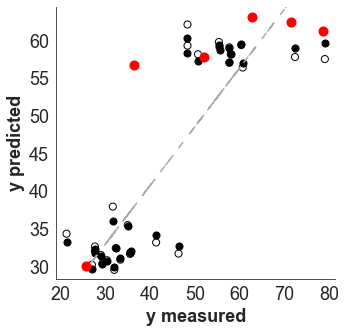

____________________________________________________________________________________
1 + x2 + x136
1 + is_sub4 + ir_CO_byOH_int_min

____________________________________________________________________________________
1 + x1 + x136
1 + is_sub2 + ir_CO_byOH_int_min

____________________________________________________________________________________
1 + x1 + x59
1 + is_sub2 + nbo_O_CObyOH_minE

____________________________________________________________________________________
1 + x2 + x59
1 + is_sub4 + nbo_O_CObyOH_minE

____________________________________________________________________________________
1 + x2 + x82
1 + is_sub4 + NBO_aryl_sub_min_boltz

____________________________________________________________________________________
1 + x2 + x86
1 + is_sub4 + NBO_aryl_sub_max_boltz

____________________________________________________________________________________
1 + x2 + x90
1 + is_sub4 + NBO_aryl_sub_avg_boltz

________________________________________________________________

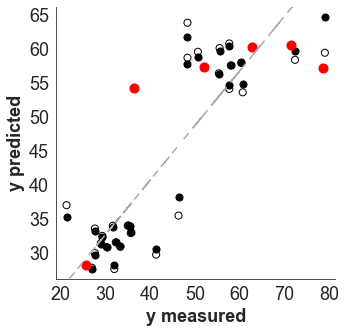

____________________________________________________________________________________
1 + x1 + x95
1 + is_sub2 + nbo_C_CObyNH_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x95

Parameters:
   43.5476 + 
   13.0854 * x1 is_sub2
    2.6290 * x95 nbo_C_CObyNH_minE

Training R2  = 0.801
Training Q2  = 0.727
Training MAE = 4.938
Training K-fold R2 = 0.724 (+/- 0.001)

Test R2      = 0.666
Test MAE     = 10.065


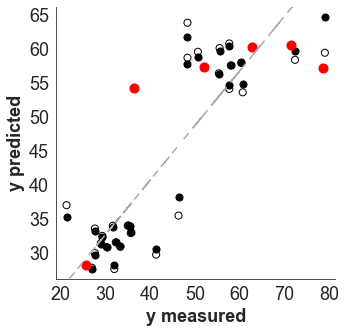

____________________________________________________________________________________
1 + x2 + x4
1 + is_sub4 + dipole_min

____________________________________________________________________________________
1 + x1 + x4
1 + is_sub2 + dipole_min

____________________________________________________________________________________
1 + x1 + x3
1 + is_sub2 + dipole_minE

____________________________________________________________________________________
1 + x2 + x3
1 + is_sub4 + dipole_minE

____________________________________________________________________________________
1 + x1 + x174
1 + is_sub2 + sterimol_CS_B1_boltz

____________________________________________________________________________________
1 + x2 + x174
1 + is_sub4 + sterimol_CS_B1_boltz

____________________________________________________________________________________
1 + x1 + x132
1 + is_sub2 + ir_CO_byOH_freq_min

____________________________________________________________________________________
1 + x2 + x132
1 +

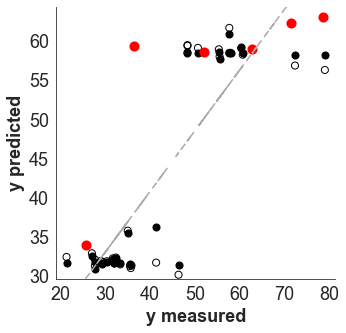

____________________________________________________________________________________
1 + x2 + x113
1 + is_sub4 + dist_OtoH_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x113

Parameters:
   43.5476 + 
  -13.2990 * x2 is_sub4
   -1.2022 * x113 dist_OtoH_min_max

Training R2  = 0.776
Training Q2  = 0.723
Training MAE = 4.899
Training K-fold R2 = 0.702 (+/- 0.007)

Test R2      = 0.652
Test MAE     = 11.021


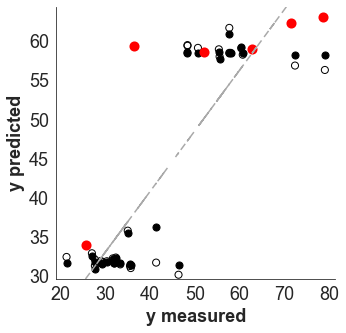

____________________________________________________________________________________
1 + x2 + x94
1 + is_sub4 + nbo_C_CObyOH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x94

Parameters:
   43.5476 + 
  -13.4559 * x2 is_sub4
    1.2070 * x94 nbo_C_CObyOH_boltz

Training R2  = 0.776
Training Q2  = 0.723
Training MAE = 5.066
Training K-fold R2 = 0.715 (+/- 0.000)

Test R2      = 0.669
Test MAE     = 10.194


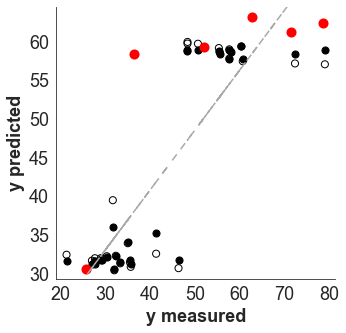

____________________________________________________________________________________
1 + x1 + x94
1 + is_sub2 + nbo_C_CObyOH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x94

Parameters:
   43.5476 + 
   13.4559 * x1 is_sub2
    1.2070 * x94 nbo_C_CObyOH_boltz

Training R2  = 0.776
Training Q2  = 0.723
Training MAE = 5.066
Training K-fold R2 = 0.716 (+/- 0.000)

Test R2      = 0.669
Test MAE     = 10.194


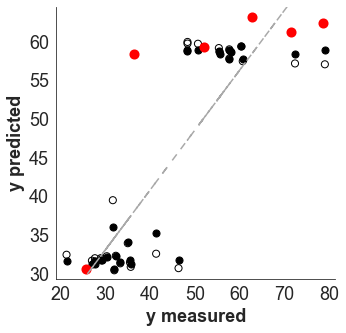

____________________________________________________________________________________
1 + x1 + x31
1 + is_sub2 + qpole_amp_minE

____________________________________________________________________________________
1 + x2 + x31
1 + is_sub4 + qpole_amp_minE

____________________________________________________________________________________
1 + x2 + x91
1 + is_sub4 + nbo_C_CObyOH_minE

____________________________________________________________________________________
1 + x1 + x91
1 + is_sub2 + nbo_C_CObyOH_minE

____________________________________________________________________________________
1 + x1 + x157
1 + is_sub2 + sterimol_NC_L_max

____________________________________________________________________________________
1 + x2 + x157
1 + is_sub4 + sterimol_NC_L_max

____________________________________________________________________________________
1 + x1 + x189
1 + is_sub2 + sterimol_SN_B5_max

____________________________________________________________________________________


____________________________________________________________________________________
1 + x1 + x13
1 + is_sub2 + homo_Elumo_max

____________________________________________________________________________________
1 + x2 + x13
1 + is_sub4 + homo_Elumo_max

____________________________________________________________________________________
1 + x2 + x21
1 + is_sub4 + homo_eta_max

____________________________________________________________________________________
1 + x1 + x21
1 + is_sub2 + homo_eta_max

____________________________________________________________________________________
1 + x2 + x97
1 + is_sub4 + nbo_C_CObyNH_max

____________________________________________________________________________________
1 + x1 + x97
1 + is_sub2 + nbo_C_CObyNH_max

____________________________________________________________________________________
1 + x1 + x32
1 + is_sub2 + qpole_amp_min

____________________________________________________________________________________
1 + x2 + x32
1 + is_

____________________________________________________________________________________
1 + x1 + x5
1 + is_sub2 + dipole_max

____________________________________________________________________________________
1 + x2 + x5
1 + is_sub4 + dipole_max

____________________________________________________________________________________
1 + x1 + x153
1 + is_sub2 + ir_NH_int_max

____________________________________________________________________________________
1 + x2 + x153
1 + is_sub4 + ir_NH_int_max

____________________________________________________________________________________
1 + x1 + x156
1 + is_sub2 + sterimol_NC_L_min

____________________________________________________________________________________
1 + x2 + x156
1 + is_sub4 + sterimol_NC_L_min

____________________________________________________________________________________
1 + x2 + x158
1 + is_sub4 + sterimol_NC_L_boltz

____________________________________________________________________________________
1 + x1 + x158
1

____________________________________________________________________________________
1 + x17 + x98
1 + homo_mu_max + nbo_C_CObyNH_boltz

____________________________________________________________________________________
1 + x10 + x106
1 + homo_Ehomo_boltz + nbo_orthoup_boltz

____________________________________________________________________________________
1 + x16 + x106
1 + homo_mu_min + nbo_orthoup_boltz

____________________________________________________________________________________
1 + x10 + x104
1 + homo_Ehomo_boltz + nbo_orthoup_min

____________________________________________________________________________________
1 + x16 + x105
1 + homo_mu_min + nbo_orthoup_max

____________________________________________________________________________________
1 + x10 + x103
1 + homo_Ehomo_boltz + nbo_orthoup_minE

____________________________________________________________________________________
1 + x16 + x103
1 + homo_mu_min + nbo_orthoup_minE

________________________________

In [147]:
# print all models that are within a specified criteria (if statement below)
# results.index will look at all models, selmods.index will look at filtered models

#for i in results.index:
for i in selmods.index:
    model_sel = results.loc[i,"Model"]
    
    #other ways of selecting models:
    # model_sel = results.iloc[selmods.index[3],0]
    # model_sel = results.iloc[785,0]
    # model_sel = ("x100","x31")
    
    
    selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
    X_train_sel = X_train_sc[:,selected_feats]
    X_test_sel = X_test_sc[:,selected_feats]
    print(models[model_sel].formula)
    print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
    lr = LinearRegression().fit(X_train_sel,y_train)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_test =  lr.predict(X_test_sel)
    
    q2,loo_train = loo.q2(X_train_sel,y_train)
    kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)
    
    testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
    trainr2 = lr.score(X_train_sel, y_train)
    
    #set criteria here 
    if testr2 >= 0.65 and q2>=0.6:
        print("\nSplit method: {}".format(split))
        print("Test ratio: {}\n".format(test_ratio))
        
        print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
        print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))
        
        print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
        print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")
        
        print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
        print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")
    
        if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
            print("\n"+random.choice(insu))
        
        plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
    
        #model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
        #print(model.summary())
        
    print("____________________________________________________________________________________")

# Other

## Ridge Regression, no feature selection 


Split method: random
Test ratio: 0.3

0.0001
     Training R2;Training Q2;Test R2;0.88;0.37;0.52
0.001
     Training R2;Training Q2;Test R2;0.88;0.37;0.52
0.01
     Training R2;Training Q2;Test R2;0.88;0.37;0.52
0.1
     Training R2;Training Q2;Test R2;0.88;0.37;0.52
1.0
     Training R2;Training Q2;Test R2;0.88;0.38;0.52
10.0
     Training R2;Training Q2;Test R2;0.88;0.40;0.54
100.0
     Training R2;Training Q2;Test R2;0.85;0.46;0.58
1000.0
     Training R2;Training Q2;Test R2;0.62;0.27;0.40
10000.0
     Training R2;Training Q2;Test R2;0.18;0.03;0.09


Using hyperparameter = 100.0


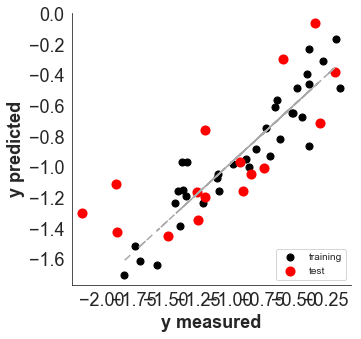

In [38]:
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

linm = Ridge().fit(X_train_sc, y_train)

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,4,9)
for parm in parm_range:
    print(parm)
    linm = Ridge(alpha=parm).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,Ridge(alpha=parm))
    
    y_pred_train = linm.predict(X_train_sc)
    y_pred_test =  linm.predict(X_test_sc)
    #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(linm.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
        
    r2s.append(linm.score(X_train_sc, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
linm = Ridge(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = linm.predict(X_train_sc)
y_pred_test =  linm.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

## Lasso feature selection


Split method: random
Test ratio: 0.3

0.0001
     Training R2;Training Q2;Test R2;0.88;-24829784339011708731260928.00;-4391097789950362193494016.00
     Number of features used: 68
0.001
     Training R2;Training Q2;Test R2;0.88;-1441728813758375236993024.00;0.31
     Number of features used: 28
0.01
     Training R2;Training Q2;Test R2;0.88;0.60;0.28
     Number of features used: 18
0.1
     Training R2;Training Q2;Test R2;0.83;0.64;0.56
     Number of features used: 10
1.0
     Number of features used: 0
10.0
     Number of features used: 0


Using hyperparameter = 0.1


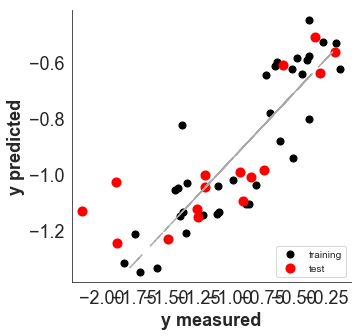



LassoLarsCV
Training R2;Training Q2;Test R2;0.87;0.45;0.50
Number of features used: 20


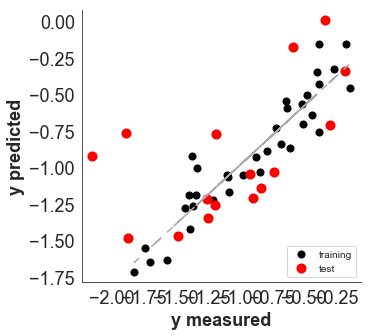

In [39]:
# Lasso feature selection
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,1,6)
for parm in parm_range:
    print(parm)
    lasso = Lasso(alpha=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(lasso.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(lasso.coef_!=0)[0]]
    try:
        q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
        lr = LinearRegression().fit(X_train_sel,y_train)
        y_pred_train = lr.predict(X_train_sel)
        y_pred_test =  lr.predict(X_test_sel)
        #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
        print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
        #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
    except:
        pass
    print("     Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
    # print(np.where(lr.coef_ != 0)[1])
    
    r2s.append(lasso.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
lasso = Lasso(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = lasso.predict(X_train_sc)
y_pred_test =  lasso.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    
    
# llbic = LassoLarsIC(criterion="bic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llbic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llbic.coef_!=0)[0]]
# print("\n\nLassoLarsIC bic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llbic.score(X_train_sc, y_train),q2,llbic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llbic.coef_ != 0)))

# llaic = LassoLarsIC(criterion="aic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llaic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llaic.coef_!=0)[0]]
# print("\n\nLassoLarsIC aic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llaic.score(X_train_sc, y_train),q2,llaic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llaic.coef_ != 0)))

# lassocv = LassoCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(lassocv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(lassocv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nLassoCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lassocv.score(X_train_sc, y_train),q2,lassocv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(lassocv.coef_ != 0)))
# print(np.where(lassocv.coef_ != 0)[1])

llcv = LassoLarsCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(llcv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(llcv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
print("\n\nLassoLarsCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llcv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(llcv.coef_ != 0)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = llcv.predict(X_train_sc)
y_pred_test =  llcv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    



## Elastic Net


Split method: y_equidist
Test ratio: 0.2



ElasticNetCV
Training R2;Training Q2;Test R2;0.98;0.90;0.78
Number of features used: 42
Best hyperparameters: l1_ratio = 0.66, alpha = 0.1788649529057435


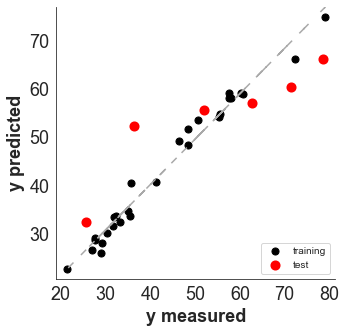

Wall time: 648 ms


In [118]:
%%time
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

encv = ElasticNetCV(l1_ratio=[.01,.05,.66,.1,.2,.3, .5, .7, .9, .95, .99, 1],
#                     n_alphas=500,
                    alphas=np.logspace(-1,4,100),
                    cv=3,n_jobs=-1,max_iter=1000000).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(encv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(encv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,Ridge(alpha=encv.alpha_))
y_pred_train = encv.predict(X_train_sc)
y_pred_test =  encv.predict(X_test_sc)
print("\n\nElasticNetCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(encv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(encv.coef_ != 0)))
print("Best hyperparameters: l1_ratio = {}, alpha = {}".format(encv.l1_ratio_,encv.alpha_))


plot_fit(y_train,y_pred_train,y_test,y_pred_test) 


## Orthogonal Matching Pursuit

In [119]:
# Orthogonal Matching Pursuit
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

parm_range = range(1,10)
print(np.shape(X_train_sc))
print(np.shape(y_train))
for parm in parm_range:
    print(parm)
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(omp.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(omp.coef_!=0)[0]]
    q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
    y_pred_train = omp.predict(X_train_sc)
    y_pred_test =  omp.predict(X_test_sc)
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(omp.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

    print("     "+" + ".join(["x"+str(i+1) for i in np.where(omp.coef_ != 0)[0]]))
    #print("     Number of features used: {}".format(np.sum(lr.coef_ != 0)))
    

# ompcv = OrthogonalMatchingPursuitCV(cv=LeaveOneOut(),n_jobs=-1).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(ompcv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(ompcv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nOrthogonalMatchingPursuitCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(ompcv.score(X_train_sc, y_train),q2,ompcv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(ompcv.coef_ != 0)))

# print("\n"+" + ".join(["x"+str(i+1) for i in np.where(ompcv.coef_!=0)[0]]))
# print("\n"+" + ".join([X_names[i] for i in np.where(ompcv.coef_!=0)[0]]))

# y_pred_train = ompcv.predict(X_train_sc)
# y_pred_test =  ompcv.predict(X_test_sc)
# plot_fit(y_train,y_pred_train,y_test,y_pred_test)



Split method: y_equidist
Test ratio: 0.2

(28, 190)
(28,)
1
     Training R2;Training Q2;Test R2;0.77;0.73;0.59
     x1
2
     Training R2;Training Q2;Test R2;0.87;0.83;0.60
     x1 + x103
3
     Training R2;Training Q2;Test R2;0.93;0.90;0.80
     x1 + x73 + x103
4
     Training R2;Training Q2;Test R2;0.95;0.91;0.79
     x1 + x73 + x103 + x152
5
     Training R2;Training Q2;Test R2;0.96;0.92;0.80
     x1 + x42 + x73 + x103 + x152
6
     Training R2;Training Q2;Test R2;0.97;0.91;0.75
     x1 + x42 + x73 + x103 + x152 + x158
7
     Training R2;Training Q2;Test R2;0.97;0.94;0.80
     x1 + x42 + x63 + x73 + x103 + x152 + x158
8
     Training R2;Training Q2;Test R2;0.98;0.94;0.79
     x1 + x32 + x42 + x63 + x73 + x103 + x152 + x158
9
     Training R2;Training Q2;Test R2;0.98;0.93;0.81
     x1 + x32 + x42 + x63 + x73 + x103 + x140 + x152 + x158


## Nonlinear Modelling

### Kernel Ridge Regression 


Split method: random
Test ratio: 0.3



KernelRidge
0.001
     Training R2;Training Q2;Test R2;1.00;0.30;0.47
0.01
     Training R2;Training Q2;Test R2;1.00;0.30;0.47
0.1
     Training R2;Training Q2;Test R2;0.99;0.34;0.51
1.0
     Training R2;Training Q2;Test R2;0.85;0.33;0.49
10.0
     Training R2;Training Q2;Test R2;0.29;-0.09;-0.08
100.0
     Training R2;Training Q2;Test R2;-1.82;-2.01;-1.85
1000.0
     Training R2;Training Q2;Test R2;-3.33;-3.36;-3.01


Using hyperparameter = 0.1


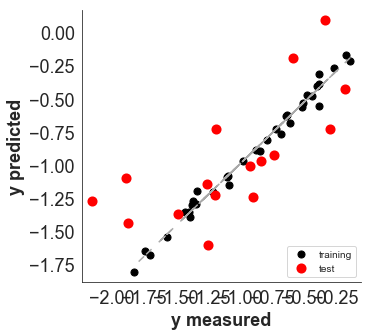

In [40]:
# Kernel Ridge Regression 
# kernel options: linear, poly, rbf
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio)) 

r2s = []
q2s = []
parms = []
print("\n\nKernelRidge")

kernel="poly" #rbf (only works if properties are related)
degree=2  #2 simulates crossterms 

parm_range = np.logspace(-3,3,7)
for parm in parm_range:
    print(parm)
    kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = kr.predict(X_train_sc)
    y_pred_test =  kr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        kr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(kr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = kr.predict(X_train_sc)
y_pred_test =  kr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)



### Support Vector Regression


Split method: y_equidist
Test ratio: 0.2



Support Vector Regression
1.00E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
2.68E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
7.20E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
1.93E-02
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
5.18E-02
     Training R2;Training Q2;Test R2;-0.11;-0.49;-0.30
1.39E-01
     Training R2;Training Q2;Test R2;-0.10;-0.50;-0.32
3.73E-01
     Training R2;Training Q2;Test R2;-0.06;-0.52;-0.35
1.00E+00
     Training R2;Training Q2;Test R2;0.03;-0.56;-0.42
2.68E+00
     Training R2;Training Q2;Test R2;0.10;-0.45;-0.60
7.20E+00
     Training R2;Training Q2;Test R2;0.14;-0.80;-0.92
1.93E+01
     Training R2;Training Q2;Test R2;0.15;-1.47;-1.09
5.18E+01
     Training R2;Training Q2;Test R2;0.19;-2.14;-1.53
1.39E+02
     Training R2;Training Q2;Test R2;0.29;-3.10;-2.95
3.73E+02
     Training R2;Training Q2;Test R2;0.55;-6.64;-8.61
1.00E+03
     Training R2;Training Q2;Te

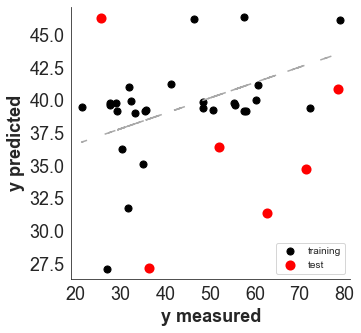

In [121]:
# SVR
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

r2s = []
q2s = []
parms = []
print("\n\nSupport Vector Regression")

kernel="poly"
degree=2
gamma="auto"

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print("{:.2E}".format(parm))
    svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = svr.predict(X_train_sc)
    y_pred_test =  svr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,SVR(kernel=kernel,degree=degree,gamma=gamma,C=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        svr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(svr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = svr.predict(X_train_sc)
y_pred_test =  svr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)
   

# keepmodels_[svr] = ()

### Regression with Principal Components


Split method: random
Test ratio: 0.3

PC Regression 1
Training R2;Training Q2;Test R2;0.01;-0.14;-0.01


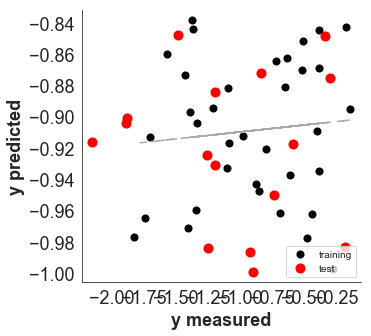


Split method: random
Test ratio: 0.3

PC Regression 2
Training R2;Training Q2;Test R2;0.22;0.07;0.15


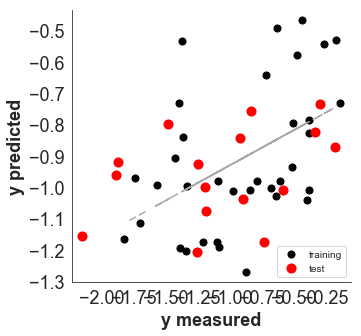


Split method: random
Test ratio: 0.3

PC Regression 3
Training R2;Training Q2;Test R2;0.32;0.13;0.30


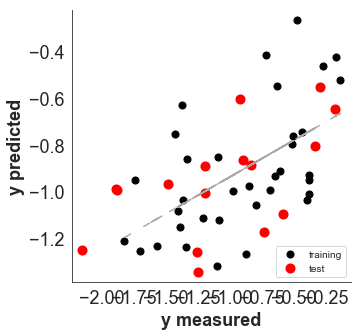


Split method: random
Test ratio: 0.3

PC Regression 4
Training R2;Training Q2;Test R2;0.32;-0.03;0.30


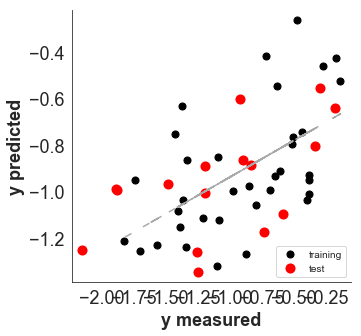


Split method: random
Test ratio: 0.3

PC Regression 5
Training R2;Training Q2;Test R2;0.32;-0.08;0.29


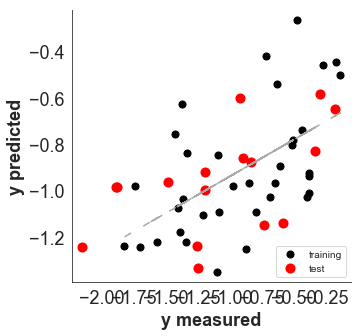


Split method: random
Test ratio: 0.3

PC Regression 6
Training R2;Training Q2;Test R2;0.42;-0.10;0.35


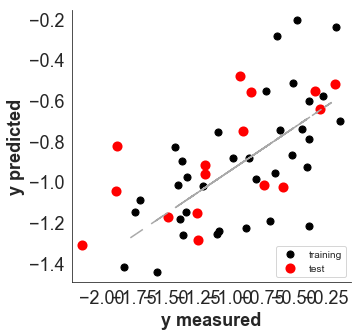


Split method: random
Test ratio: 0.3

PC Regression 7
Training R2;Training Q2;Test R2;0.43;-0.17;0.34


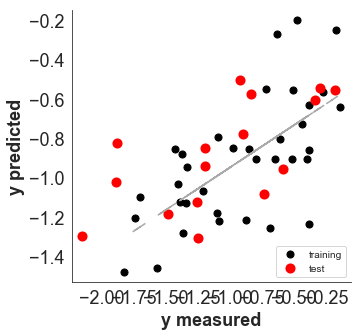


Split method: random
Test ratio: 0.3

PC Regression 8
Training R2;Training Q2;Test R2;0.51;0.07;0.38


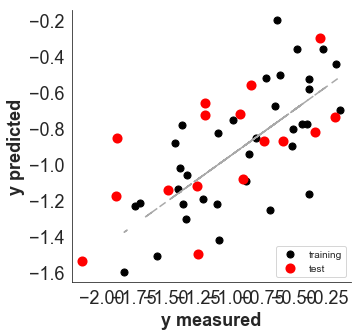

In [41]:
# Regression with Principal Components

for npca in range(1,9):
    pca = PCA(n_components=npca)
    pca.fit(scaler.transform(X_sel))
#     pca.fit(X_train_sc)
    X_train_pca = pca.transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)

    pca_score = pca.explained_variance_ratio_
    pca_values = pca.singular_values_
    V = pca.components_

    linr = LinearRegression().fit(X_train_pca, y_train)
#     linr = Ridge(alpha=1).fit(X_train_pca,y_train)
    y_pred_train = linr.predict(X_train_pca)
    y_pred_test =  linr.predict(X_test_pca)
    q2,loo_train = loo.q2(X_train_pca,y_train,LinearRegression())
    print("\nSplit method: {}".format(split))
    print("Test ratio: {}".format(test_ratio))
    print("\nPC Regression {}".format(npca))
    print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        linr.score(X_train_pca, y_train),q2,r2_val(y_test,y_pred_test,y_train)))



    plot_fit(y_train,y_pred_train,y_test,y_pred_test)

    
# # virtual screening
# X_screen_sel = pca.transform(X_all_sc)
# y_pred_vscreen = linr.predict(X_screen_sel)
# y_vscreen["PCA5"] = y_pred_vscreen


# keepmodels_[PCA(n_components=2).fit(scaler.transform(X_sel))] = ("n_components=2")

### Random Forest


Split method: random
Test ratio: 0.3

Training R2;Test R2;0.92;0.56


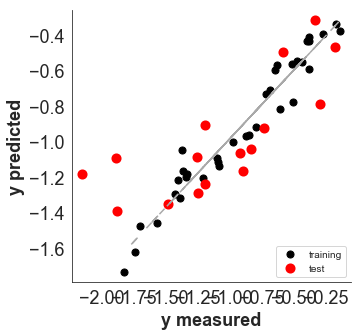

CPU times: user 1.49 s, sys: 85 ms, total: 1.57 s
Wall time: 1.45 s


In [42]:
%%time
# Random forest regression

rf  = RandomForestRegressor(n_estimators=500,random_state=42,n_jobs=None,max_features=None,max_depth=None).fit(
    X_train_sc, y_train)
# rf = GradientBoostingRegressor(
#     n_estimators=50,
#     subsample=.6,
#     max_depth=2,
#     random_state=42,
#     max_features=None,
#     alpha=0.9,
#     ).fit(X_train_sc, y_train)
y_pred_train = rf.predict(X_train_sc)
y_pred_test =  rf.predict(X_test_sc)
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))
print("Training R2;Test R2;{:.2f};{:.2f}".format(
    rf.score(X_train_sc, y_train),r2_val(y_test,y_pred_test,y_train)))
# print(np.where(llcv.coef_ != 0)[1])

plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

# keepmodels_[rf] = ()